# Bank Data Exploratory Data Analysis (EDA)

Taken from https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip

The financial company “Prêt à dépenser” seeks to assess the creditworthiness of customers wishing to take out consumer credit. The aim of the project is to establish a score for each customer based on various banking information, enabling the company to decide whether or not to grant a loan accordingly.

Local and global explanations of the scoring model must be provided

## 0) Import libraries

In [1]:
#Essential data science libraries
import pandas as pd
import seaborn as sns
import glob # equivalent of "ls" in linux (can use wildmarks etc.)
import pickle
import os
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.set_option('display.float_format', '{:.3f}'.format) # don't want scientific notation. Floats are enough
pd.set_option('display.max_colwidth', None)

In [3]:
#Graphing…
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

## 1) Data Description

### Data sources, meanings

(Based on 2 kaggel kernels :
- https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction
- https://www.kaggle.com/danilz/merge-all-data-base-glm-vs-xgb-explained-0-763)

There are 7 different sources of data:

application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

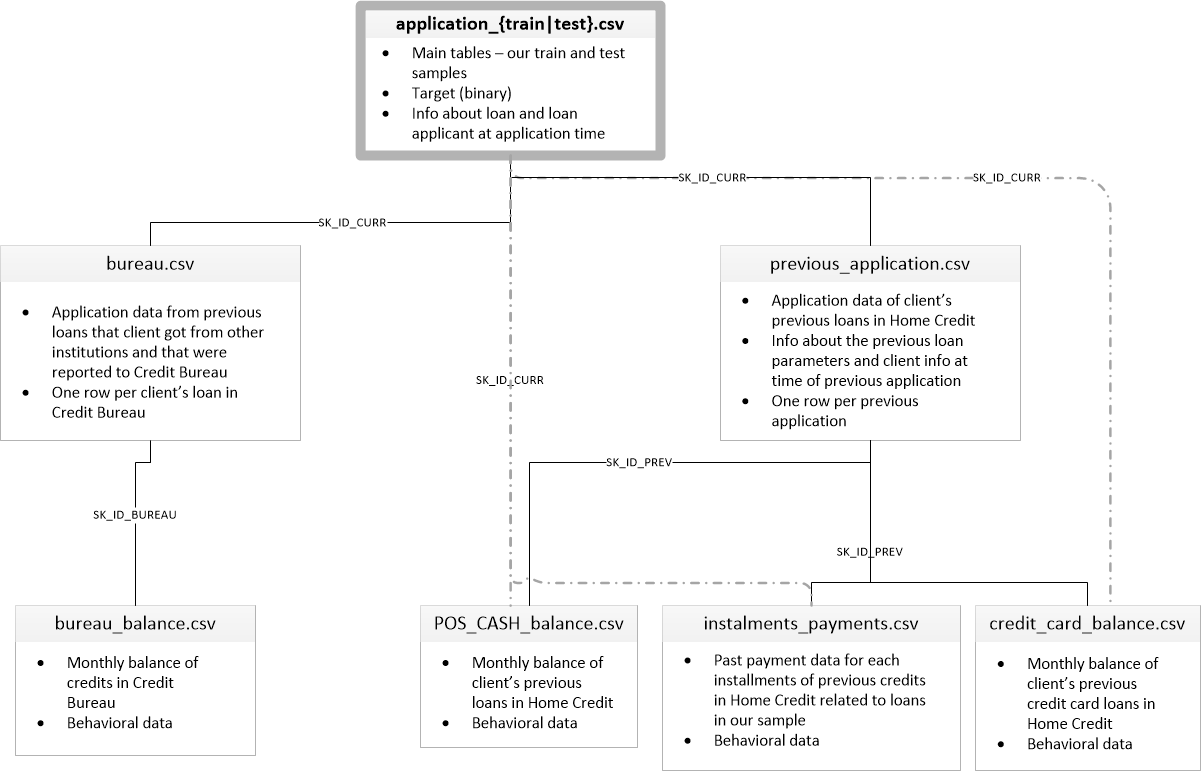

client ID : `SK_ID_CURR`
available in all .csv files except `bureau_balance.csv`

Also a HomeCredit_columns_description.csv file contains descriptions for the columns in the various data files

In this project, only application_train will be used (application_test will be ignored). From application_train, two dataframes will be created: `new_app_train` (~80%) and `new_app_test` (20%).
We want the same distribution for the two sub-dataframes. The first one will be used to train the model and the second's `TARGET` values will be estimated then compared to the real values.

### Opening CSV file

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Colab_Notebooks/Project_4")
os.listdir()
# print(f'Working directory: {os.getcwd()}')

Mounted at /content/drive


['p7_01_eda_notebook.ipynb',
 'functions',
 'input',
 'start-here-a-gentle-introduction.ipynb',
 'scoring_model.ipynb',
 'merged_data.zip',
 'train.zip',
 'test.zip',
 'data_train.zip',
 'data_test.zip',
 'TARGET.csv',
 'catboost_info',
 'p7_02_modelisation_notebook.ipynb',
 'EDA.ipynb',
 'explication_client_0.html',
 'explication_client_2.html',
 'MODEL.ipynb']

In [5]:
print("CHECKLIST DATA EXPLORER :")
display(os.listdir('./input/'))

CHECKLIST DATA EXPLORER :


['installments_payments.csv',
 'credit_card_balance.csv',
 'bureau.csv',
 'POS_CASH_balance.csv',
 'sample_submission.csv',
 'application_train.csv',
 'HomeCredit_columns_description.csv',
 'previous_application.csv',
 'application_test.csv',
 'bureau_balance.csv']

In [6]:
%%time
application_train = pd.read_csv('input/application_train.csv')
application_test = pd.read_csv('input/application_test.csv')

CPU times: user 8.59 s, sys: 1.21 s, total: 9.8 s
Wall time: 27.1 s


In [7]:
%%time
bureau = pd.read_csv('input/bureau.csv')
bureau_balance = pd.read_csv('input/bureau_balance.csv')
credit_card_balance = pd.read_csv('input/credit_card_balance.csv')
installments_payments = pd.read_csv('input/installments_payments.csv')
POS_CASH_balance = pd.read_csv('input/POS_CASH_balance.csv')
previous_application = pd.read_csv('input/previous_application.csv')

CPU times: user 53.4 s, sys: 12.5 s, total: 1min 5s
Wall time: 1min 29s


In [8]:
print("DOCUMENTATION :")
pd.set_option("max_colwidth", 300)
# description = pd.read_csv('data/HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
description = pd.read_csv('input/HomeCredit_columns_description.csv', index_col='Unnamed: 0', encoding="latin")
description

DOCUMENTATION :


Table                           Row  \
1    application_{train|test}.csv                    SK_ID_CURR   
2    application_{train|test}.csv                        TARGET   
5    application_{train|test}.csv            NAME_CONTRACT_TYPE   
6    application_{train|test}.csv                   CODE_GENDER   
7    application_{train|test}.csv                  FLAG_OWN_CAR   
8    application_{train|test}.csv               FLAG_OWN_REALTY   
9    application_{train|test}.csv                  CNT_CHILDREN   
10   application_{train|test}.csv              AMT_INCOME_TOTAL   
11   application_{train|test}.csv                    AMT_CREDIT   
12   application_{train|test}.csv                   AMT_ANNUITY   
13   application_{train|test}.csv               AMT_GOODS_PRICE   
14   application_{train|test}.csv               NAME_TYPE_SUITE   
15   application_{train|test}.csv              NAME_INCOME_TYPE   
16   application_{train|test}.csv           NAME_EDUCATION_TYPE   
17   application_{train|test}.csv            NAME_FAMILY_STATUS   
18   application_{train|test}.csv             NAME_HOUSING_TYPE   
19   application_{train|test}.csv    REGION_POPULATION_RELATIVE   
20   application_{train|test}.csv                    DAYS_BIRTH   
21   application_{train|test}.csv                 DAYS_EMPLOYED   
22   application_{train|test}.csv             DAYS_REGISTRATION   
23   application_{train|test}.csv               DAYS_ID_PUBLISH   
24   application_{train|test}.csv                   OWN_CAR_AGE   
25   application_{train|test}.csv                    FLAG_MOBIL   
26   application_{train|test}.csv                FLAG_EMP_PHONE   
27   application_{train|test}.csv               FLAG_WORK_PHONE   
28   application_{train|test}.csv              FLAG_CONT_MOBILE   
29   application_{train|test}.csv                    FLAG_PHONE   
30   application_{train|test}.csv                    FLAG_EMAIL   
31   application_{train|test}.csv               OCCUPATION_TYPE   
32   application_{train|test}.csv               CNT_FAM_MEMBERS   
33   application_{train|test}.csv          REGION_RATING_CLIENT   
34   application_{train|test}.csv   REGION_RATING_CLIENT_W_CITY   
35   application_{train|test}.csv    WEEKDAY_APPR_PROCESS_START   
36   application_{train|test}.csv       HOUR_APPR_PROCESS_START   
37   application_{train|test}.csv    REG_REGION_NOT_LIVE_REGION   
38   application_{train|test}.csv    REG_REGION_NOT_WORK_REGION   
39   application_{train|test}.csv   LIVE_REGION_NOT_WORK_REGION   
40   application_{train|test}.csv        REG_CITY_NOT_LIVE_CITY   
41   application_{train|test}.csv        REG_CITY_NOT_WORK_CITY   
42   application_{train|test}.csv       LIVE_CITY_NOT_WORK_CITY   
43   application_{train|test}.csv             ORGANIZATION_TYPE   
44   application_{train|test}.csv                  EXT_SOURCE_1   
45   application_{train|test}.csv                  EXT_SOURCE_2   
46   application_{train|test}.csv                  EXT_SOURCE_3   
47   application_{train|test}.csv                APARTMENTS_AVG   
48   application_{train|test}.csv              BASEMENTAREA_AVG   
49   application_{train|test}.csv   YEARS_BEGINEXPLUATATION_AVG   
50   application_{train|test}.csv               YEARS_BUILD_AVG   
51   application_{train|test}.csv                COMMONAREA_AVG   
52   application_{train|test}.csv                 ELEVATORS_AVG   
53   application_{train|test}.csv                 ENTRANCES_AVG   
54   application_{train|test}.csv                 FLOORSMAX_AVG   
55   application_{train|test}.csv                 FLOORSMIN_AVG   
56   application_{train|test}.csv                  LANDAREA_AVG   
57   application_{train|test}.csv          LIVINGAPARTMENTS_AVG   
58   application_{train|test}.csv                LIVINGAREA_AVG   
59   application_{train|test}.csv       NONLIVINGAPARTMENTS_AVG   
60   application_{train|test}.csv             NONLIVINGAREA_AVG   
61   application_{train|test}.csv               APARTMENTS_MODE   
62   app

In [51]:
description[description['Row']=='FLAG_DOCUMENT_10']

Table               Row  \
107  application_{train|test}.csv  FLAG_DOCUMENT_10   

                        Description Special  
107  Did client provide document 10     NaN

In [ ]:
def data_describe(folder):
    '''Check the number of rows, columns, missing values and duplicates.
       Count type of columns.
       Memory indication'''

    data_dict = {}
    for file in folder:
      try:
        data = pd.read_csv(file)
      except UnicodeDecodeError:
        data = pd.read_csv(file, encoding="latin")
      data_dict[file] = [data.shape[0],
                          data.shape[1],
                          round(data.isna().sum().sum()/data.size*100, 2), # count all NaNs in the whole dataset
                          round(data.duplicated().sum().sum()/data.size*100, 2), # count all duplicates in the whole dataset
                          data.select_dtypes(include=['object']).shape[1], # count the amount of variables which types include "object"
                          data.select_dtypes(include=['float']).shape[1],
                          data.select_dtypes(include=['int']).shape[1],
                          data.select_dtypes(include=['bool']).shape[1],
                          round(data.memory_usage().sum()/1024**2, 3)]

      comparative_table = pd.DataFrame.from_dict(data = data_dict,
                                                  columns = ['Rows', 'Columns', '%NaN', '%Duplicate',
                                                            'object_dtype','float_dtype', 'int_dtype',
                                                            'bool_dtype', 'MB_Memory'],
                                                  orient='index')
    print("SUMMARY FILES…")
    return(comparative_table)

In [ ]:
%%time
#Data description
data_describe(folder = glob.glob('./input/*.csv'))

SUMMARY FILES…
CPU times: user 1min 14s, sys: 11.8 s, total: 1min 26s
Wall time: 1min 34s


Rows  Columns   %NaN  \
./input/installments_payments.csv           13605401        8  0.010   
./input/credit_card_balance.csv              3840312       23  6.650   
./input/bureau.csv                           1716428       17 13.500   
./input/POS_CASH_balance.csv                10001358        8  0.070   
./input/sample_submission.csv                  48744        2  0.000   
./input/application_train.csv                 307511      122 24.400   
./input/HomeCredit_columns_description.csv       219        5 12.150   
./input/previous_application.csv             1670214       37 17.980   
./input/application_test.csv                   48744      121 23.810   
./input/bureau_balance.csv                  27299925        3  0.000   

                                            %Duplicate  object_dtype  \
./input/installments_payments.csv                0.000             0   
./input/credit_card_balance.csv                  0.000             1   
./input/bureau.csv                               0.000             3   
./input/POS_CASH_balance.csv                     0.000             1   
./input/sample_submission.csv                    0.000             0   
./input/application_train.csv                    0.000            16   
./input/HomeCredit_columns_description.csv       0.000             4   
./input/previous_application.csv                 0.000            16   
./input/application_test.csv                     0.000            16   
./input/bureau_balance.csv                       0.000             1   

                                            float_dtype  int_dtype  \
./input/installments_payments.csv                     5          3   
./input/credit_card_balance.csv                      15          7   
./input/bureau.csv                                    8          6   
./input/POS_CASH_balance.csv                          2          5   
./input/sample_submission.csv                         1          1   
./input/application_train.csv                        65         41   
./input/HomeCredit_columns_description.csv            0          1   
./input/previous_application.csv                     15          6   
./input/application_test.csv                         65         40   
./input/bureau_balance.csv                            0          2   

                                            bool_dtype  MB_Memory  
./input/installments_payments.csv                    0    830.408  
./input/credit_card_balance.csv                      0    673.883  
./input/bureau.csv                                   0    222.620  
./input/POS_CASH_balance.csv                         0    610.435  
./input/sample_submission.csv                        0      0.744  
./input/application_train.csv                        0    286.227  
./input/HomeCredit_columns_description.csv           0      0.008  
./input/previous_application.csv                     0    471.481  
./input/application_test.csv                         0     44.998  
./input/bureau_balance.csv                           0    624.846

In [ ]:
def features(folder):
    '''Comparative data with missing values (df1), and many descriptive statistics (df2 = df1 + other statistics).'''

    data_object = {}
    data_numeric = {}

    for file in folder:
      try:
        data = pd.read_csv(file)
      except UnicodeDecodeError:
        data = pd.read_csv(file, encoding="latin")

      data_object[file] = [(x, data[x].dtype,
                            data[x].isna().sum().sum(),
                            int(data[x].count())) for x in data.select_dtypes(exclude=['int', 'float'])]

      data_numeric[file] = [(x, data[x].dtype,
                              int(data[x].isna().sum().sum()),
                              int(data[x].count()),
                              int(data[x].mean()),
                              round(data[x].std(),1),
                              round(data[x].min(),1),
                              round(data[x].max(),1)) for x in data.select_dtypes(exclude='object')]


    comparative_object = pd.DataFrame.from_dict(data = data_object, orient='index')
    dict_of_object = {name: pd.DataFrame(file) for name,file in data_object.items()}
    df1 = pd.concat(dict_of_object, axis=0)
    df1.columns=['features','dtype','nan','count']

    comparative_numeric = pd.DataFrame.from_dict(data = data_numeric, orient='index')
    dict_of_numeric = {name: pd.DataFrame(file) for name,file in data_numeric.items()}
    df2 = pd.concat(dict_of_numeric, axis=0)
    df2.columns=['features','dtype','nan','count', 'mean', 'std', 'min','max']

    return df1, df2

In [ ]:
%%time
#Data description
features = features(folder=glob.glob('./input/*.csv'))

CPU times: user 35.3 s, sys: 6.18 s, total: 41.5 s
Wall time: 45 s


In [ ]:
features[0]

features  \
./input/credit_card_balance.csv            0          NAME_CONTRACT_STATUS   
./input/bureau.csv                         0                 CREDIT_ACTIVE   
                                           1               CREDIT_CURRENCY   
                                           2                   CREDIT_TYPE   
./input/POS_CASH_balance.csv               0          NAME_CONTRACT_STATUS   
./input/application_train.csv              0            NAME_CONTRACT_TYPE   
                                           1                   CODE_GENDER   
                                           2                  FLAG_OWN_CAR   
                                           3               FLAG_OWN_REALTY   
                                           4               NAME_TYPE_SUITE   
                                           5              NAME_INCOME_TYPE   
                                           6           NAME_EDUCATION_TYPE   
                                           7            NAME_FAMILY_STATUS   
                                           8             NAME_HOUSING_TYPE   
                                           9               OCCUPATION_TYPE   
                                           10   WEEKDAY_APPR_PROCESS_START   
                                           11            ORGANIZATION_TYPE   
                                           12           FONDKAPREMONT_MODE   
                                           13               HOUSETYPE_MODE   
                                           14           WALLSMATERIAL_MODE   
                                           15          EMERGENCYSTATE_MODE   
./input/HomeCredit_columns_description.csv 0                         Table   
                                           1                           Row   
                                           2                   Description   
                                           3                       Special   
./input/previous_application.csv           0            NAME_CONTRACT_TYPE   
                                           1    WEEKDAY_APPR_PROCESS_START   
                                           2   FLAG_LAST_APPL_PER_CONTRACT   
                                           3        NAME_CASH_LOAN_PURPOSE   
                                           4          NAME_CONTRACT_STATUS   
                                           5             NAME_PAYMENT_TYPE   
                                           6            CODE_REJECT_REASON   
                                           7               NAME_TYPE_SUITE   
                                           8              NAME_CLIENT_TYPE   
                                           9           NAME_GOODS_CATEGORY   
                                           10               NAME_PORTFOLIO   
                                           11            NAME_PRODUCT_TYPE   
                                           12                 CHANNEL_TYPE   
                                           13         NAME_SELLER_INDUSTRY   
                                           14             NAME_YIELD_GROUP   
                                           15          PRODUCT_COMBINATION   
./input/application_test.csv               0            NAME_CONTRACT_TYPE   
                                           1                   CODE_GENDER   
                                           2                  FLAG_OWN_CAR   
                                           3               FLAG_OWN_REALTY   
                                           4               NAME_TYPE_SUITE   
                                           5              NAME_INCOME_TYPE   
                                           6           NAME_EDUCATION_TYPE   
                                           7            NAME_FAMILY_STATUS   
                                           8             NAME_HOUSING_TYPE   
                                           9               OCCUPATION_TYPE   
          

In [ ]:
features[1]

features  \
./input/installments_payments.csv          0                      SK_ID_PREV   
                                           1                      SK_ID_CURR   
                                           2          NUM_INSTALMENT_VERSION   
                                           3           NUM_INSTALMENT_NUMBER   
                                           4                 DAYS_INSTALMENT   
                                           5              DAYS_ENTRY_PAYMENT   
                                           6                  AMT_INSTALMENT   
                                           7                     AMT_PAYMENT   
./input/credit_card_balance.csv            0                      SK_ID_PREV   
                                           1                      SK_ID_CURR   
                                           2                  MONTHS_BALANCE   
                                           3                     AMT_BALANCE   
                                           4         AMT_CREDIT_LIMIT_ACTUAL   
                                           5        AMT_DRAWINGS_ATM_CURRENT   
                                           6            AMT_DRAWINGS_CURRENT   
                                           7      AMT_DRAWINGS_OTHER_CURRENT   
                                           8        AMT_DRAWINGS_POS_CURRENT   
                                           9         AMT_INST_MIN_REGULARITY   
                                           10            AMT_PAYMENT_CURRENT   
                                           11      AMT_PAYMENT_TOTAL_CURRENT   
                                           12       AMT_RECEIVABLE_PRINCIPAL   
                                           13                  AMT_RECIVABLE   
                                           14           AMT_TOTAL_RECEIVABLE   
                                           15       CNT_DRAWINGS_ATM_CURRENT   
                                           16           CNT_DRAWINGS_CURRENT   
                                           17     CNT_DRAWINGS_OTHER_CURRENT   
                                           18       CNT_DRAWINGS_POS_CURRENT   
                                           19      CNT_INSTALMENT_MATURE_CUM   
                                           20                         SK_DPD   
                                           21                     SK_DPD_DEF   
./input/bureau.csv                         0                      SK_ID_CURR   
                                           1                    SK_ID_BUREAU   
                                           2                     DAYS_CREDIT   
                                           3              CREDIT_DAY_OVERDUE   
                                           4             DAYS_CREDIT_ENDDATE   
                                           5               DAYS_ENDDATE_FACT   
                                           6          AMT_CREDIT_MAX_OVERDUE   
                                           7              CNT_CREDIT_PROLONG   
                                           8                  AMT_CREDIT_SUM   
                                           9             AMT_CREDIT_SUM_DEBT   
                                           10           AMT_CREDIT_SUM_LIMIT   
                                           11         AMT_CREDIT_SUM_OVERDUE   
                                           12             DAYS_CREDIT_UPDATE   
                                           13                    AMT_ANNUITY   
./input/POS_CASH_balance.csv               0                      SK_ID_PREV   
                                           1                      SK_ID_CURR   
                                           2                  MONTHS_BALANCE   
                                           3                  CNT_INSTALMENT   
                                           4           CNT_INSTALMENT_FUTURE   
                                           5                        

### EDA application_train.csv | test.csv
The first part provides an overview of the available data. A more in-depth analysis of the features of the main file(s) is required.

In [ ]:
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


In [ ]:
#Check if 'TARGET' is the only difference ;-)
display(application_train.columns.difference(application_test.columns))
print("Check theses two files for Train (with TARGET) and Test (without TARGET).")

Index(['TARGET'], dtype='object')

Check theses two files for Train (with TARGET) and Test (without TARGET).


In [ ]:
#Distribution of the Target Column
application_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

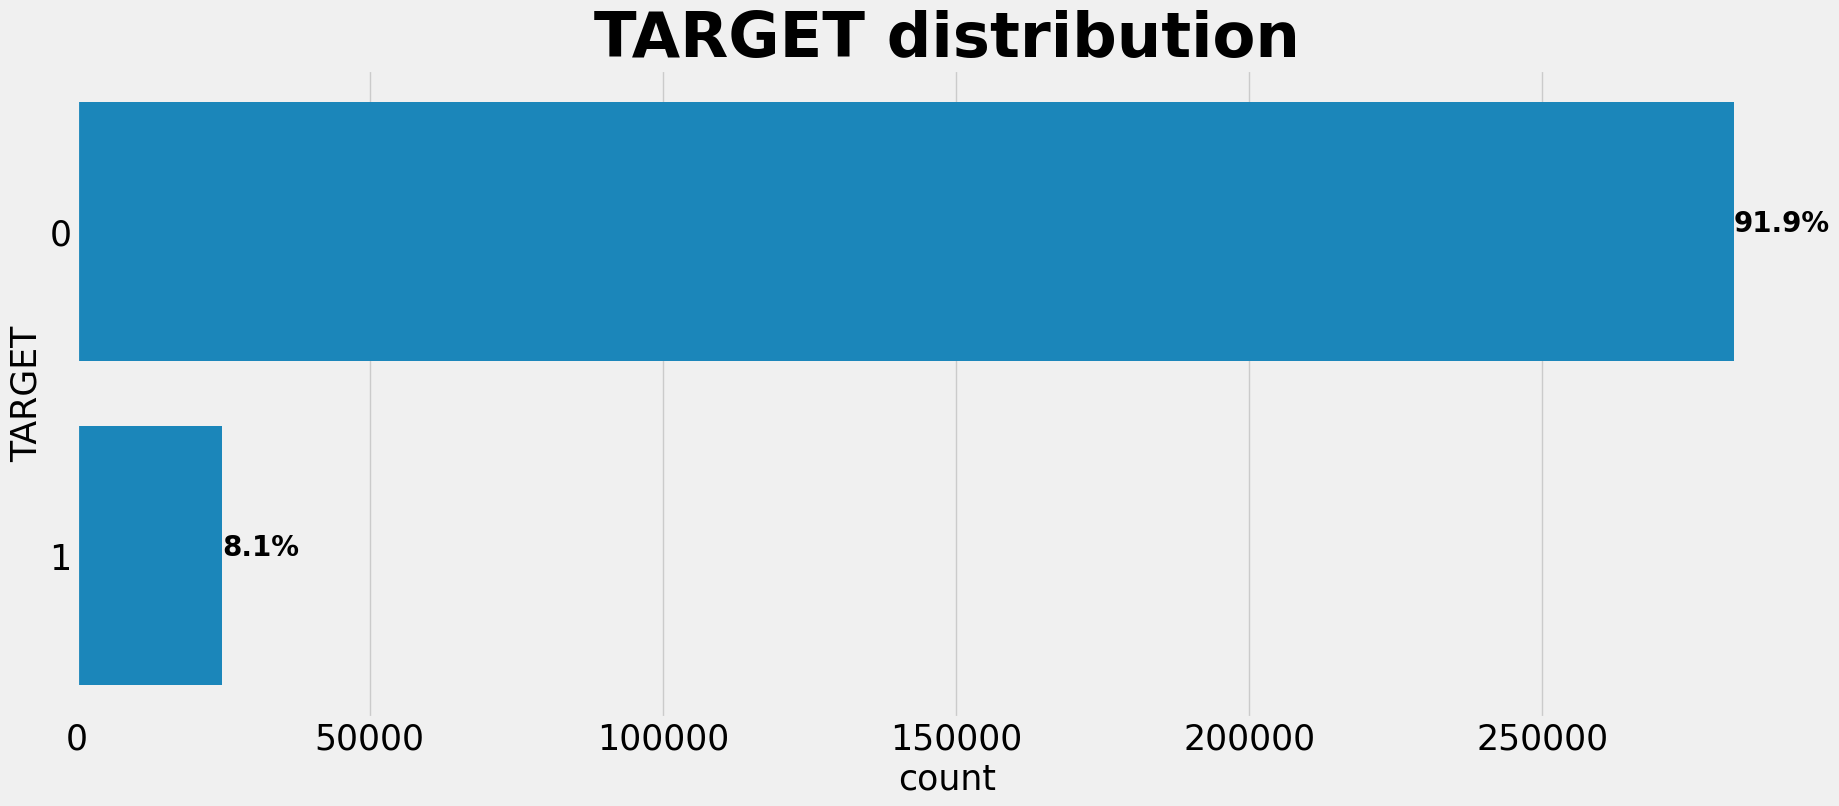

In [ ]:
ax, fig = plt.subplots(figsize=(20,8))
ax = sns.countplot(y='TARGET', data=application_train)
ax.set_title("TARGET distribution")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(application_train.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

plt.show()

Note the unbalanced classes. There are far more loans repaid on time than not. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### Column types
Quick analysis of feature types, but above all an overview to help you think about the encoding of categorical data.

In [ ]:
#Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [ ]:
#Number of unique classes in each object column
application_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most categorical variables have a relatively small number of unique entries. We will have to find a way to handle these categorical variables...

### Missing Values
In modeling, models such as XGBoost can handle missing values without imputation. Several alternatives are possible: replace NaNs, delete columns with a high percentage of missing values (it's impossible to know in advance whether these columns will be useful for our model). For the time being, all columns are kept... Missing values imputation will be done later.

<Axes: >

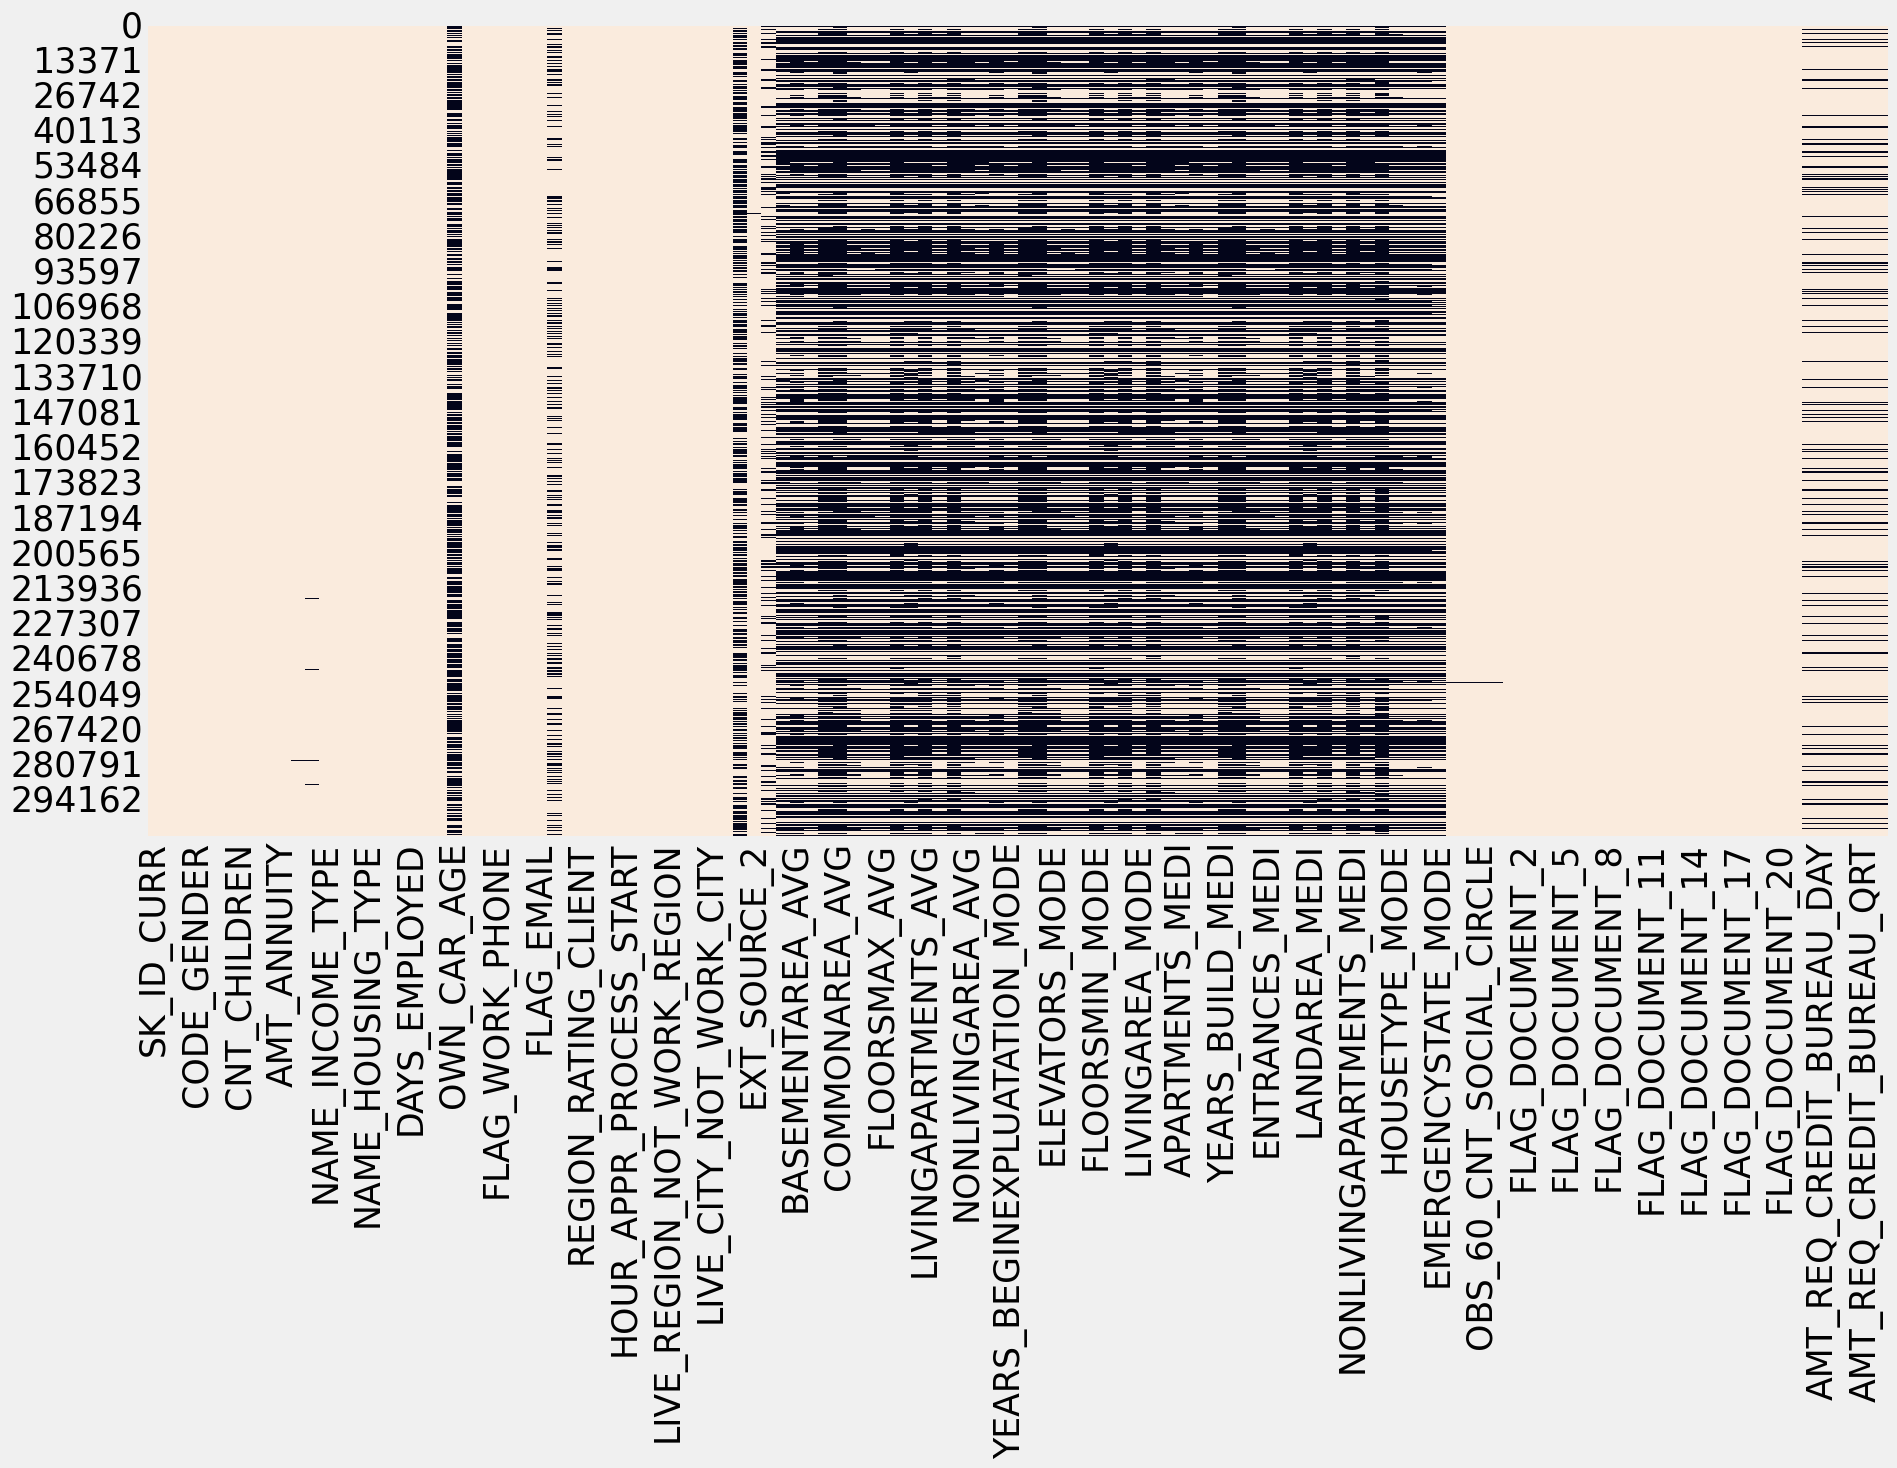

In [ ]:
#Global view of the missing values (black)
plt.figure(figsize=(20,10))
sns.heatmap(application_train.notna(), cbar=False)

A somewhat confusing summary of missing data due to the large number of variables, but an initial observation emerges which shows that NaNs are more strongly present on habitat characteristics (and not on credits), as the TOP 10 below attests...

In [ ]:
def nan_check(data):
    '''Check Missing Values'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2],
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

print('TOP 10 Missing values from Training dataset')
nan_check(application_train)[:10]

TOP 10 Missing values from Training dataset


Total      %
COMMONAREA_MEDI           214865 69.870
COMMONAREA_AVG            214865 69.870
COMMONAREA_MODE           214865 69.870
NONLIVINGAPARTMENTS_MODE  213514 69.430
NONLIVINGAPARTMENTS_AVG   213514 69.430
NONLIVINGAPARTMENTS_MEDI  213514 69.430
FONDKAPREMONT_MODE        210295 68.390
LIVINGAPARTMENTS_MODE     210199 68.350
LIVINGAPARTMENTS_AVG      210199 68.350
LIVINGAPARTMENTS_MEDI     210199 68.350

In [ ]:
print("Nb of columns in the training sample: " + str(len(nan_check(application_train))))

print("Nb of columns in the training sample with missing values: " +
      str(len(nan_check(application_train)[nan_check(application_train)['Total']!=0])))

Nb of columns in the training sample: 122
Nb of columns in the training sample with missing values: 67


### Outliers, atypical, abnormal values
To begin with, it's easy to see that variables such as 'DAYS_BIRTH' have negative values. It is therefore important to be able to analyze and, if necessary, rectify this type of data.

In [ ]:
#Client's age in days at the time of application (def. from HomeCredit_columns_description.csv)
application_train['DAYS_BIRTH'].describe()

count   307511.000
mean    -16036.995
std       4363.989
min     -25229.000
25%     -19682.000
50%     -15750.000
75%     -12413.000
max      -7489.000
Name: DAYS_BIRTH, dtype: float64

Les nombres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Il est nécessaire de modifier cette variable pour obtenir des chiffres plus compréhensibles pour l'analyse.

In [ ]:
(application_train['DAYS_BIRTH'] / -365).describe()

count   307511.000
mean        43.937
std         11.956
min         20.518
25%         34.008
50%         43.151
75%         53.923
max         69.121
Name: DAYS_BIRTH, dtype: float64

Text(0.5, 1.0, 'Age of client')

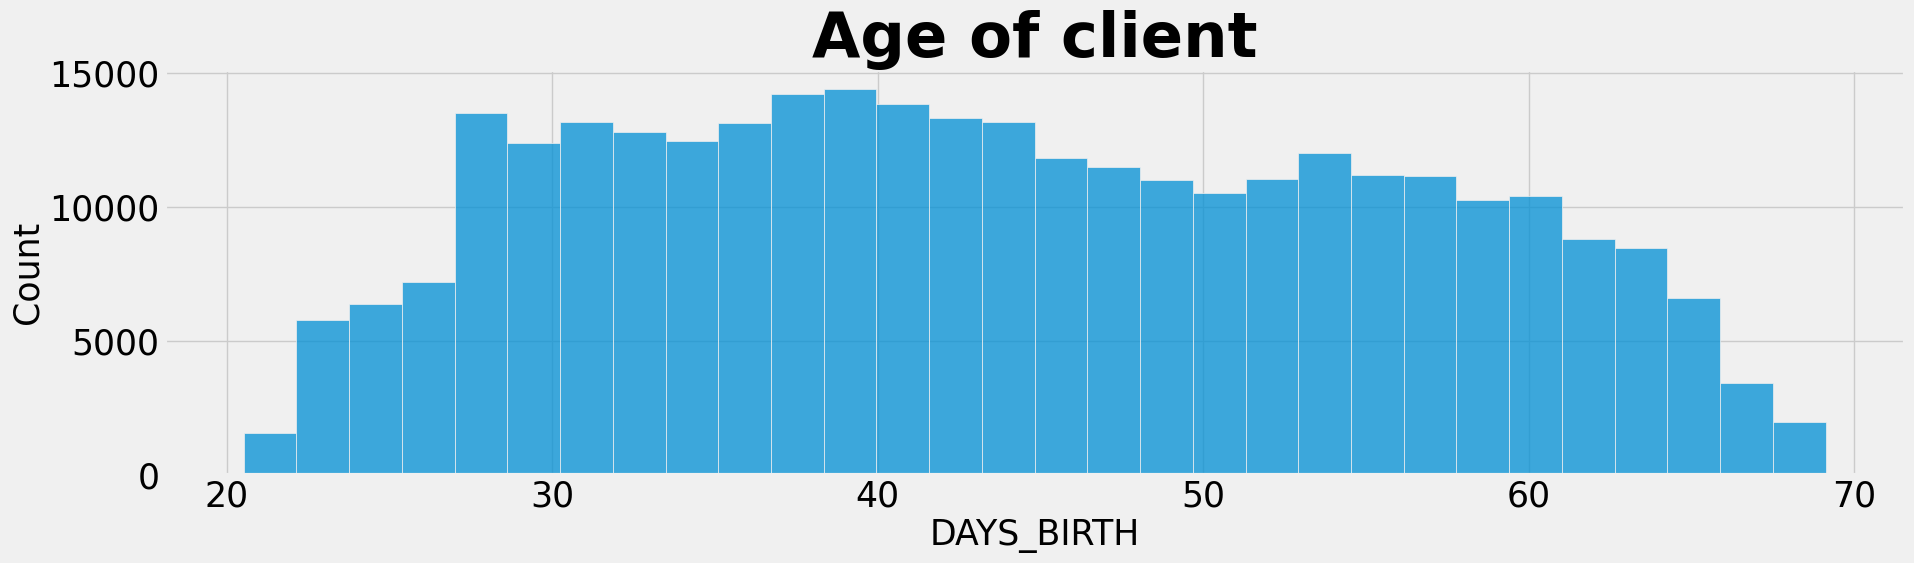

In [ ]:
plt.figure(figsize=(20, 5))
sns.histplot((application_train['DAYS_BIRTH'] / -365), bins = 30).set_title('Age of client')

In [ ]:
#How many days before loan request... (def. from HomeCredit_columns_description.csv)
application_train['DAYS_EMPLOYED'].describe()

count   307511.000
mean     63815.046
std     141275.767
min     -17912.000
25%      -2760.000
50%      -1213.000
75%       -289.000
max     365243.000
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
application_test['DAYS_EMPLOYED'].describe()

count    48744.000
mean     67485.366
std     144348.507
min     -17463.000
25%      -2910.000
50%      -1293.000
75%       -296.000
max     365243.000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

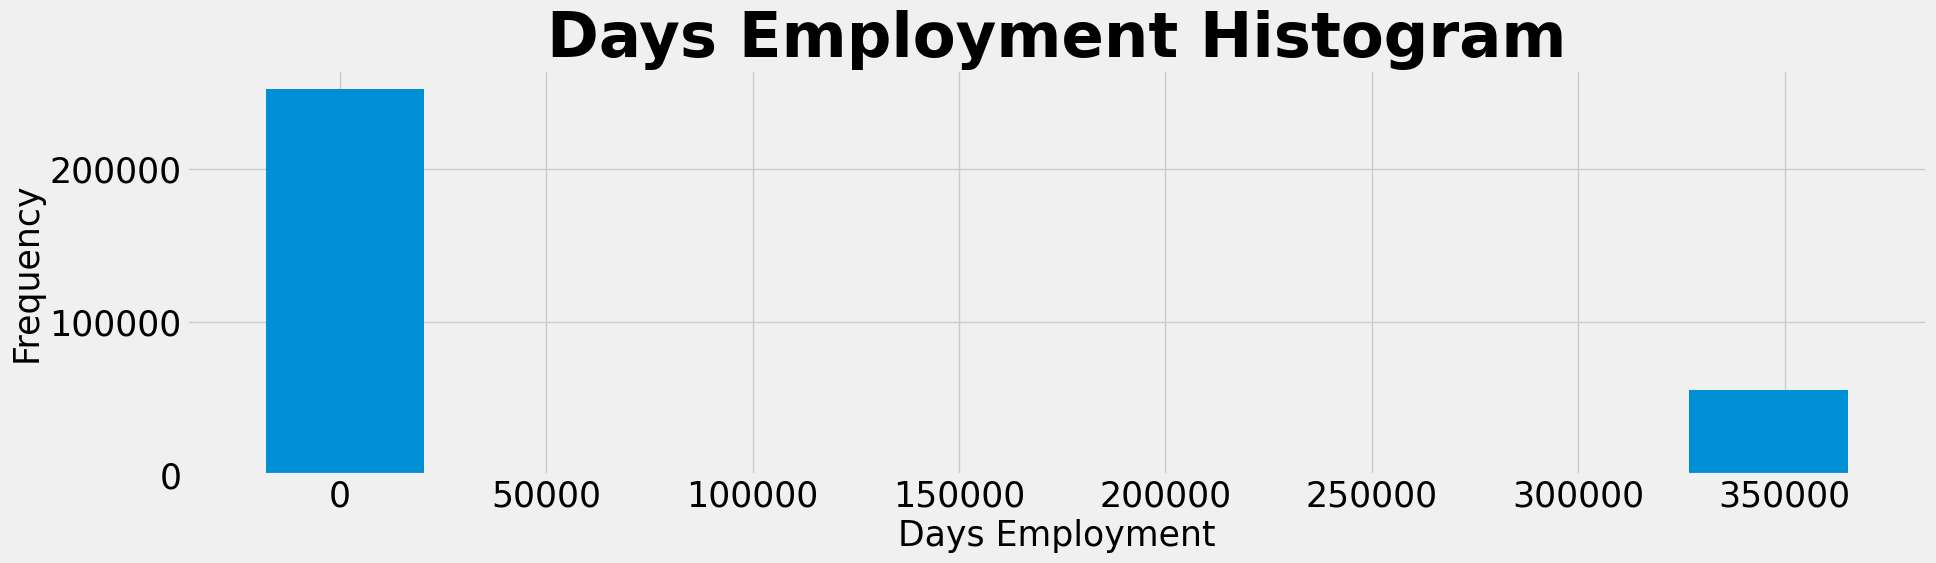

In [ ]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram', figsize=(20,5));
plt.xlabel('Days Employment')

Idem ces données ne sont pas "normales" au sens où le Max. représente 1000 années (365243/365j).
Est-ce un individu isolé? Plusieurs individus de l'échantillon?

In [ ]:
print("%0.0f values with 365243 days employed for training data" %
      len(application_train[application_train['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Total values from days employed for training data" % application_train.shape[0])
print("***********************")
print("%0.0f values with 365243 days employed for testing data" %
      len(application_test[application_test['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Total values from days employed for testing data" % application_test.shape[0])

55374 values with 365243 days employed for training data
307511 Total values from days employed for training data
***********************
9274 values with 365243 days employed for testing data
48744 Total values from days employed for testing data


In [ ]:
#Create an outliers flag column
application_train['DAYS_EMPLOYED_OUTLIERS'] = application_train["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED_OUTLIERS'] = application_test["DAYS_EMPLOYED"] == 365243

#Replace outliers values with nan
application_train['DAYS_EMPLOYED'] = application_train['DAYS_EMPLOYED'].replace({365243: np.nan})
application_test['DAYS_EMPLOYED'] = application_test['DAYS_EMPLOYED'].replace({365243: np.nan})

Text(0.5, 0, 'Days Employment')

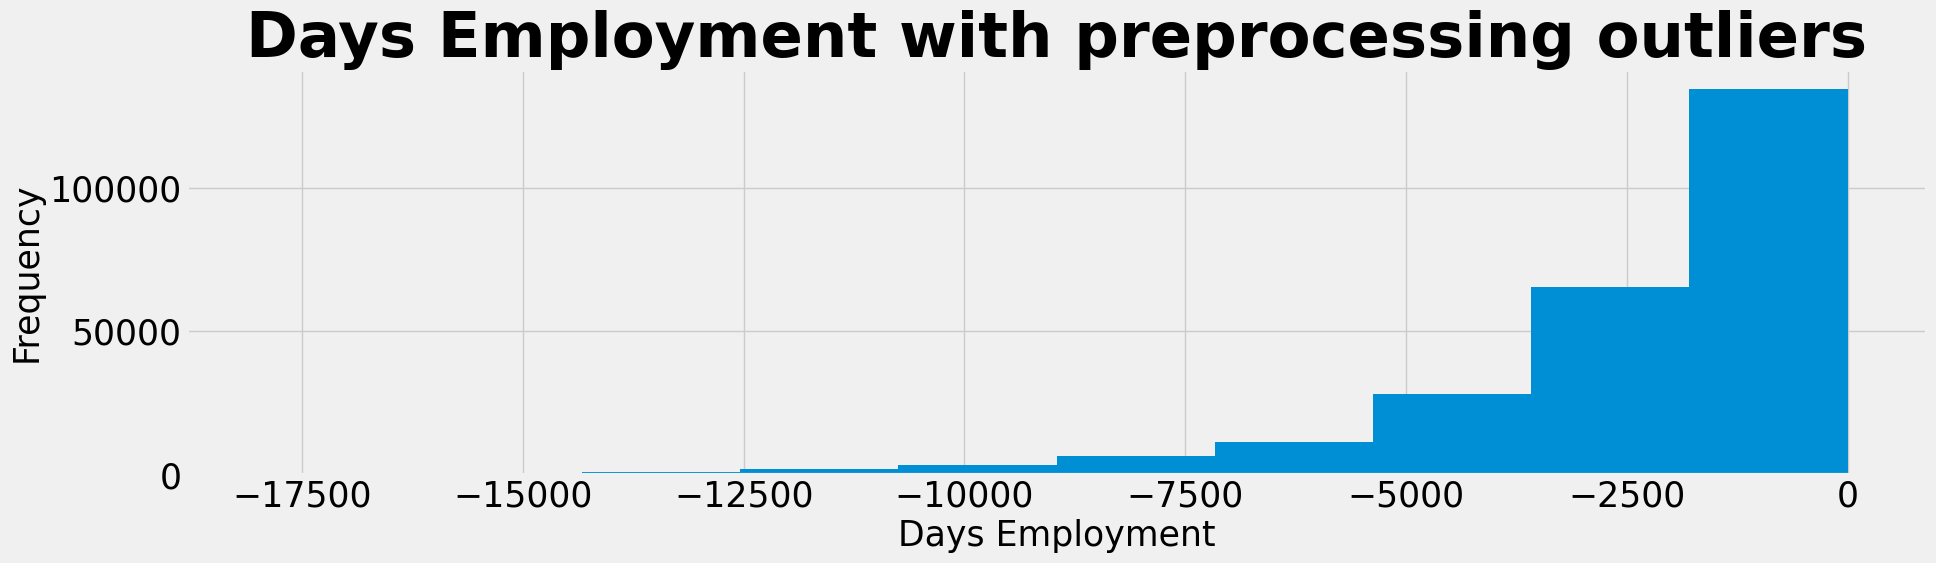

In [ ]:
application_train['DAYS_EMPLOYED'].plot.hist(title ='Days Employment with preprocessing outliers', figsize=(20,5))
plt.xlabel('Days Employment')

### Functions to facilitate analysis of key variables...
It's important to focus on the main features that can be explanatory. The idea here is not to analyze everything in univariate or multivariate terms, but simply to get a picture of the business points that help guide our decisions in “risk-taking” when granting a loan.

In [ ]:
def plot_stat(data, feature, title) :

    ax, fig = plt.subplots(figsize=(20,8))
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

In [ ]:
def plot_percent_target1(data, feature, title, type_of_average = 'mean_per_category'):
    '''
    Return a payment default percentage for each category (weighted averages)
    '''

    if type_of_average == 'weighted_global':
      cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).sum()
      cat_perc['TARGET'] = cat_perc['TARGET'] / len(data)
    elif type_of_average == 'mean_per_category':
      cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean() # weighted averages
    else:
      raise ValueError("type_of_average must be 'weighted_global' or 'mean_per_category'")

    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

    ax, fig = plt.subplots(figsize=(20,8))
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Percent of target with value 1")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

In [ ]:
feature = 'NAME_CONTRACT_TYPE'
cat_perc = application_train[[feature, 'TARGET']].groupby([feature],as_index=False).sum()
print(cat_perc)

  NAME_CONTRACT_TYPE  TARGET
0         Cash loans   23221
1    Revolving loans    1604


**Loan types -** Distribution of type of loans taken out + comparison with percentage of loans with TARGET 1 value (loan not returned).

                                   -------------------------------------------------------


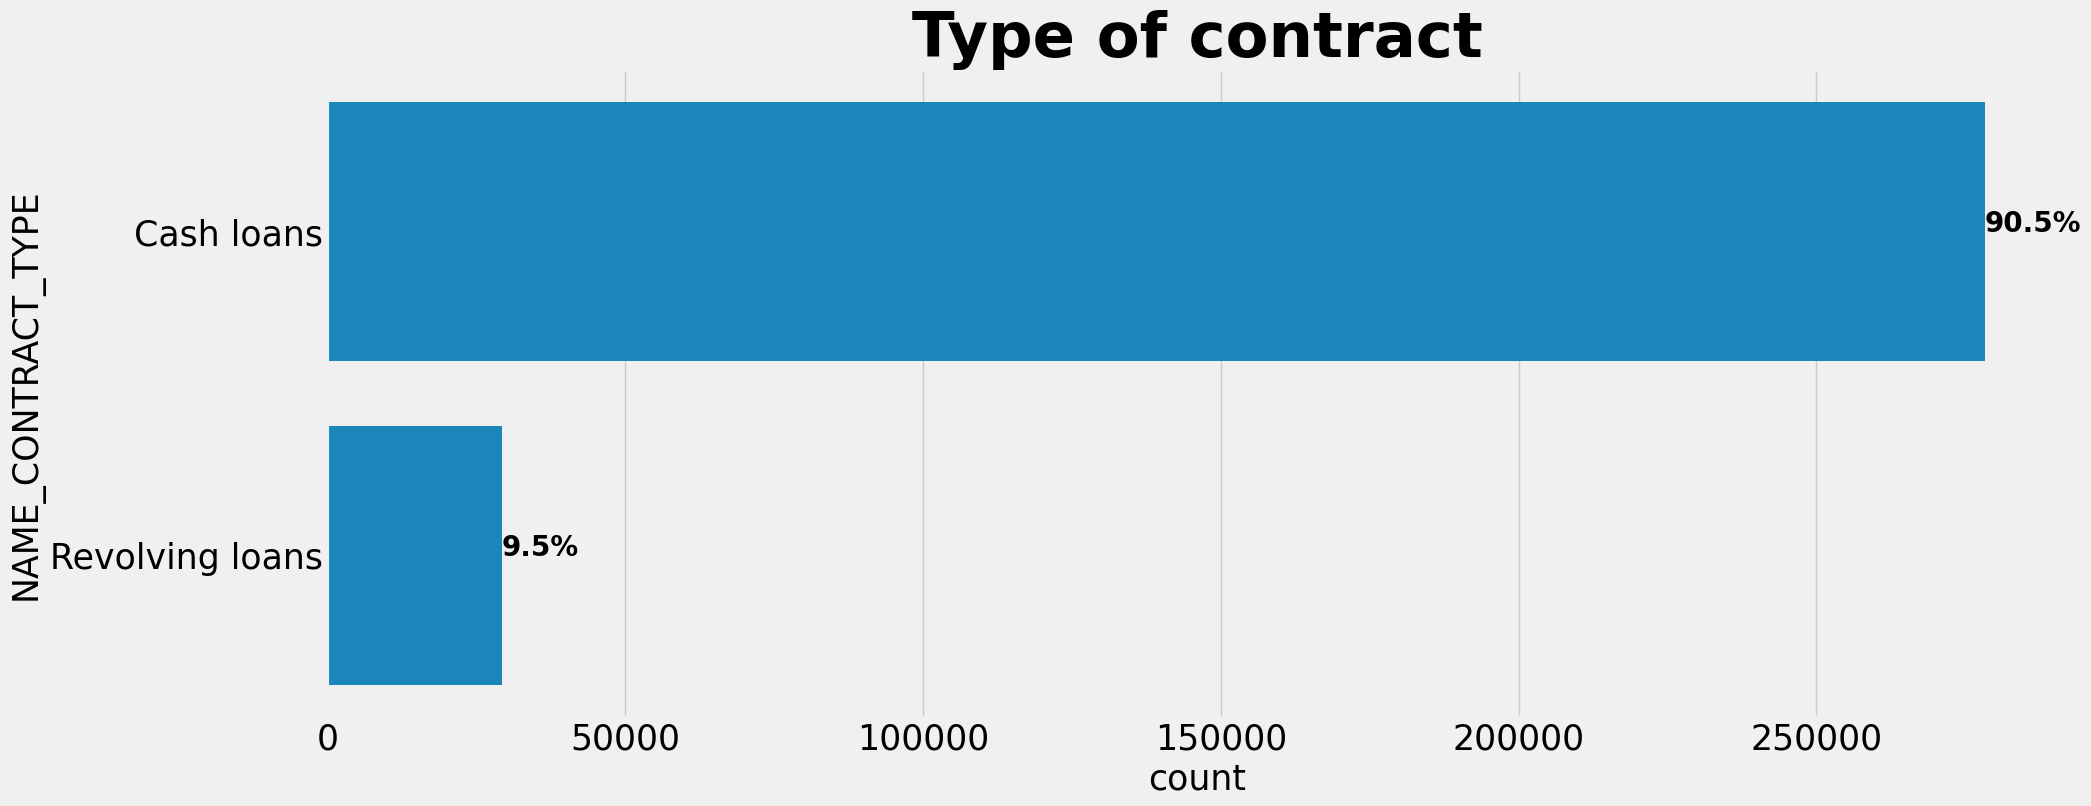

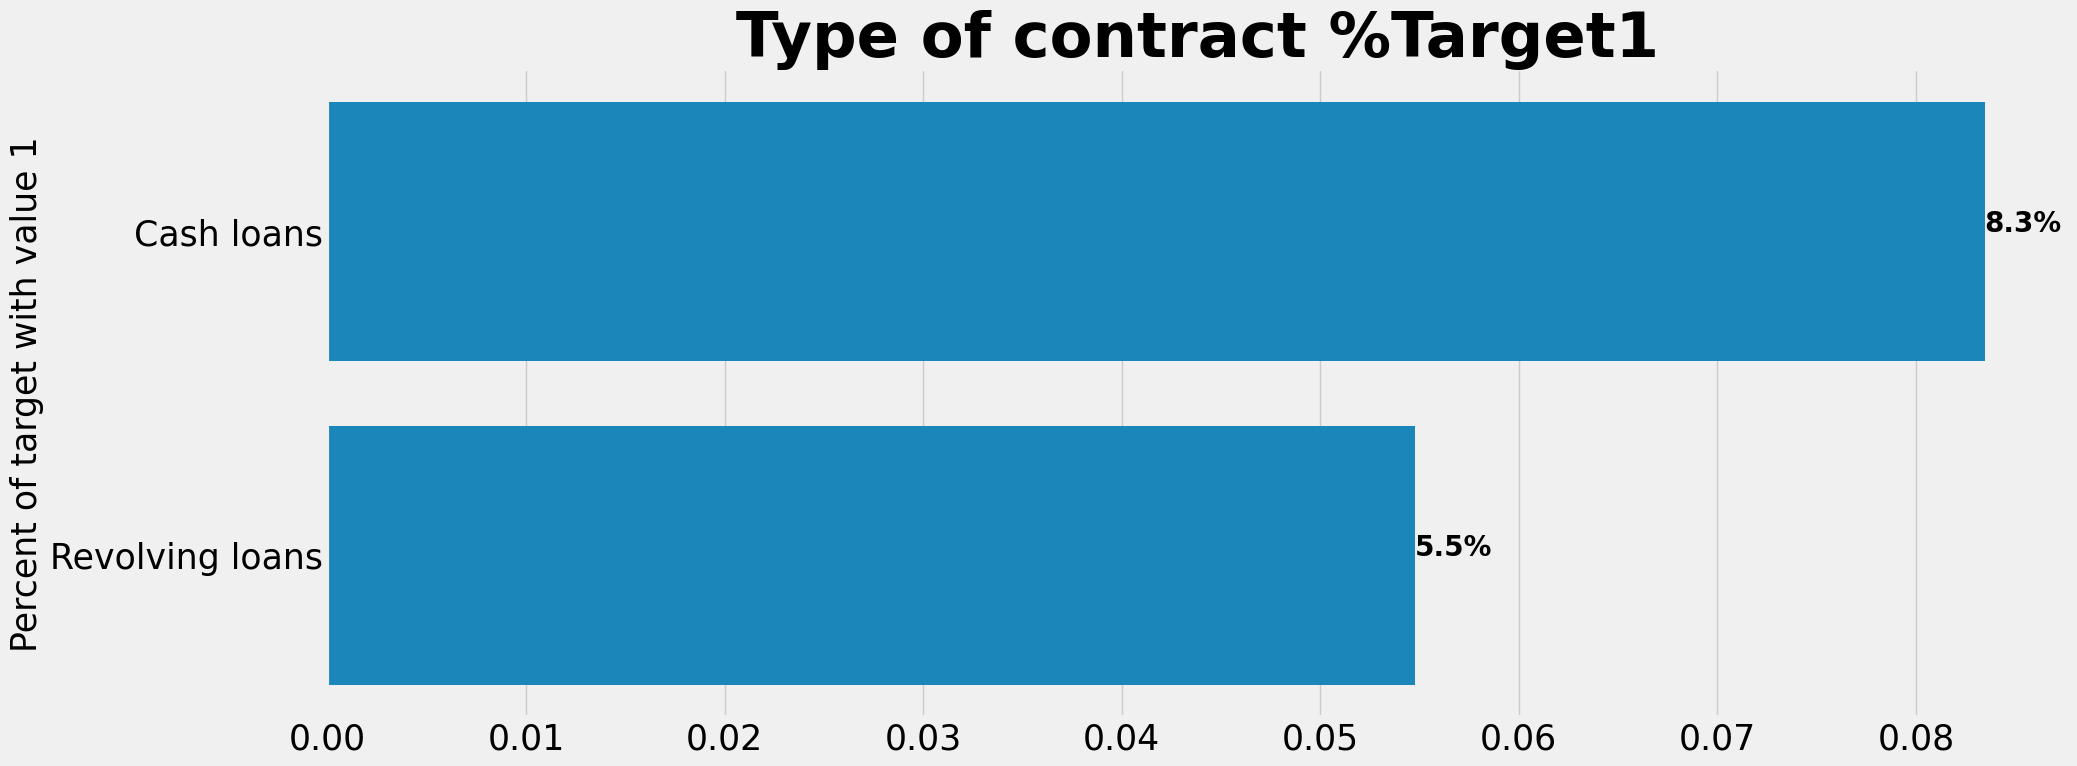

In [ ]:
#NAME_CONTRACT_TYPE
plot_stat(application_train, 'NAME_CONTRACT_TYPE',"Type of contract")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_CONTRACT_TYPE',"Type of contract %Target1")

Revolving loans represent only a small fraction (10%) of the total number of loans; at the same time, less revolving loans, relative to their frequency, are not repaid so the revolving loans seem to be less risky

**Client gender -** M/F customer distribution, but also the percentage of loans (by customer gender) with TARGET 1 value (loan not returned).

                                   -------------------------------------------------------


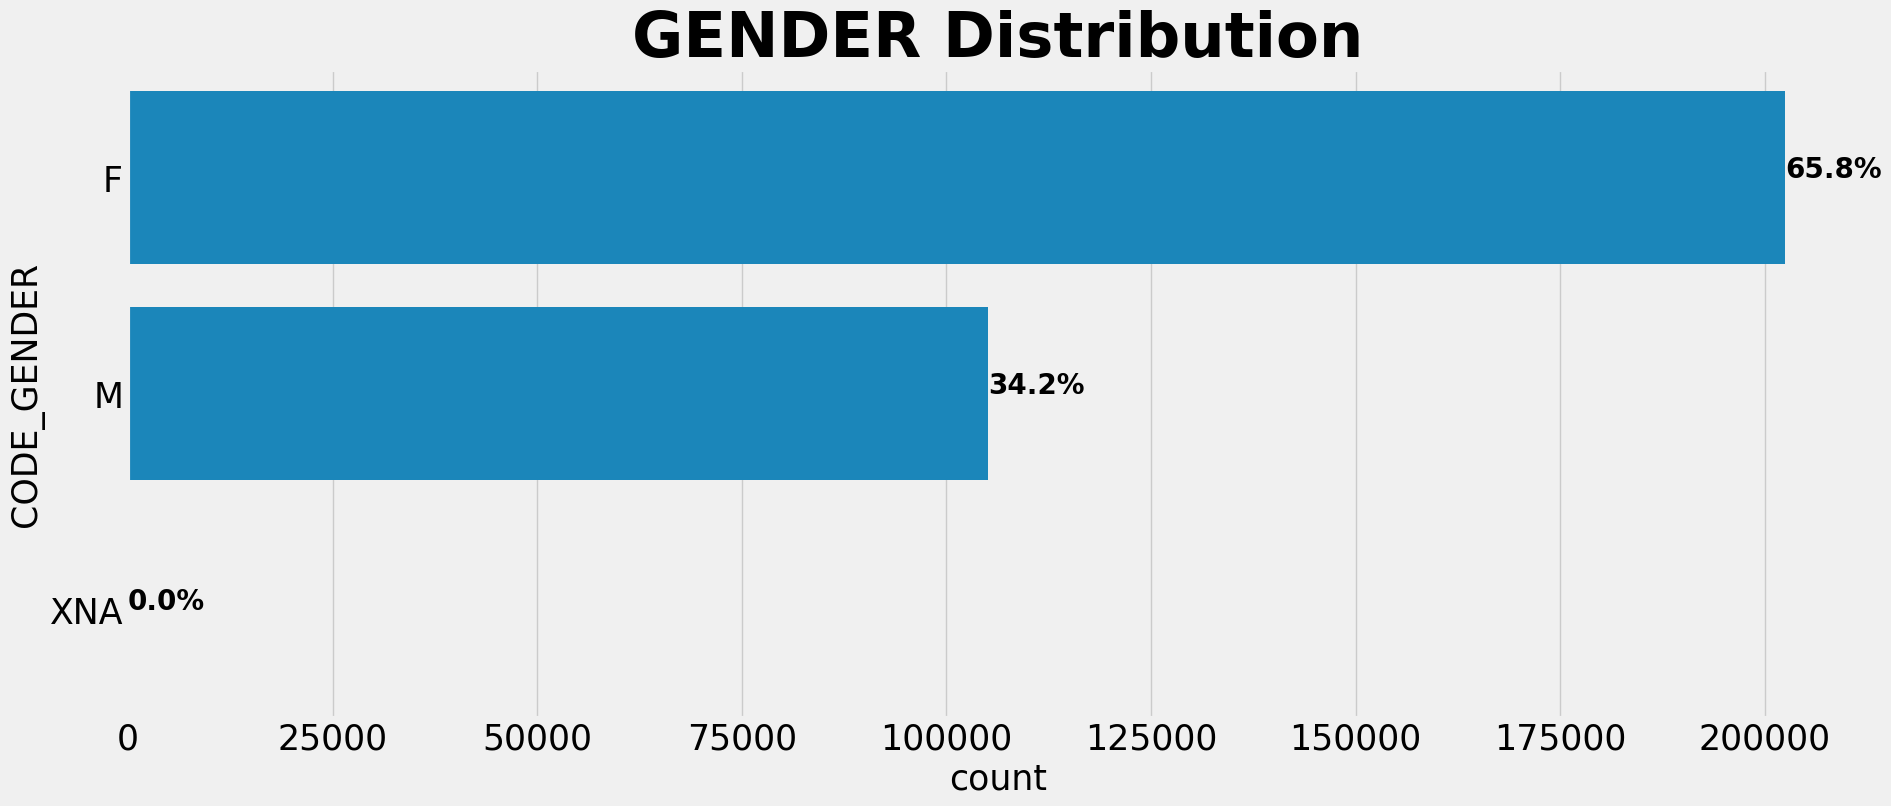

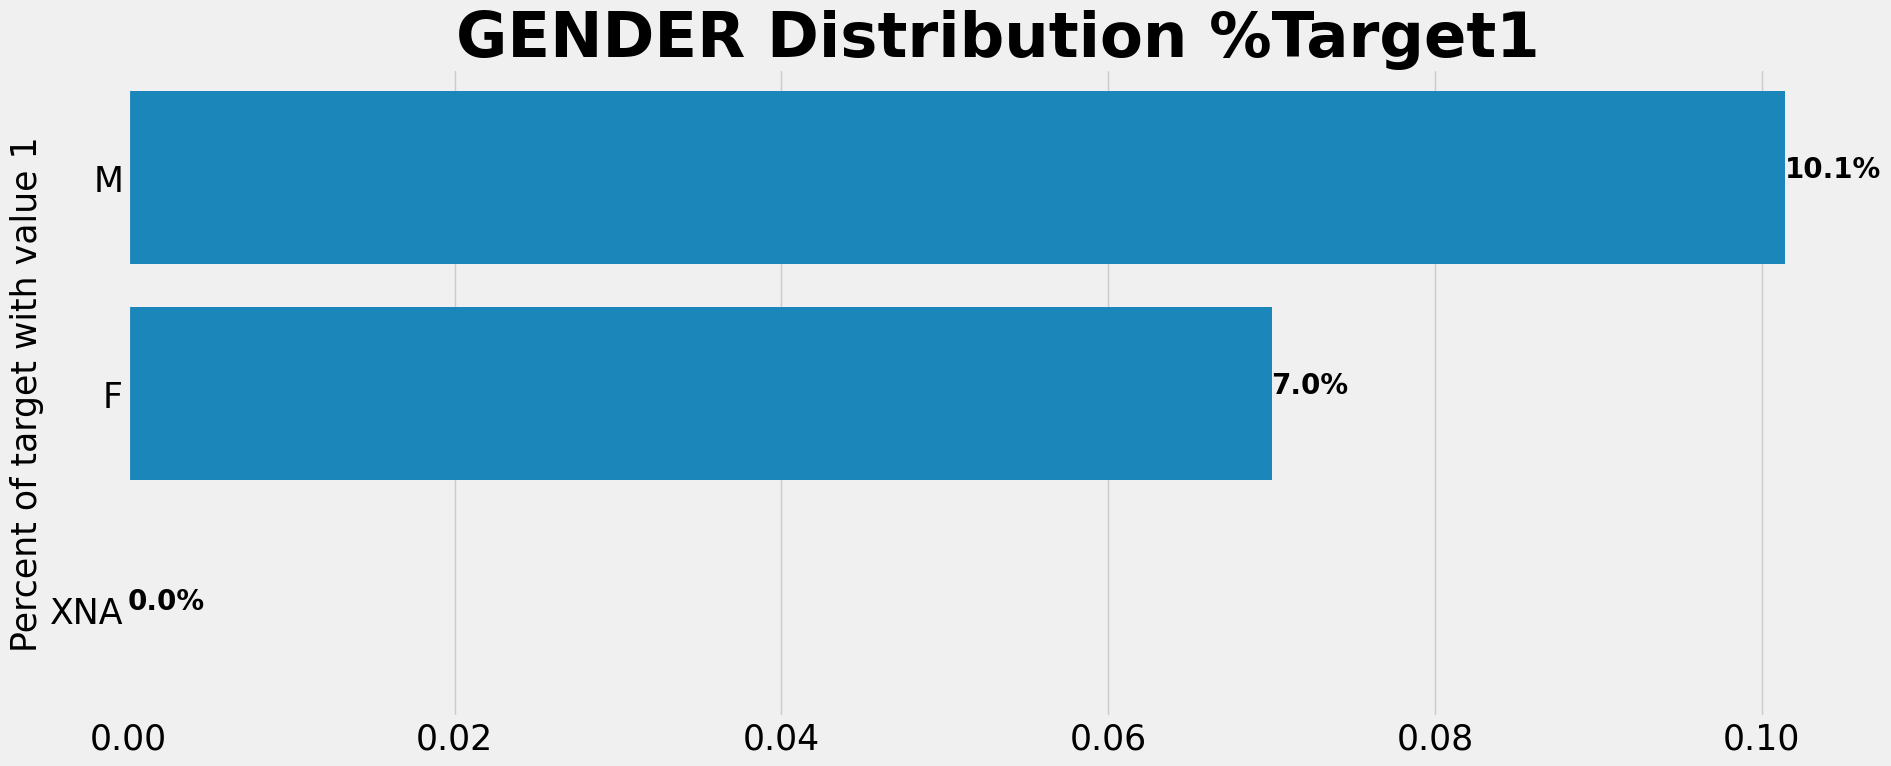

In [ ]:
#CODE_GENDER
plot_stat(application_train, 'CODE_GENDER',"GENDER Distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'CODE_GENDER',"GENDER Distribution %Target1")

The number of female customers is almost double the number of male customers. As for the percentage of paying default loans, men are more likely to default (10% of them) than women (7% of them).

**Flag own car -** Distribution d'un impact possible entre les clients propriétaire d'un véhicule et ceux qui ne le sont pas…

                                   -------------------------------------------------------


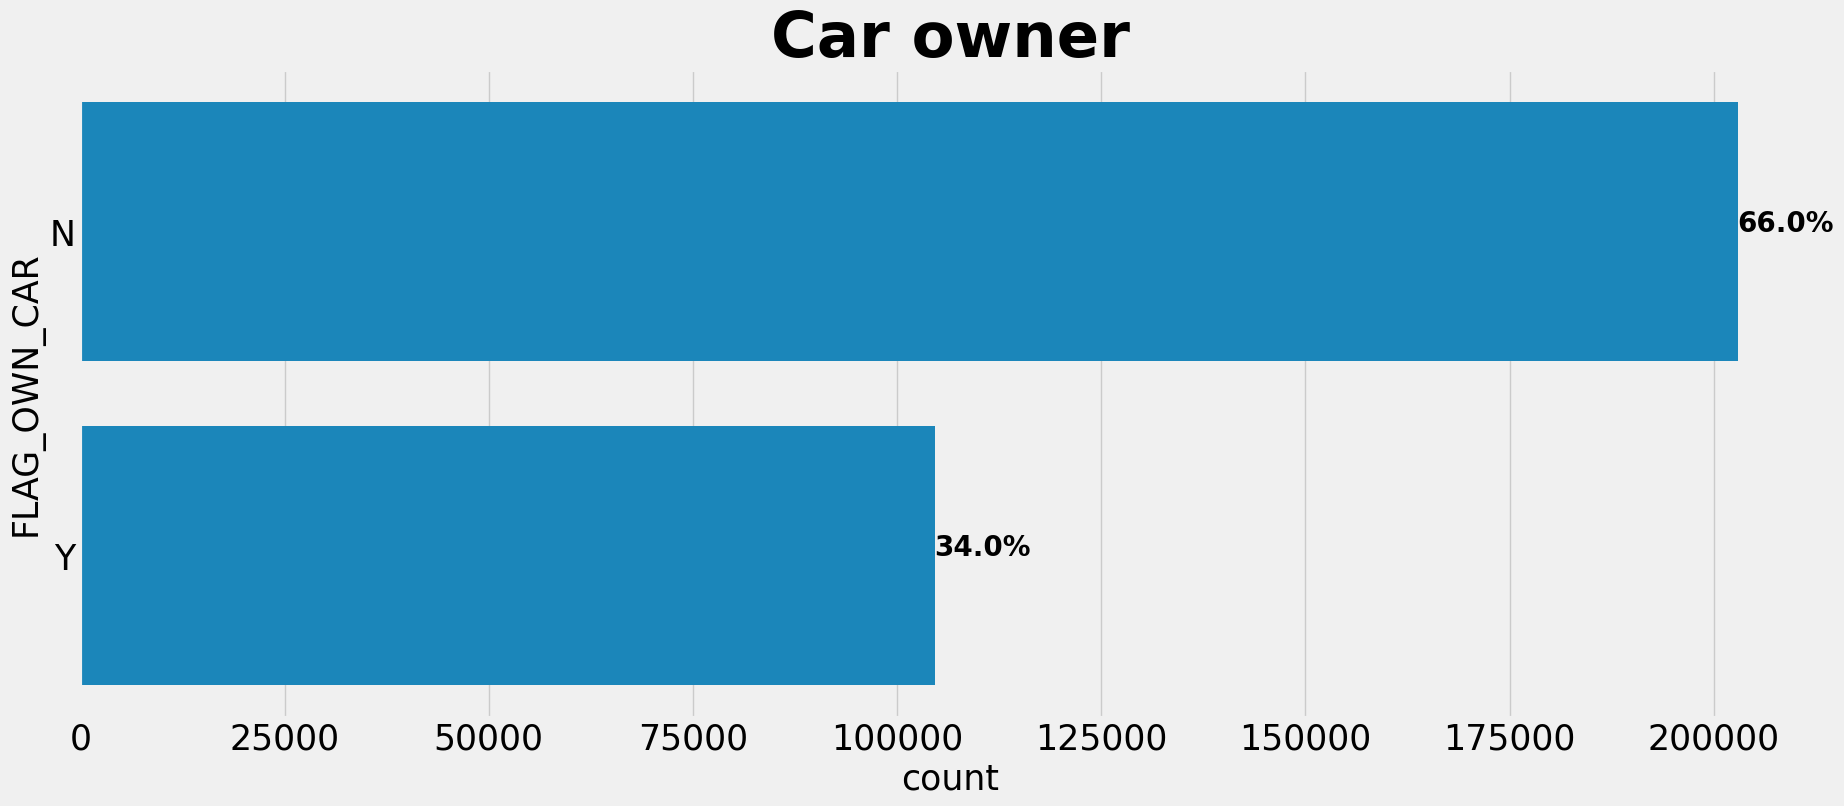

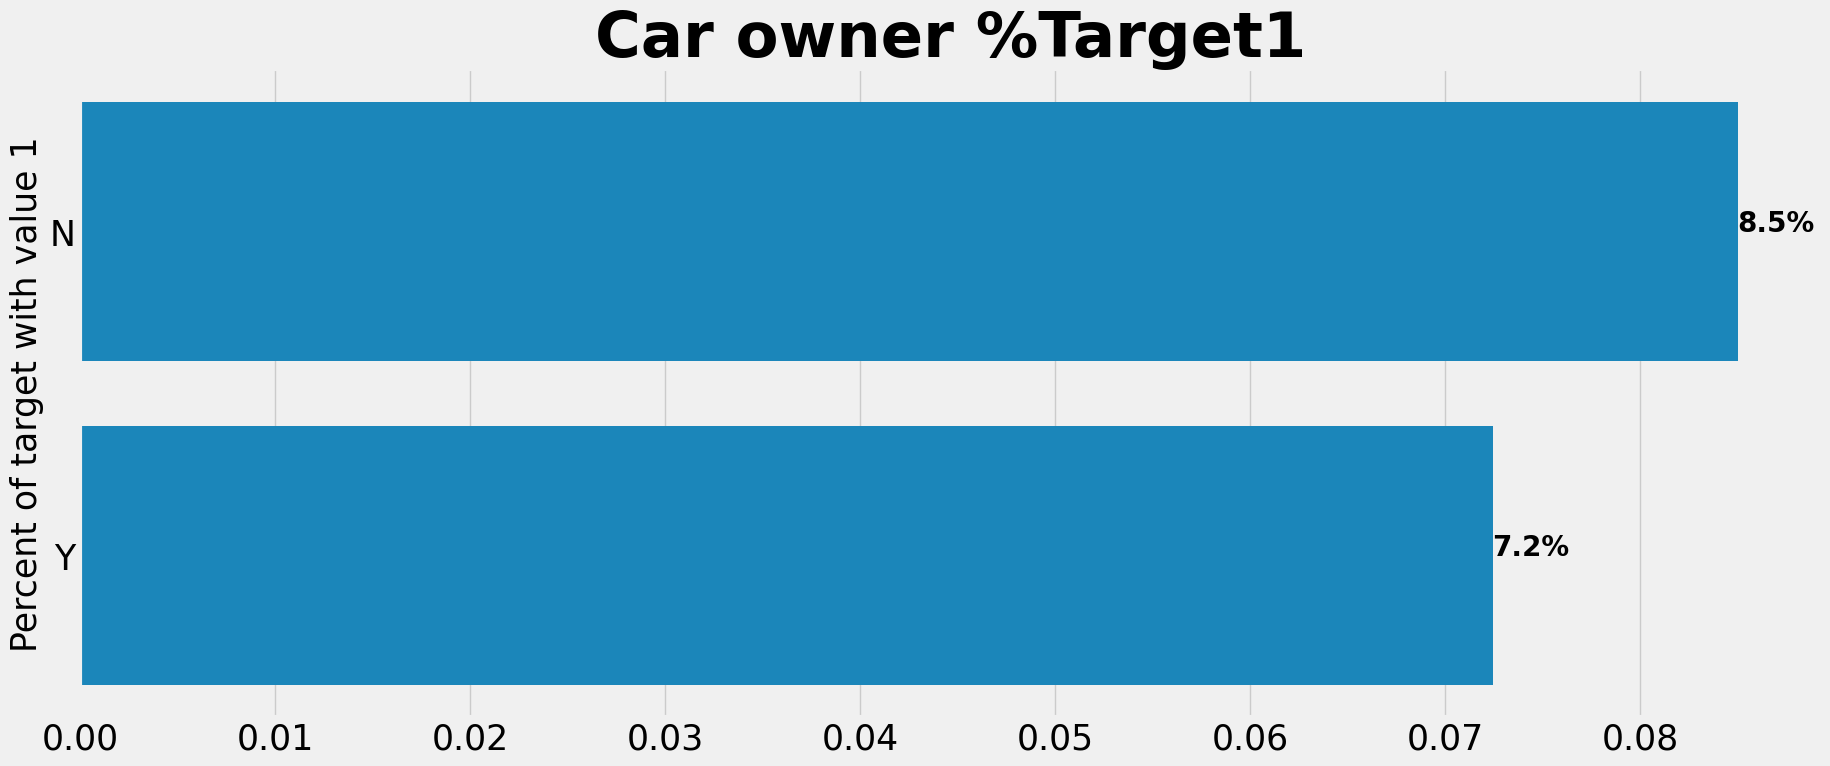

In [ ]:
#FLAG_OWN_CAR
plot_stat(application_train, 'FLAG_OWN_CAR',"Car owner")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'FLAG_OWN_CAR',"Car owner %Target1")

Both categories (owner and non-owner) have non-repayment rates of around 8%.

                                   -------------------------------------------------------


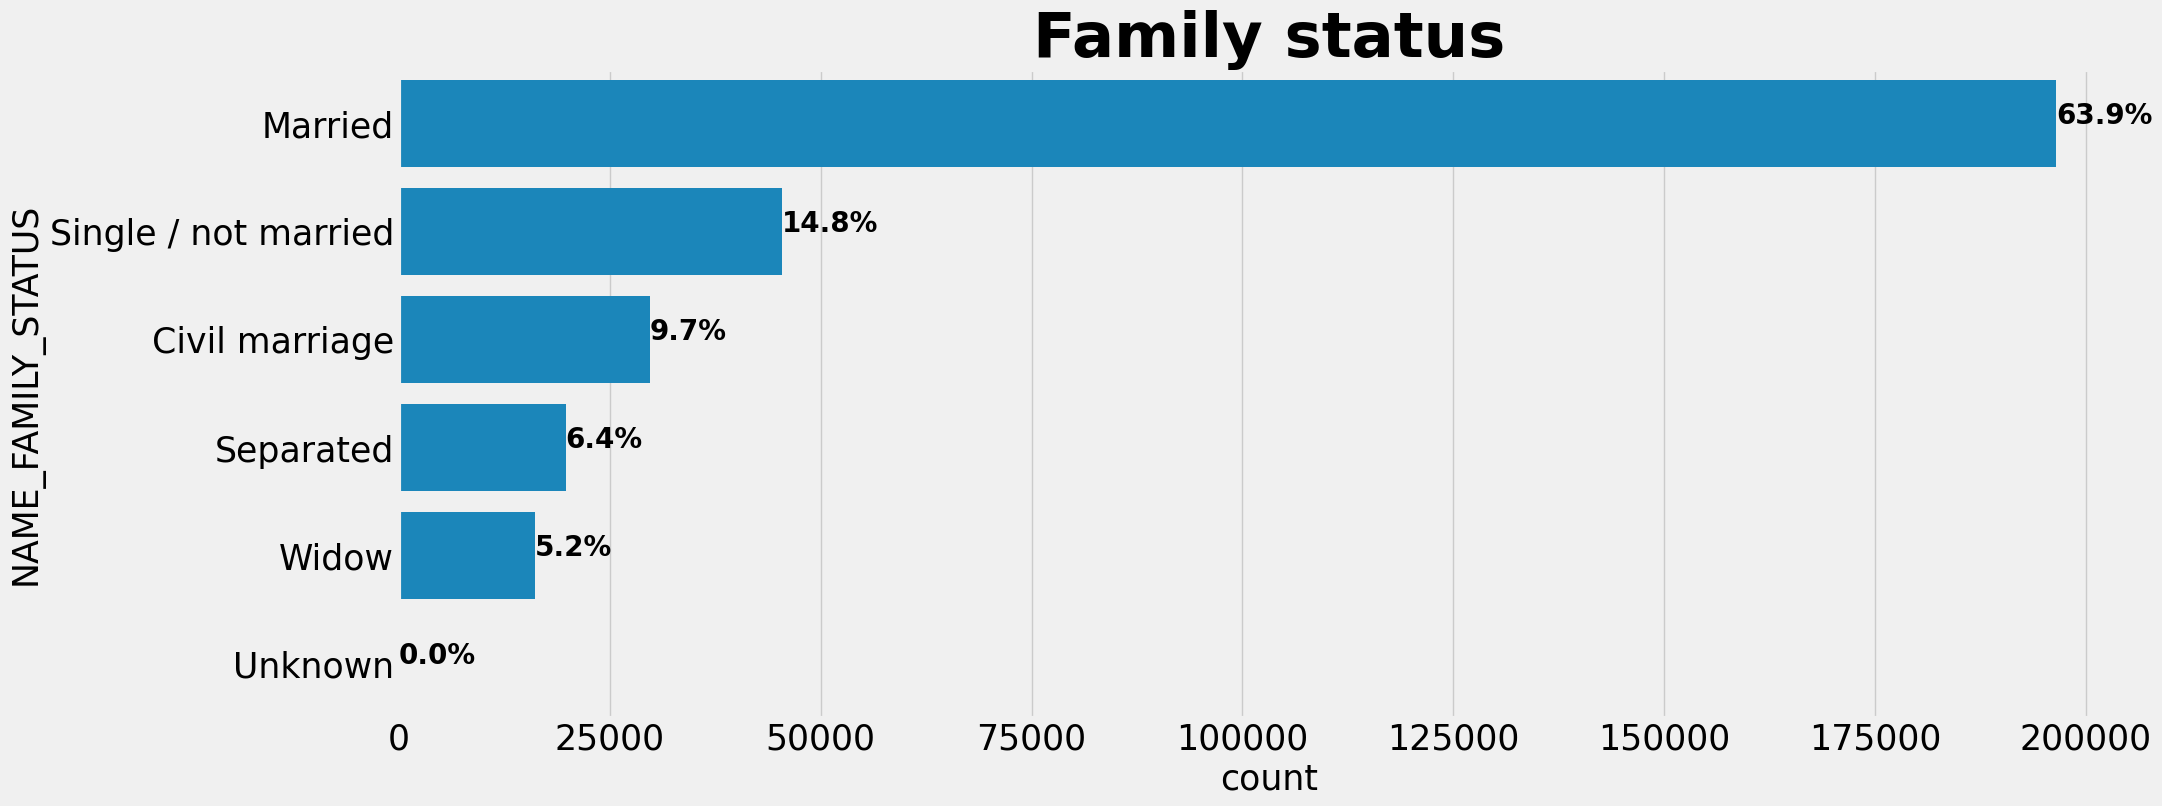

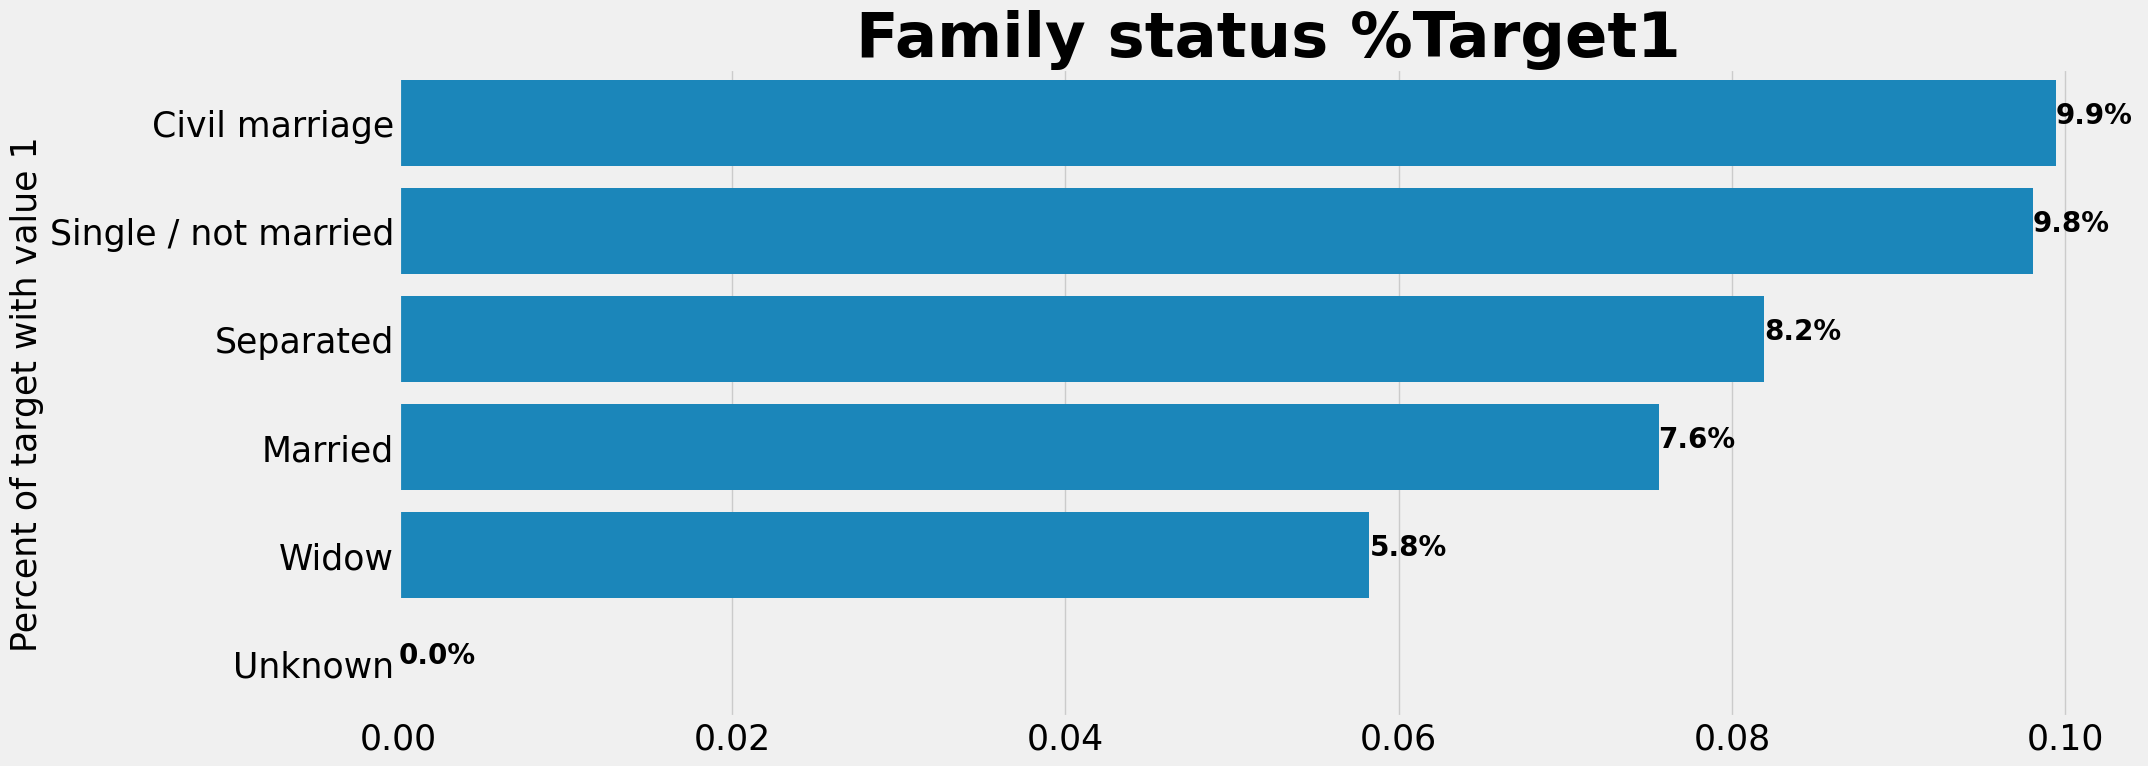

In [ ]:
#NAME_FAMILY_STATUS
plot_stat(application_train, 'NAME_FAMILY_STATUS',"Family status")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_FAMILY_STATUS',"Family status %Target1")

Most customers are married, followed by single/unmarried and civil marriage (PACS in France).

In terms of percentage of loan non-repayment, civil marriage has the highest percentage of non-repayment (10%), widowhood the lowest (with the exception of unknown).

                                   -------------------------------------------------------


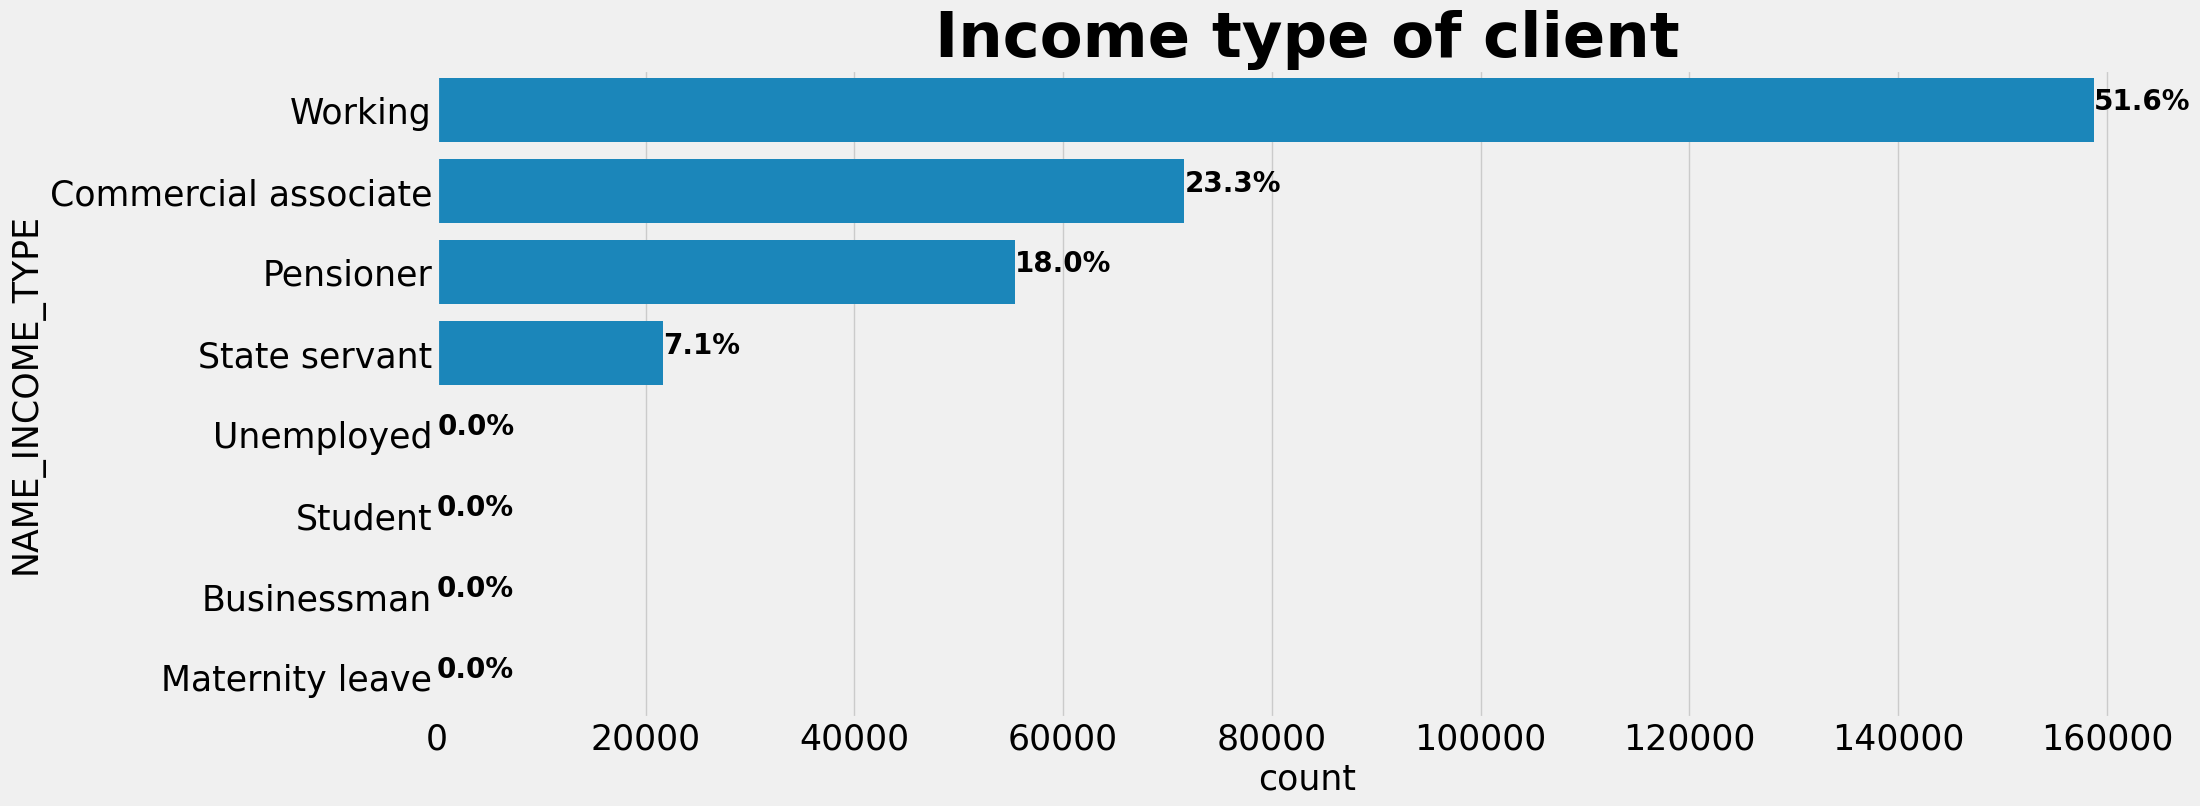

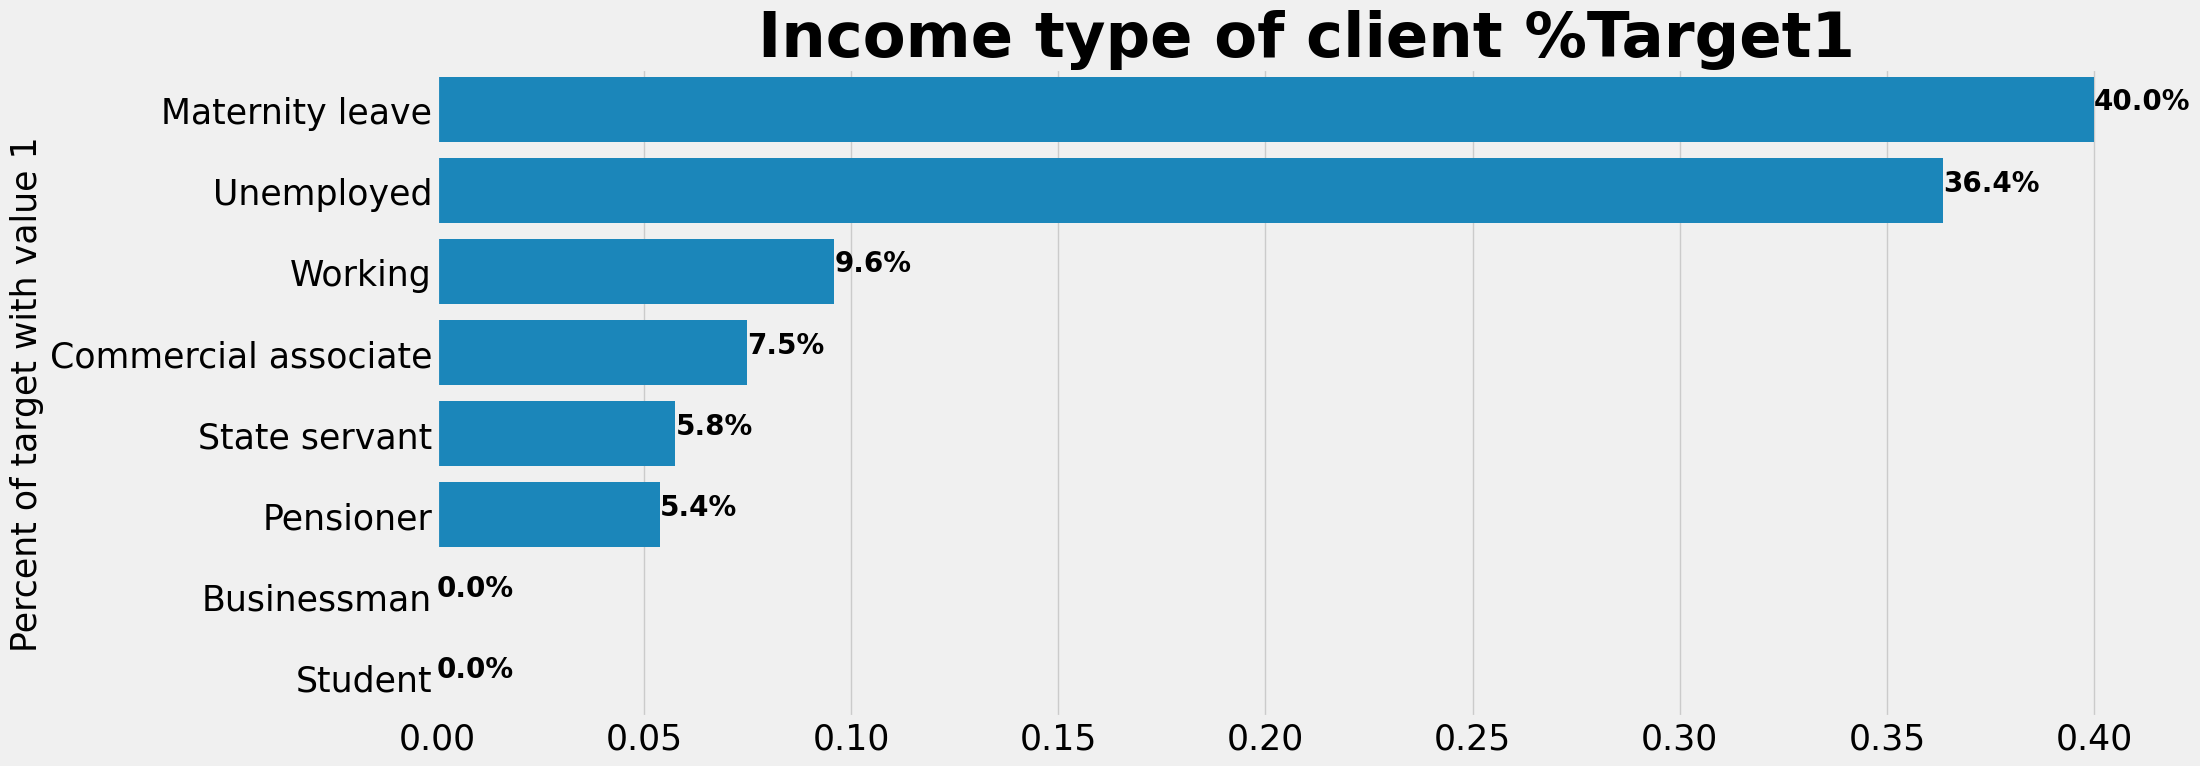

In [ ]:
#NAME_INCOME_TYPE
plot_stat(application_train, 'NAME_INCOME_TYPE',"Income type of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_INCOME_TYPE',"Income type of client %Target1")

Most loan applicants are working income, followed by a business associate, a pensioner and a civil servant.

Applicants with the income type Maternity leave have a ratio of almost 40% of loans not repaid (but the sample is very small: 5 individuals), followed by the unemployed (37%). Other income types are below the 10% average for not repaying loans.

                                   -------------------------------------------------------


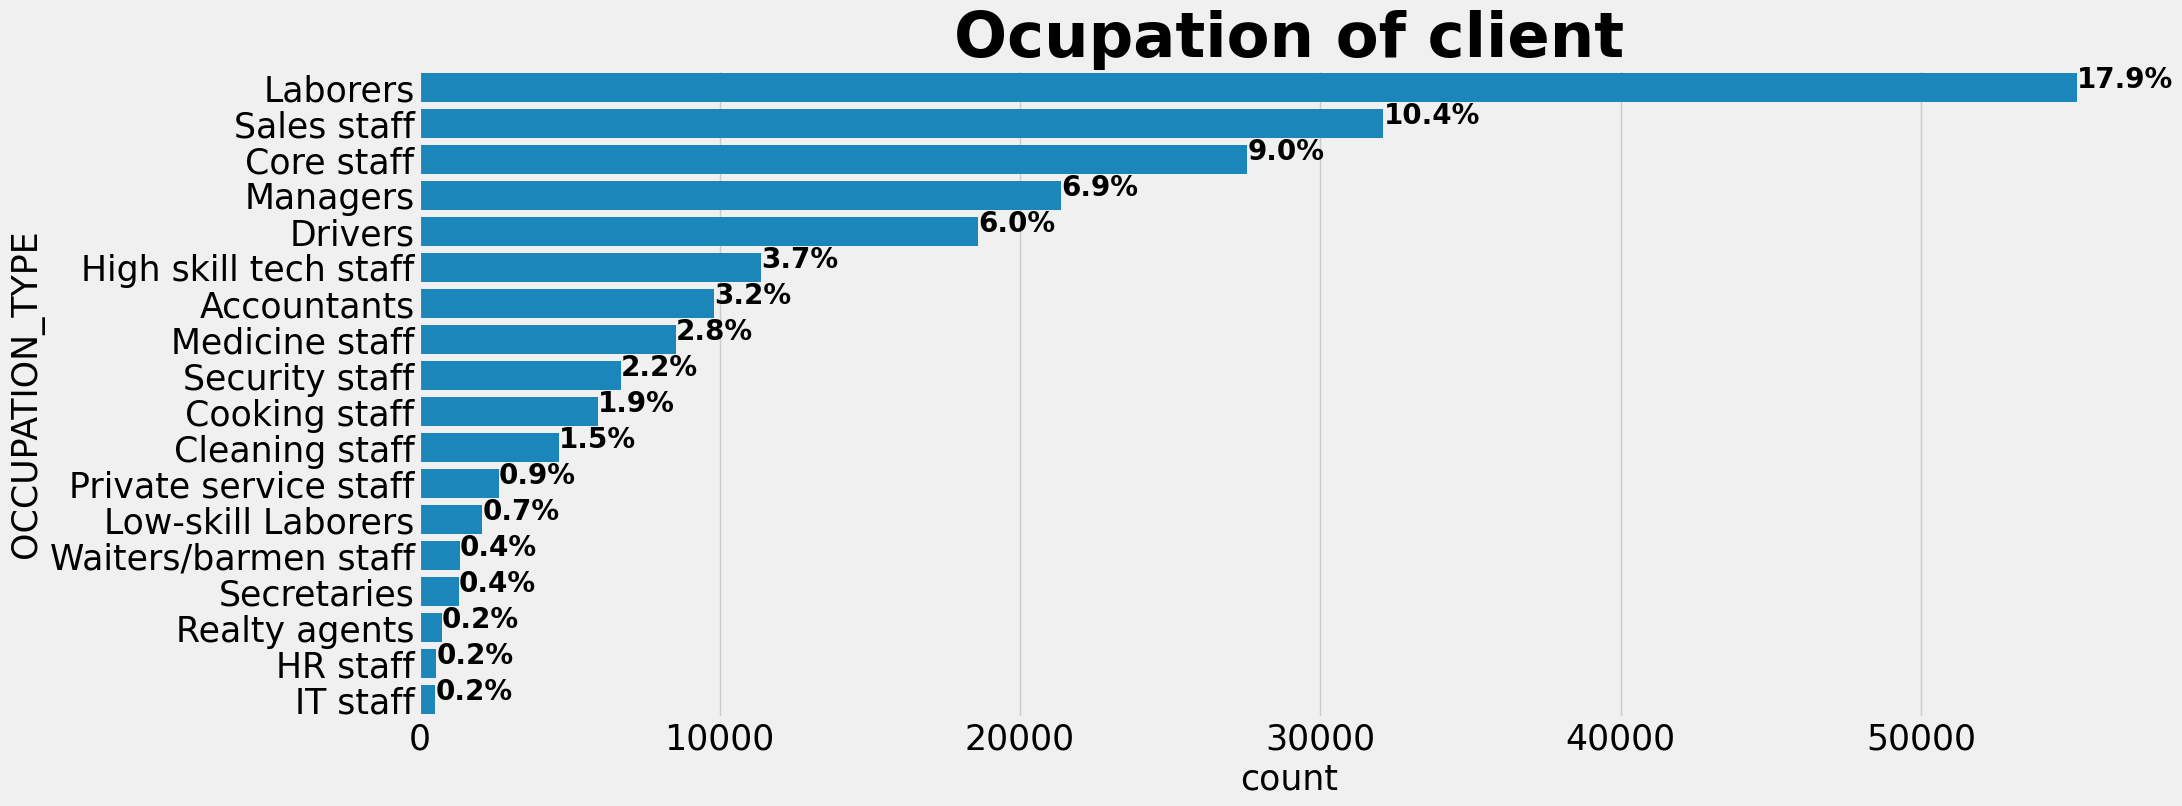

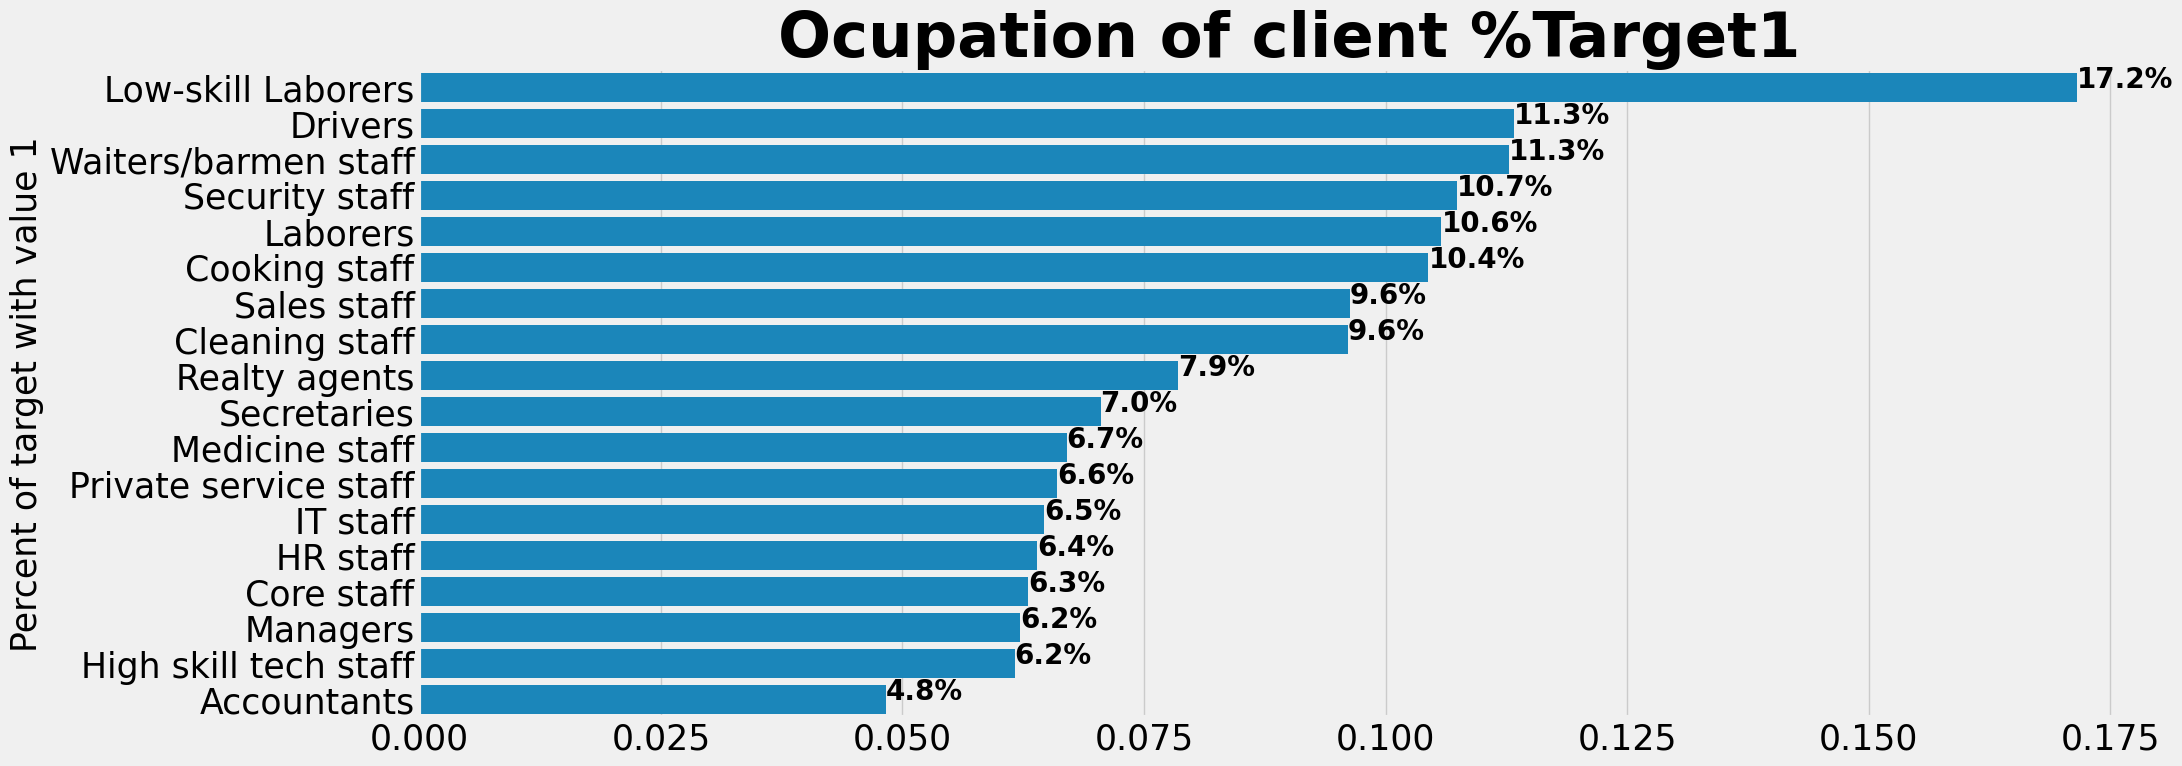

In [ ]:
#OCCUPATION_TYPE
plot_stat(application_train, 'OCCUPATION_TYPE',"Ocupation of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'OCCUPATION_TYPE',"Ocupation of client %Target1")

Most loans are taken out by laborers, followed by sales staff. IT staff take out the lowest amount of loans.

The category with the highest percentage of unpaid loans is low-skilled laborers (over 17%), followed by drivers and waiters/bartenders, security staff, laborers and cooking staff.

                                   -------------------------------------------------------


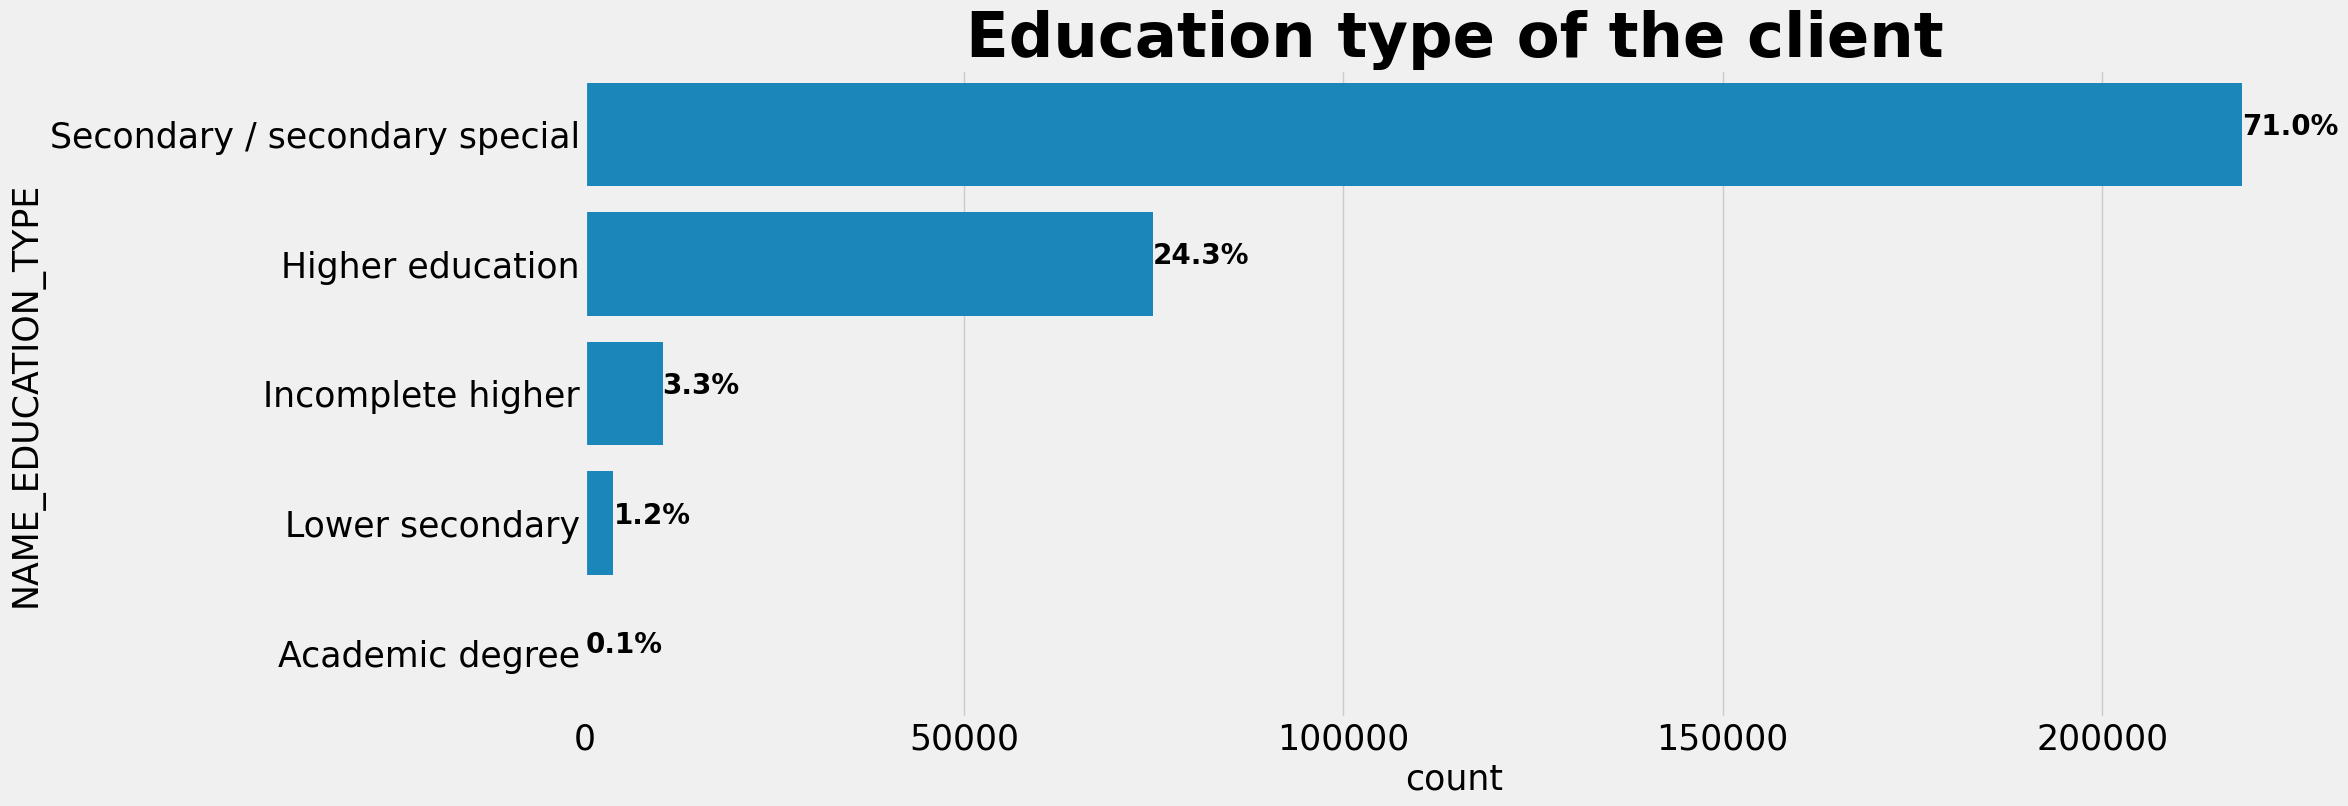

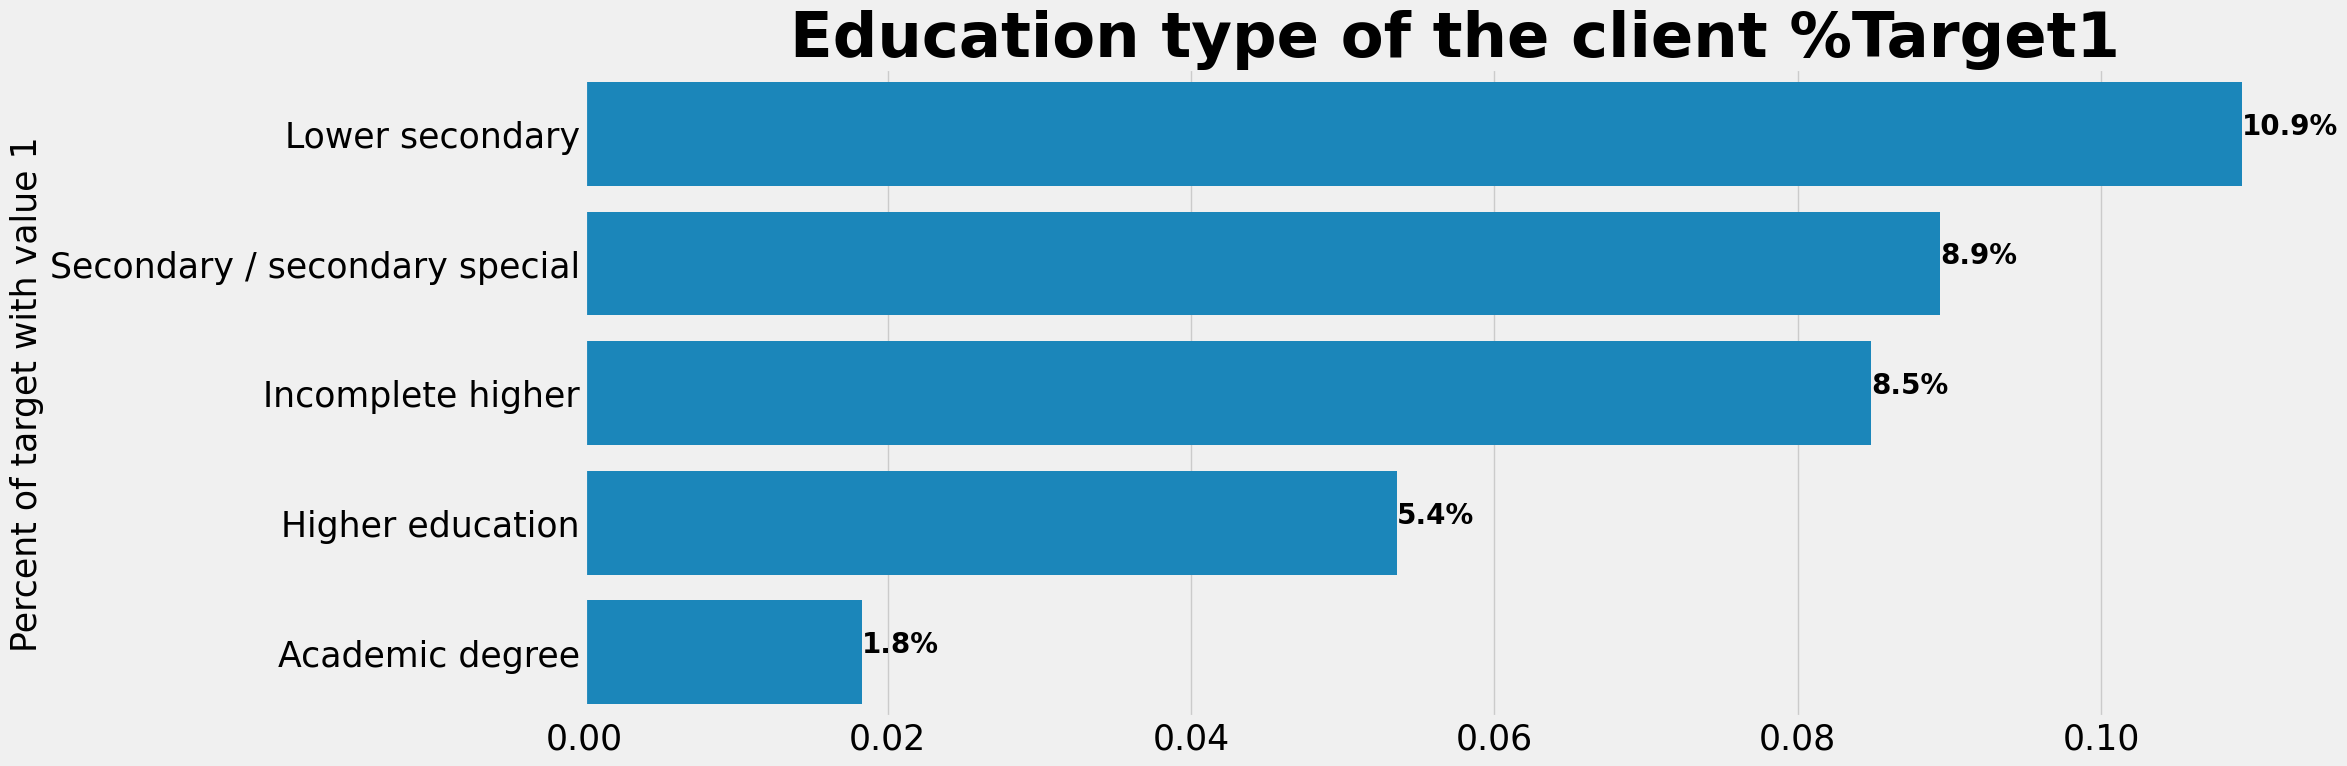

In [ ]:
#NAME_EDUCATION_TYPE
plot_stat(application_train, 'NAME_EDUCATION_TYPE',"Education type of the client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_EDUCATION_TYPE',"Education type of the client %Target1")

The majority of customers have secondary education, followed by those with higher education. A very small number of borrowers have an academic degree.

The junior high school category, although rare, has the highest rate of loan non-repayment (11%). Those with a university degree have a non-repayment rate of less than 2%.

                                   -------------------------------------------------------


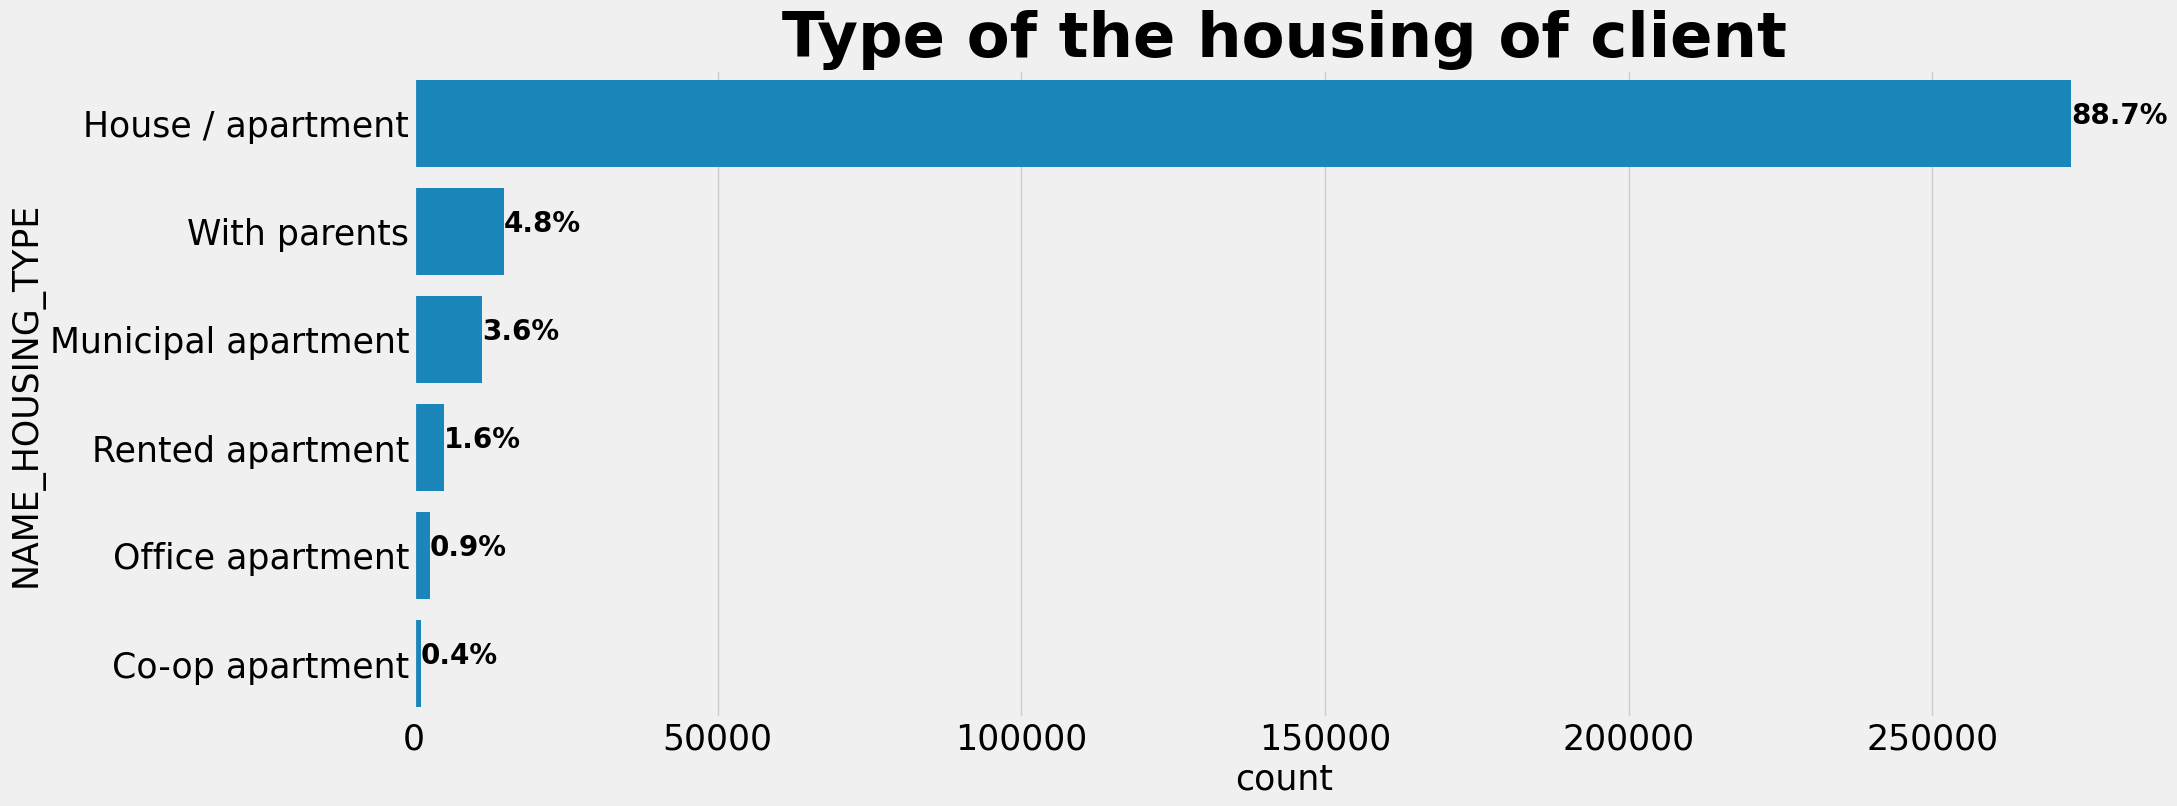

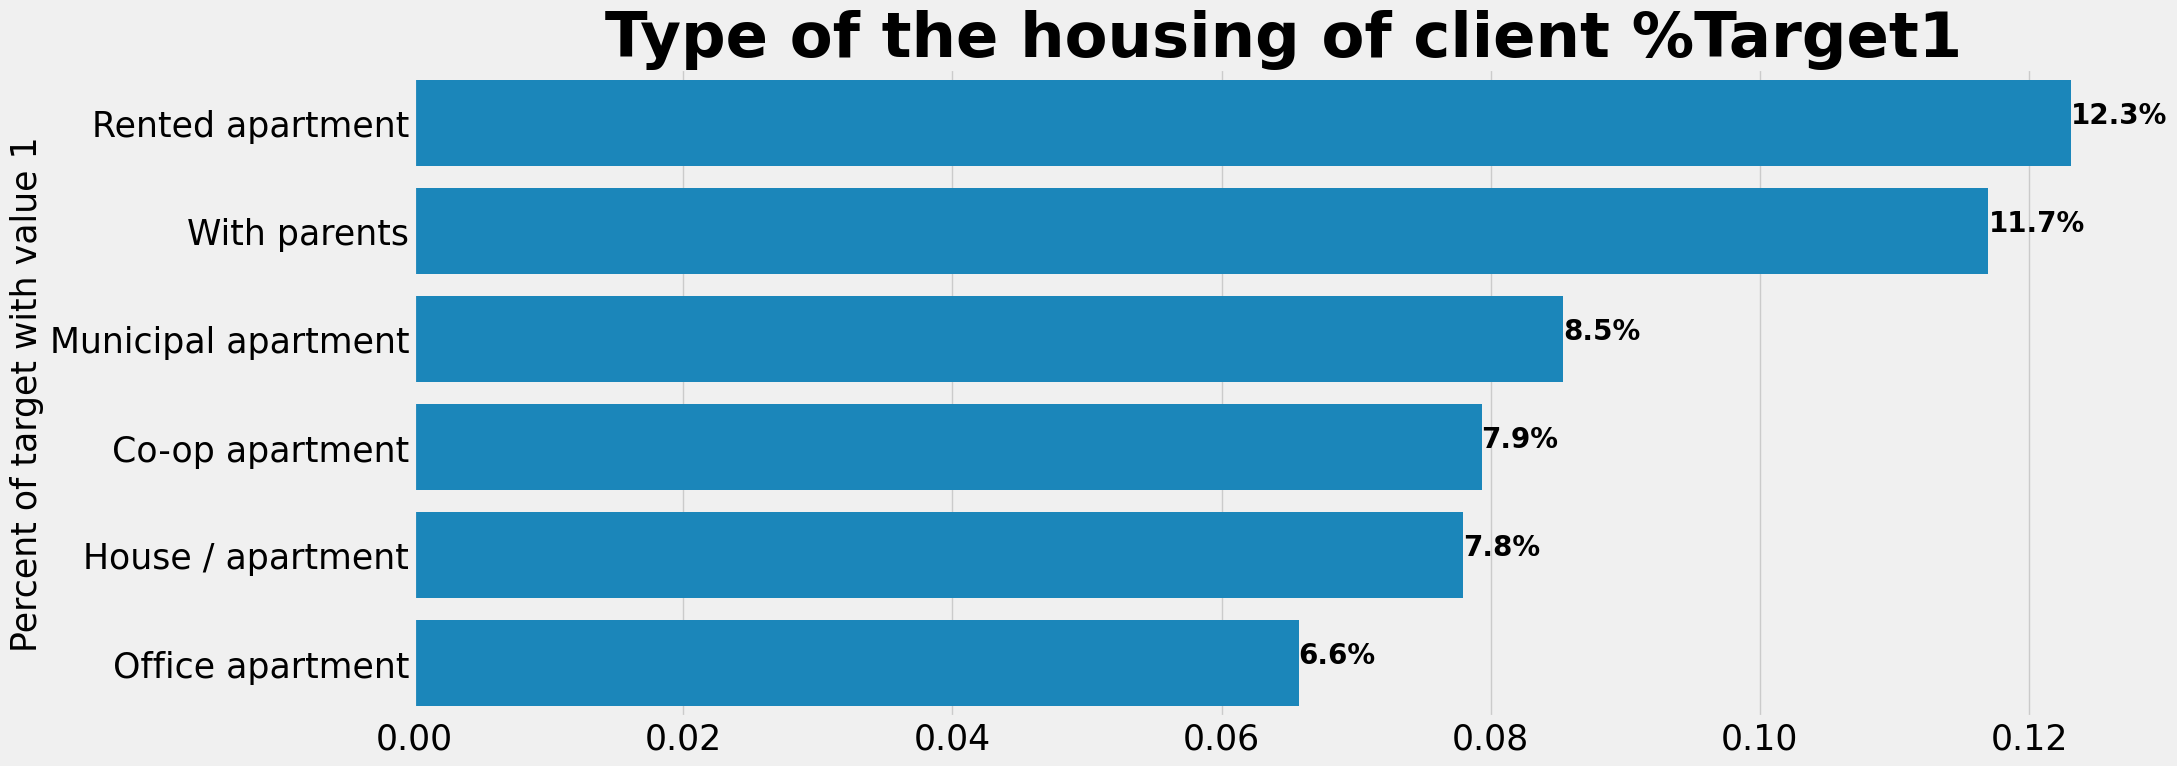

In [ ]:
#NAME_HOUSING_TYPE
plot_stat(application_train, 'NAME_HOUSING_TYPE',"Type of the housing of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_HOUSING_TYPE',"Type of the housing of client %Target1")

Over 250,000 credit applicants live in houses or apartments. The following categories, which account for a small percentage, represent a less “independent” population (living with parents, etc.).

In these categories, apartment renters (who do not own their main residence), as well as those living with their parents, have a non-repayment rate of over 10%.

### Correlations
The analysis can continue with a step to process the correlations between the characteristics and the Target. The idea is to calculate the Pearson correlation coefficient between each variable and the Target. This step provides an overview of the possible relationships between the variables.

#### General

In [ ]:
#Display correlations
application_train_correlations = application_train.corr(numeric_only=True)['TARGET'].sort_values()
print('Most Positive Correlations:\n', application_train_correlations.tail(15))
print("--------------------------")
print('Most Negative Correlations:\n', application_train_correlations.head(15))
del(application_train_correlations)

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE      0.032
LIVE_CITY_NOT_WORK_CITY       0.033
OWN_CAR_AGE                   0.038
DAYS_REGISTRATION             0.042
FLAG_DOCUMENT_3               0.044
REG_CITY_NOT_LIVE_CITY        0.044
FLAG_EMP_PHONE                0.046
REG_CITY_NOT_WORK_CITY        0.051
DAYS_ID_PUBLISH               0.051
DAYS_LAST_PHONE_CHANGE        0.055
REGION_RATING_CLIENT          0.059
REGION_RATING_CLIENT_W_CITY   0.061
DAYS_EMPLOYED                 0.075
DAYS_BIRTH                    0.078
TARGET                        1.000
Name: TARGET, dtype: float64
--------------------------
Most Negative Correlations:
 EXT_SOURCE_3                 -0.179
EXT_SOURCE_2                 -0.160
EXT_SOURCE_1                 -0.155
DAYS_EMPLOYED_OUTLIERS       -0.046
FLOORSMAX_AVG                -0.044
FLOORSMAX_MEDI               -0.044
FLOORSMAX_MODE               -0.043
AMT_GOODS_PRICE              -0.040
REGION_POPULATION_RELATIVE   -0.037
ELEVATORS_AVG         

Note that the strongest correlation is for the 'DAYS_BIRTH' variable.This being the case, to make it easier to understand and rediscover the logic seen in the preamble, days expressed as negative values can be treated as absolute values. In this case, Person's coef. will be negative, reflecting the fact that an older customer is less likely to default on his loan (this may seem logical, but it's not absurd).

In [ ]:
#Find the correlation of the positive days since birth and target
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

-0.07823930830982694

In terms of age distribution, it can only be used to visualise the absence of outliers, following what has been done upstream on the negative initial values. To visualise the effect of age on Target, we can create a graph (KDE) coloured by the TARGET 0 and 1 values.

(<matplotlib.legend.Legend at 0x7d14ca12a8d0>,
 Text(0.5, 0, 'Age(years)'),
 Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Distribution of Ages'))

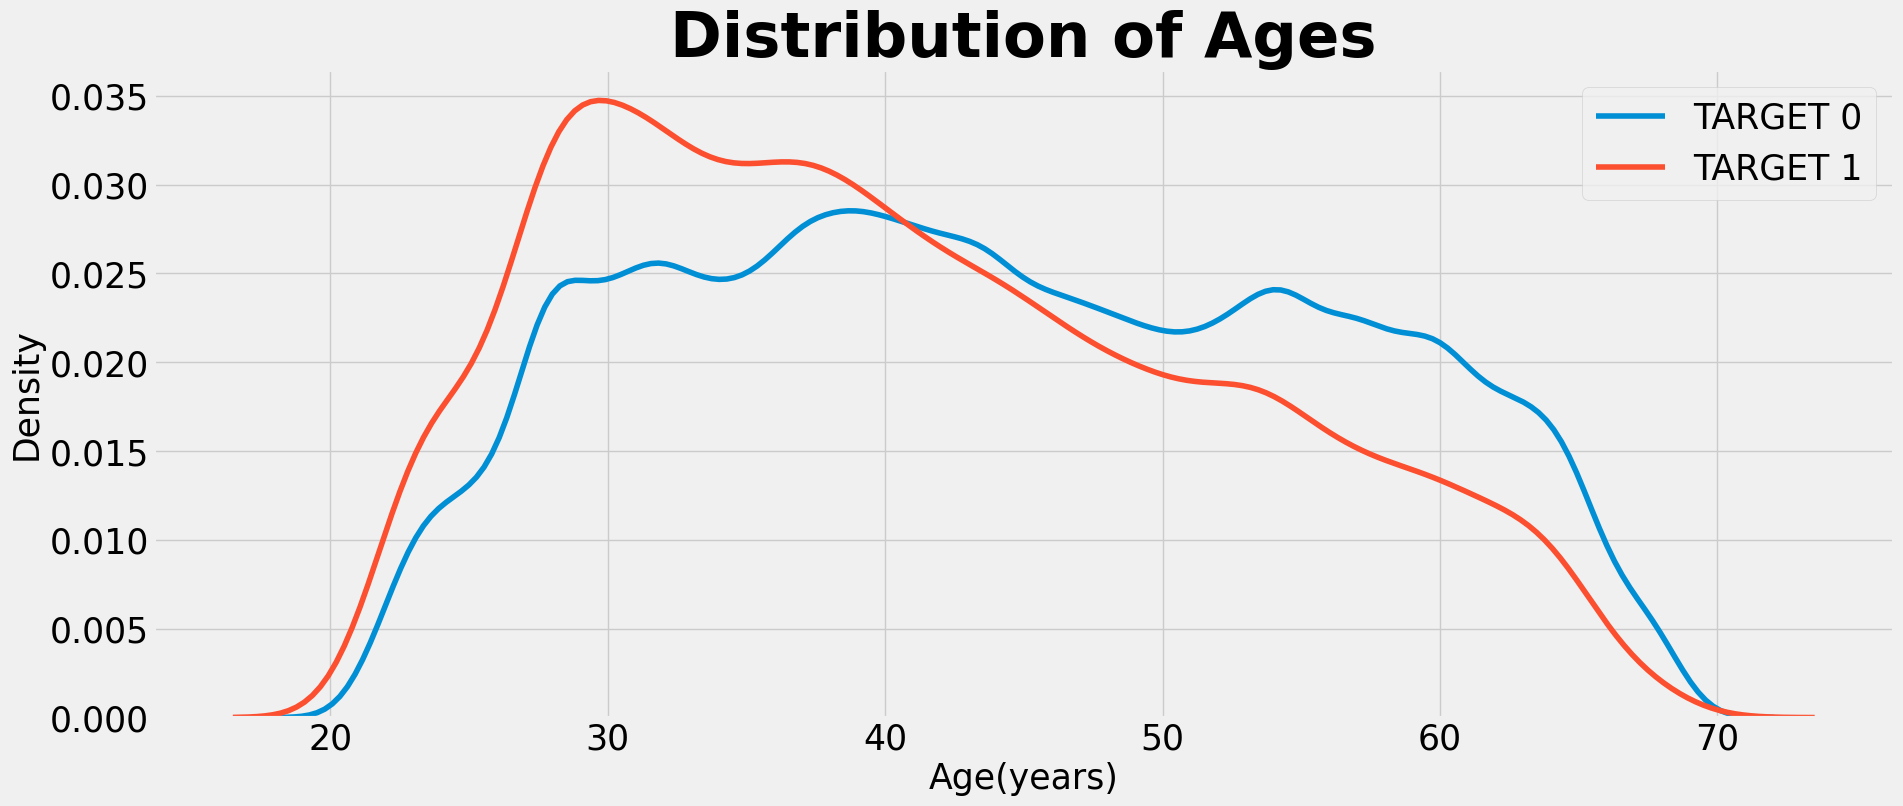

In [ ]:
plt.figure(figsize = (20, 8))
sns.kdeplot(application_train[application_train['TARGET'] == 0]['DAYS_BIRTH'] / 365, label = 'TARGET 0')
sns.kdeplot(application_train[application_train['TARGET'] == 1]['DAYS_BIRTH'] / 365, label = 'TARGET 1')
plt.legend(), plt.xlabel('Age(years)'), plt.ylabel('Density'), plt.title('Distribution of Ages')

The TARGET 1 target curve slopes towards the younger end of the range. Although this is not a significant correlation (Pearson coefficient -0.07), this variable is likely to be useful in a learning model as it affects the Target.

#### EXT_SOURCE* variables, strongest linear correlations
These 3 variables (EXT_SOURCE) have the strongest negative correlations with Target. According to the documentation, these features represent a "score normalised from an external data source".
It is difficult to understand the exact meaning, but we can speculate that it is a cumulative credit score established using different data sources.

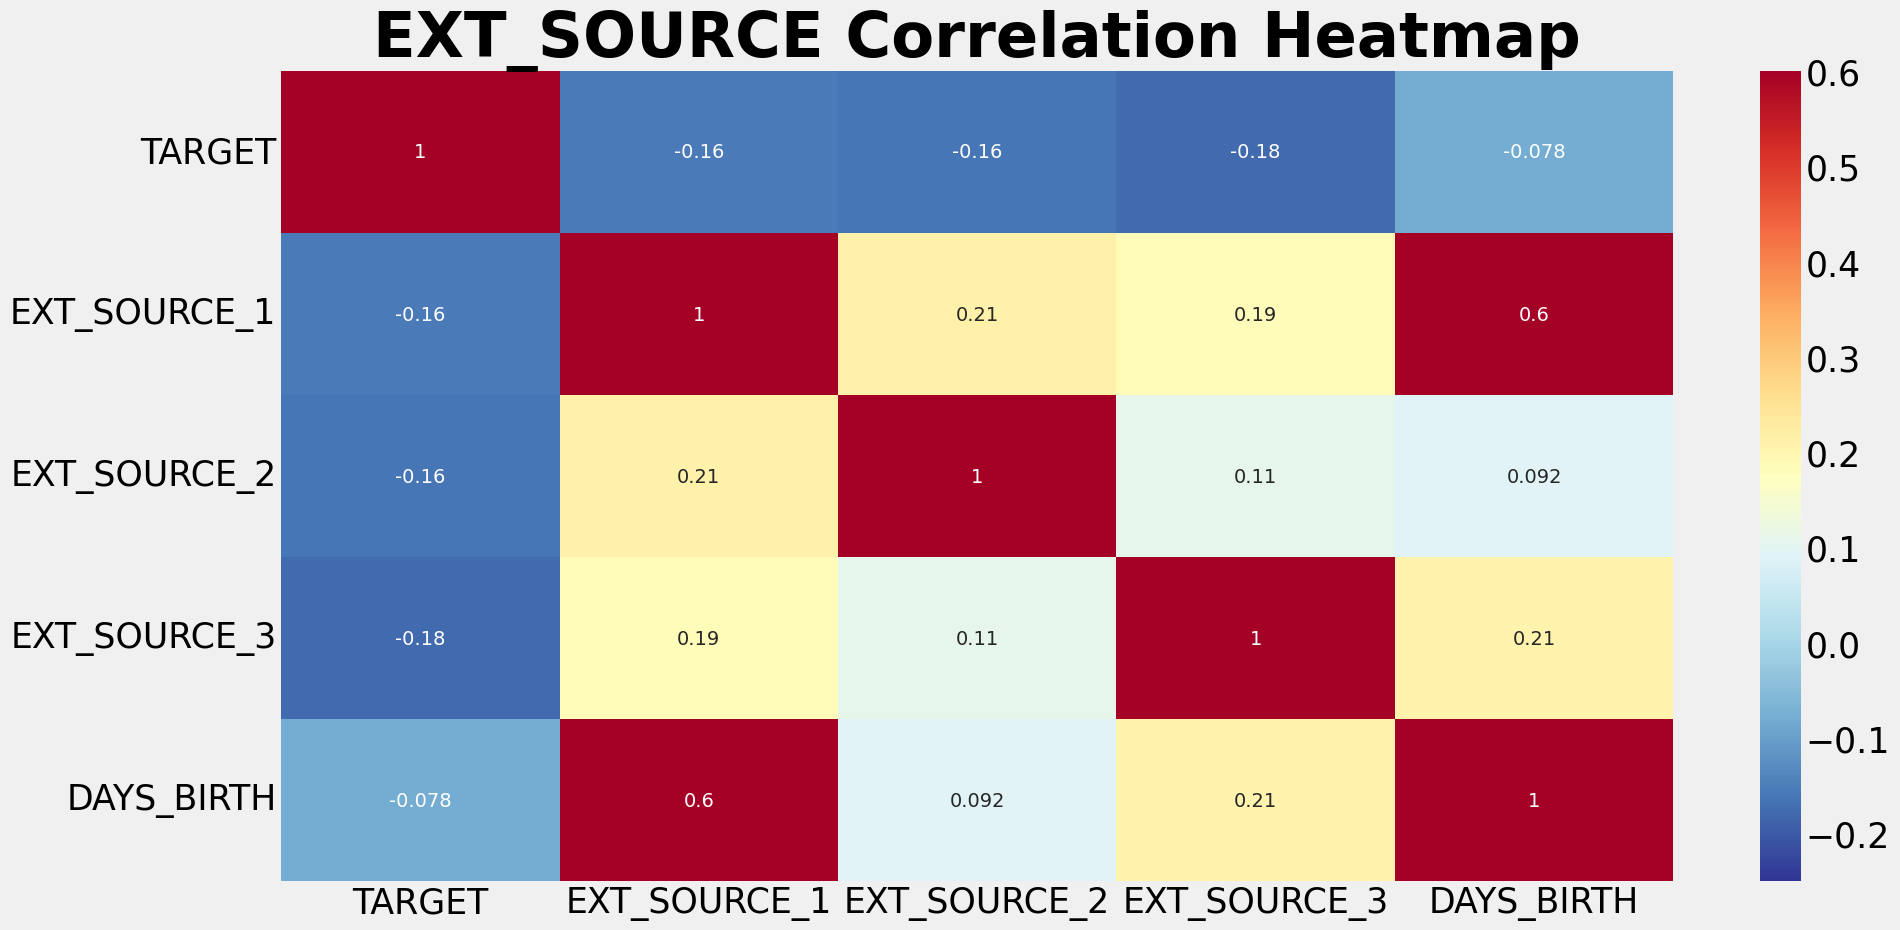

In [ ]:
#Heatmap of correlations
plt.figure(figsize = (20,10))
sns.heatmap(application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')
show()

These external sources are negatively correlated with Target (note that they are negatively correlated, but with very low coefficients). Despite this, we can assume that if the value increases, the customer is more likely to be able to repay the loan. Note that 'DAYS_BIRTH' is correlated with 'EXT_SOURCE_1', perhaps one of the factors in this score is the customer's age.

In [ ]:
#Plot distribution of one feature
def plot_distribution(feature, title):
    plt.figure(figsize=(20,6))

    t0 = application_train.loc[application_train['TARGET'] == 0]
    t1 = application_train.loc[application_train['TARGET'] == 1]


    sns.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()
    show()

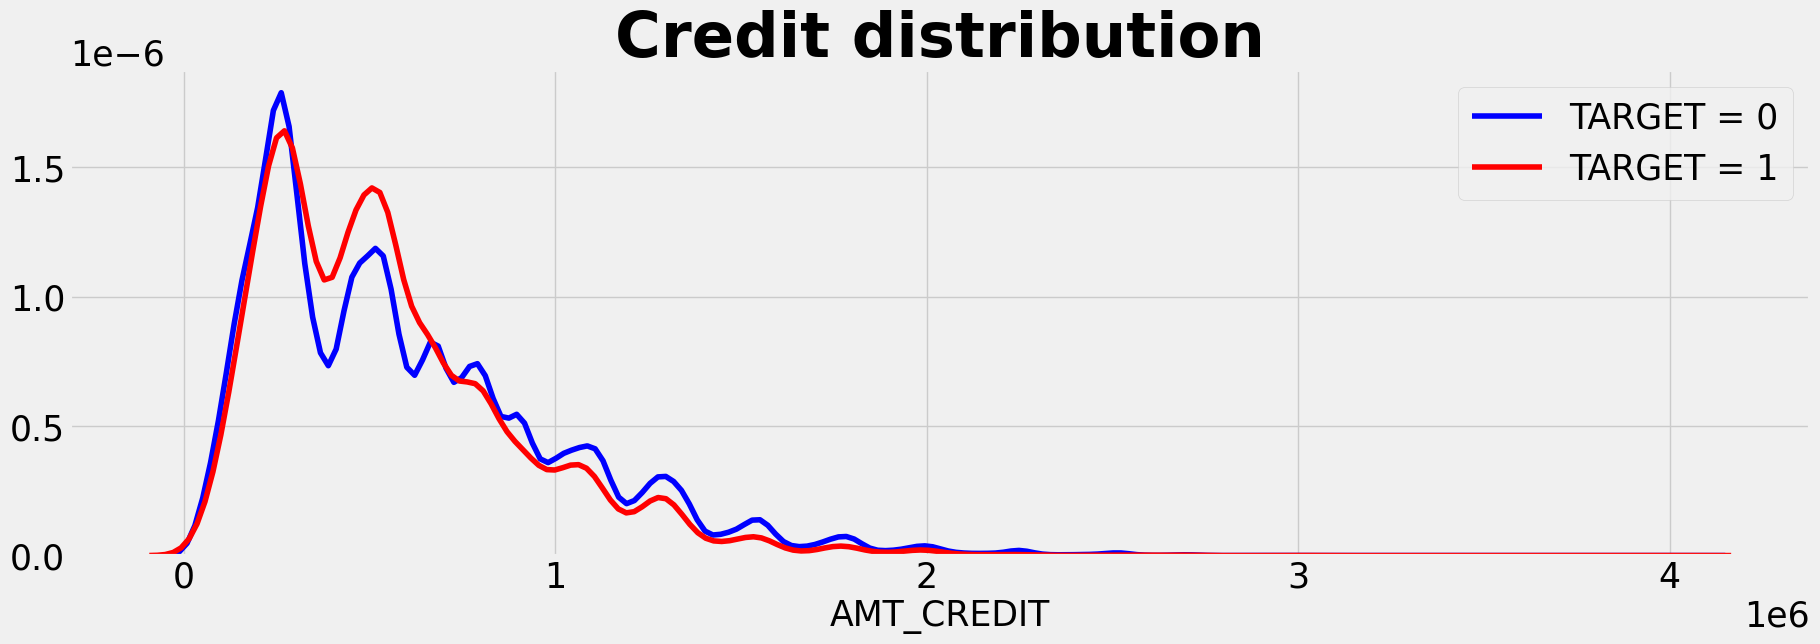

                                   -------------------------------------------------------


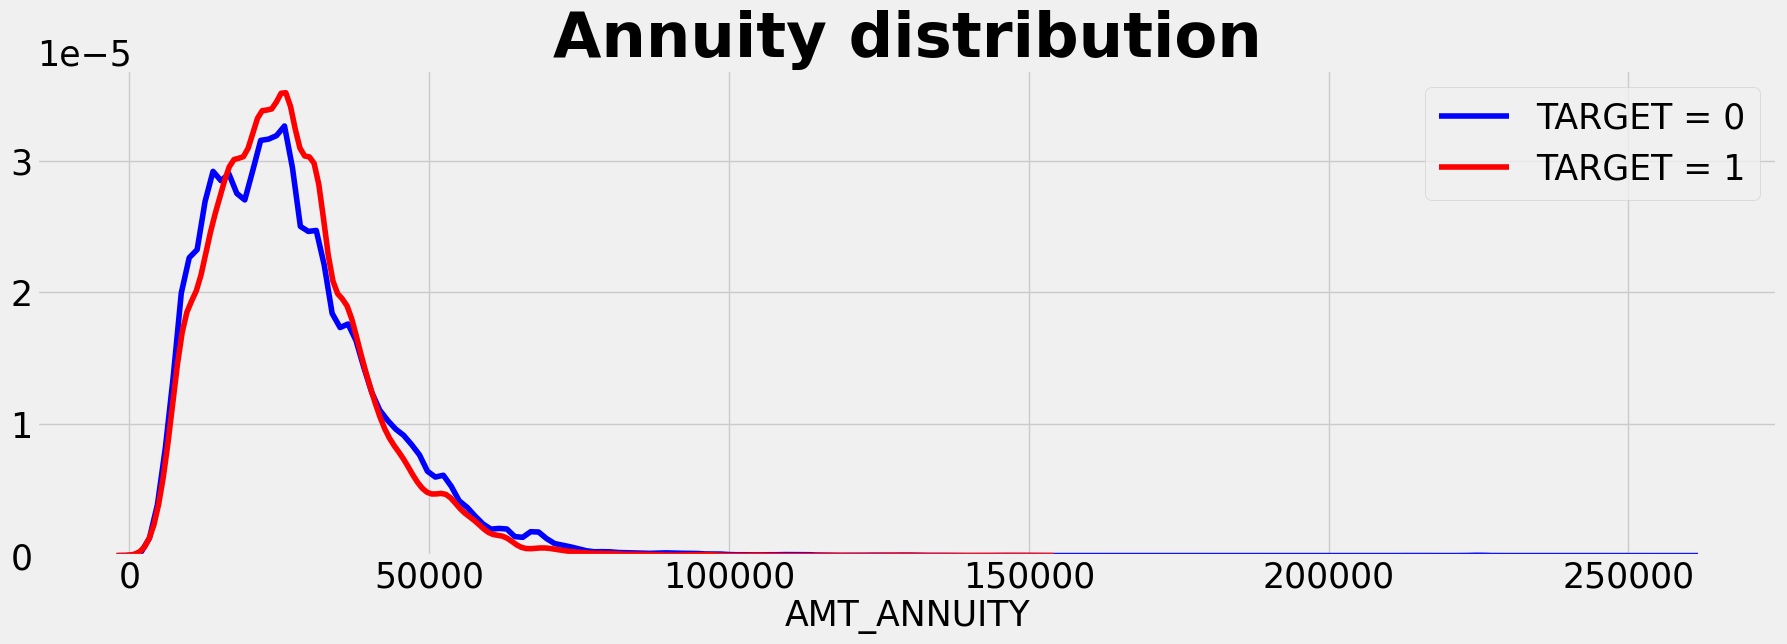

                                   -------------------------------------------------------


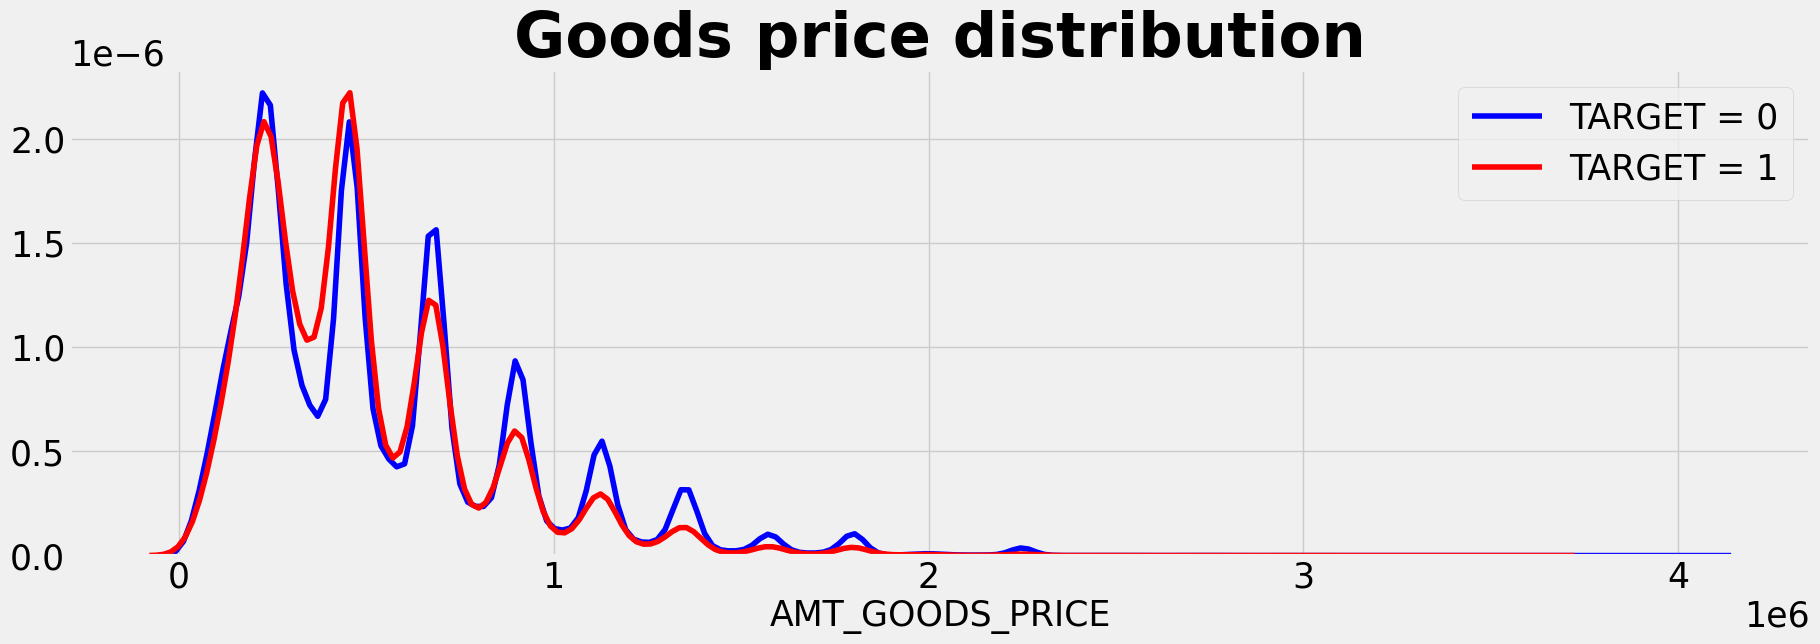

                                   -------------------------------------------------------


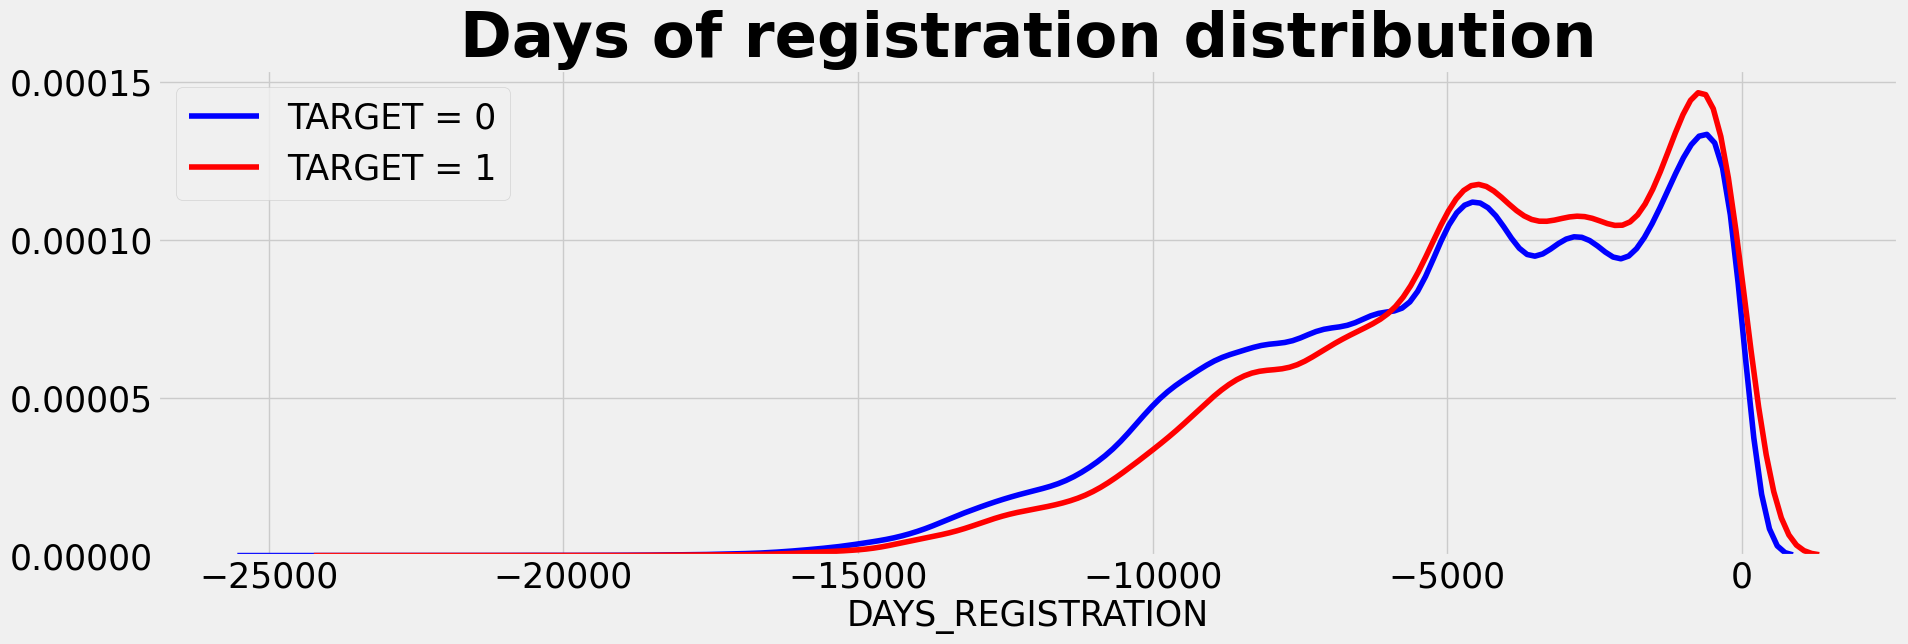

                                   -------------------------------------------------------


In [ ]:
plot_distribution('AMT_CREDIT', "Credit distribution")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_ANNUITY', "Annuity distribution")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_GOODS_PRICE', "Goods price distribution")
print("                                   -------------------------------------------------------")
plot_distribution('DAYS_REGISTRATION', "Days of registration distribution")
print("                                   -------------------------------------------------------")

### EDA bureau.csv

``Bureau data``

This file contains all the customers' previous credits provided by other financial institutions that have been reported to the credit bureau (for customers who have a loan in the sample). For each loan in the sample, there are as many lines as the number of credits the customer had at the credit bureau before the date of the request. SK_ID_CURR is the key linking the application_train | test data to the bureau data.

It is necessary to merge "application_train" with "bureau" in order to extract the TARGET share == 1.

In [ ]:
application_bureau_train = application_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [ ]:
print(len(application_train))
print(len(application_bureau_train))

307511
1465325


In [ ]:
description[description['Row']=='CREDIT_ACTIVE']

Table            Row  \
127  bureau.csv  CREDIT_ACTIVE   

                                           Description Special  
127  Status of the Credit Bureau (CB) reported credits     NaN

                                   -------------------------------------------------------


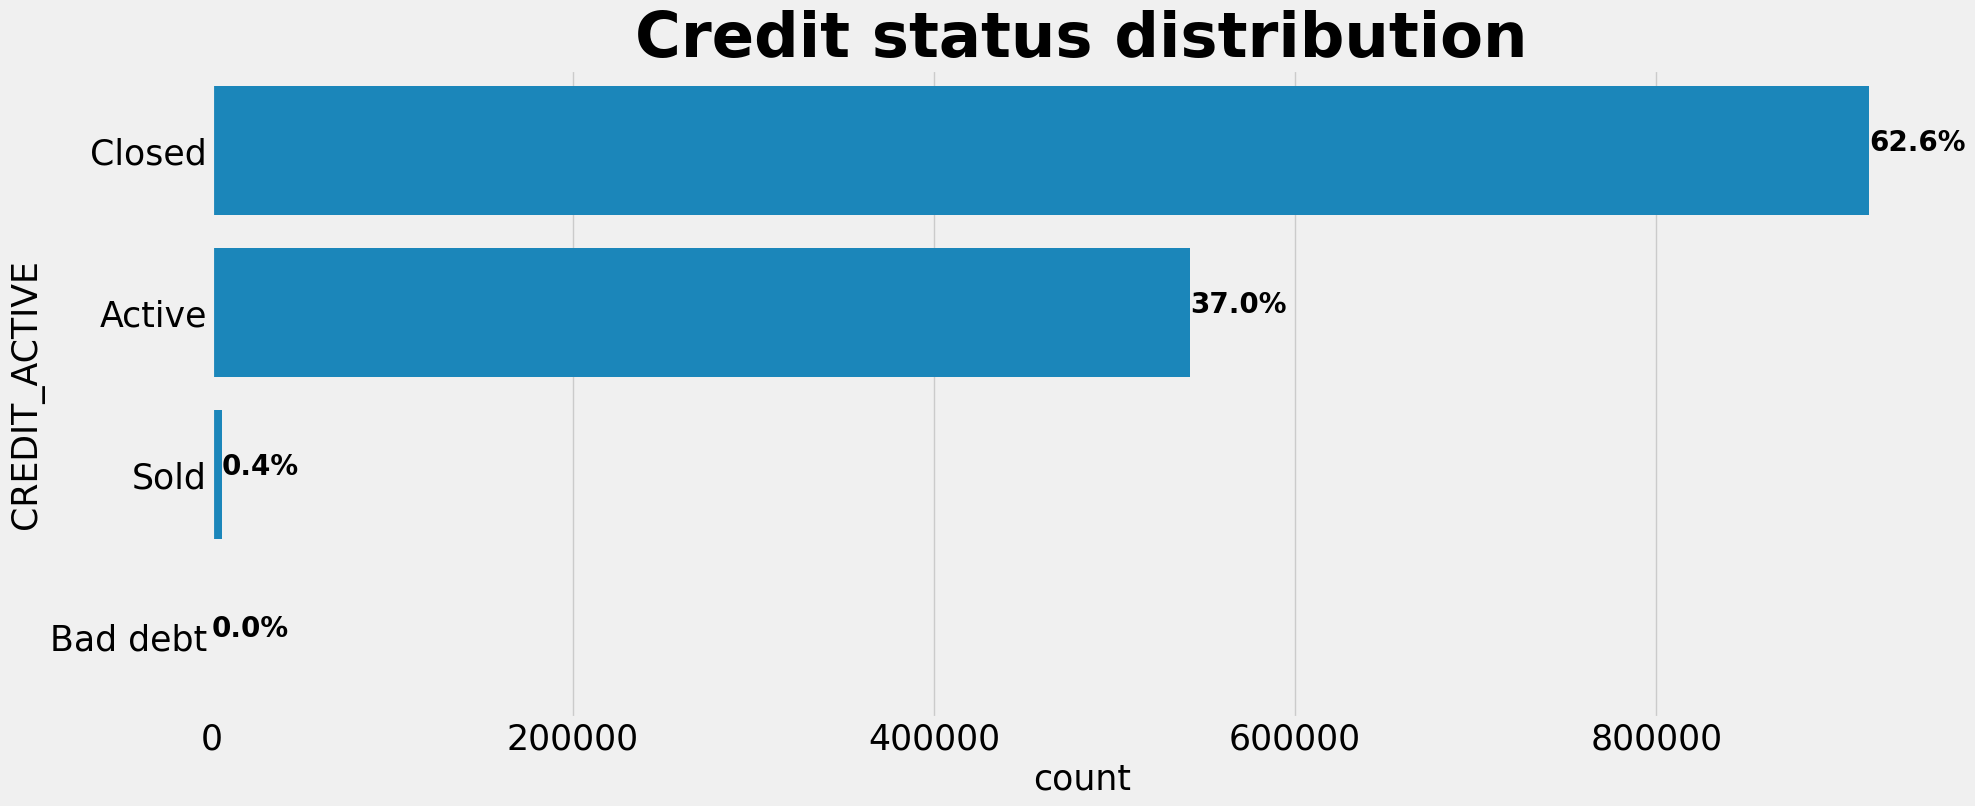

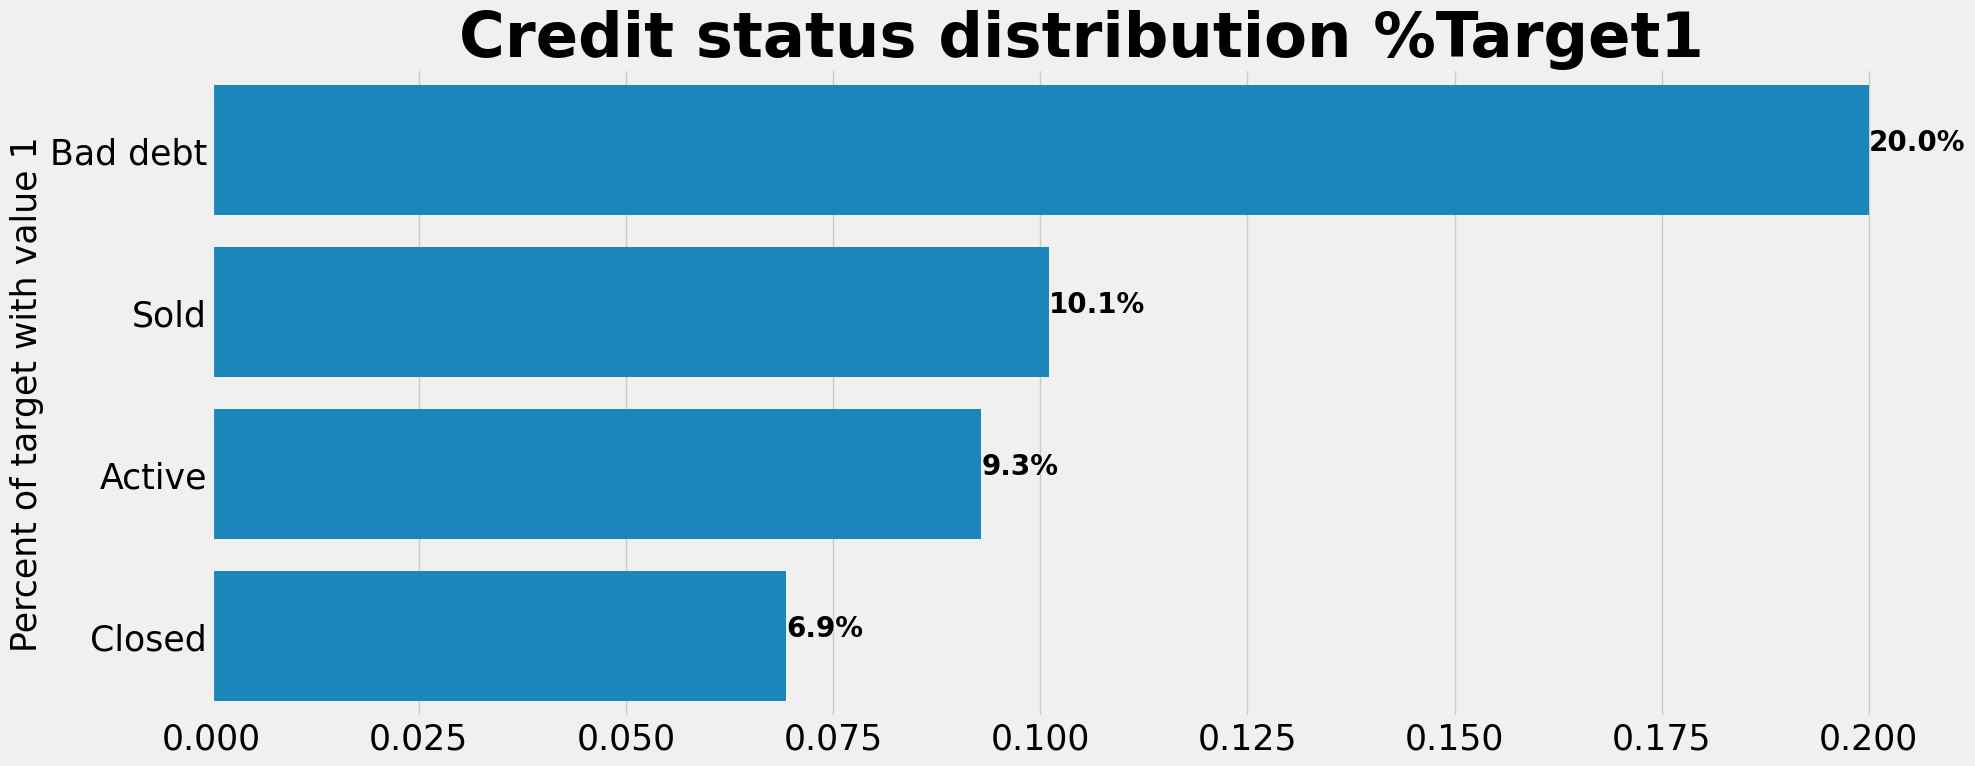

In [ ]:
#CREDIT_ACTIVE
plot_stat(application_bureau_train, 'CREDIT_ACTIVE',"Credit status distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_bureau_train, 'CREDIT_ACTIVE',"Credit status distribution %Target1")

In [ ]:
description[description['Row']=='CREDIT_CURRENCY']

Table              Row  \
128  bureau.csv  CREDIT_CURRENCY   

                                      Description  Special  
128  Recoded currency of the Credit Bureau credit  recoded

                                   -------------------------------------------------------


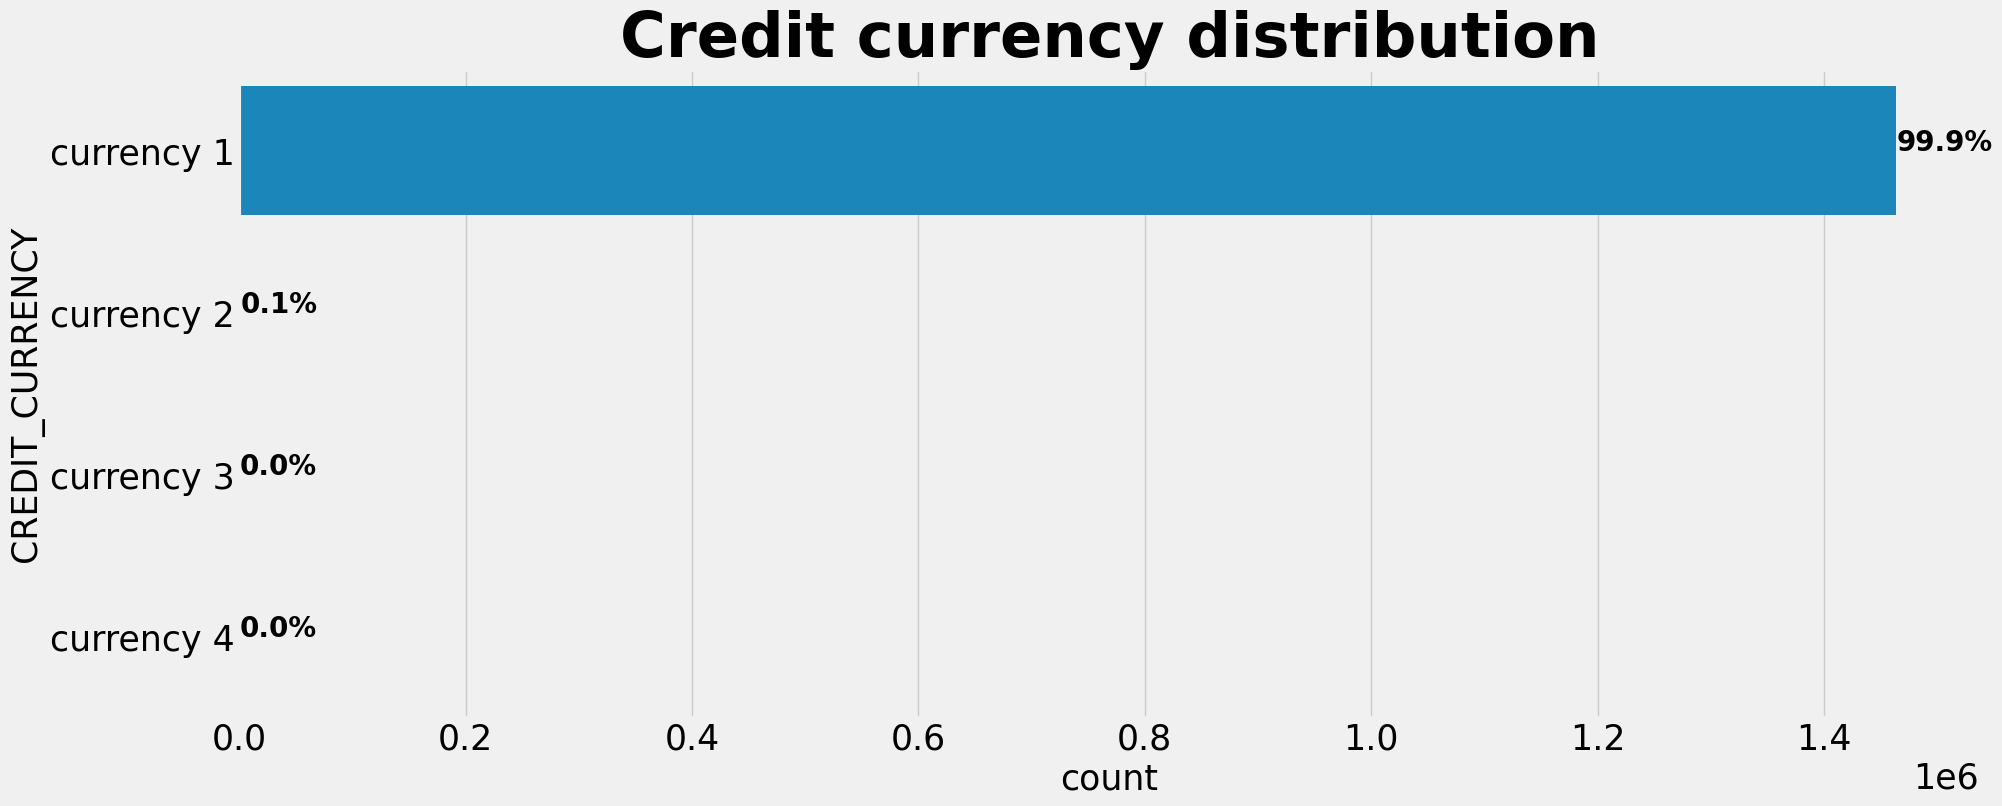

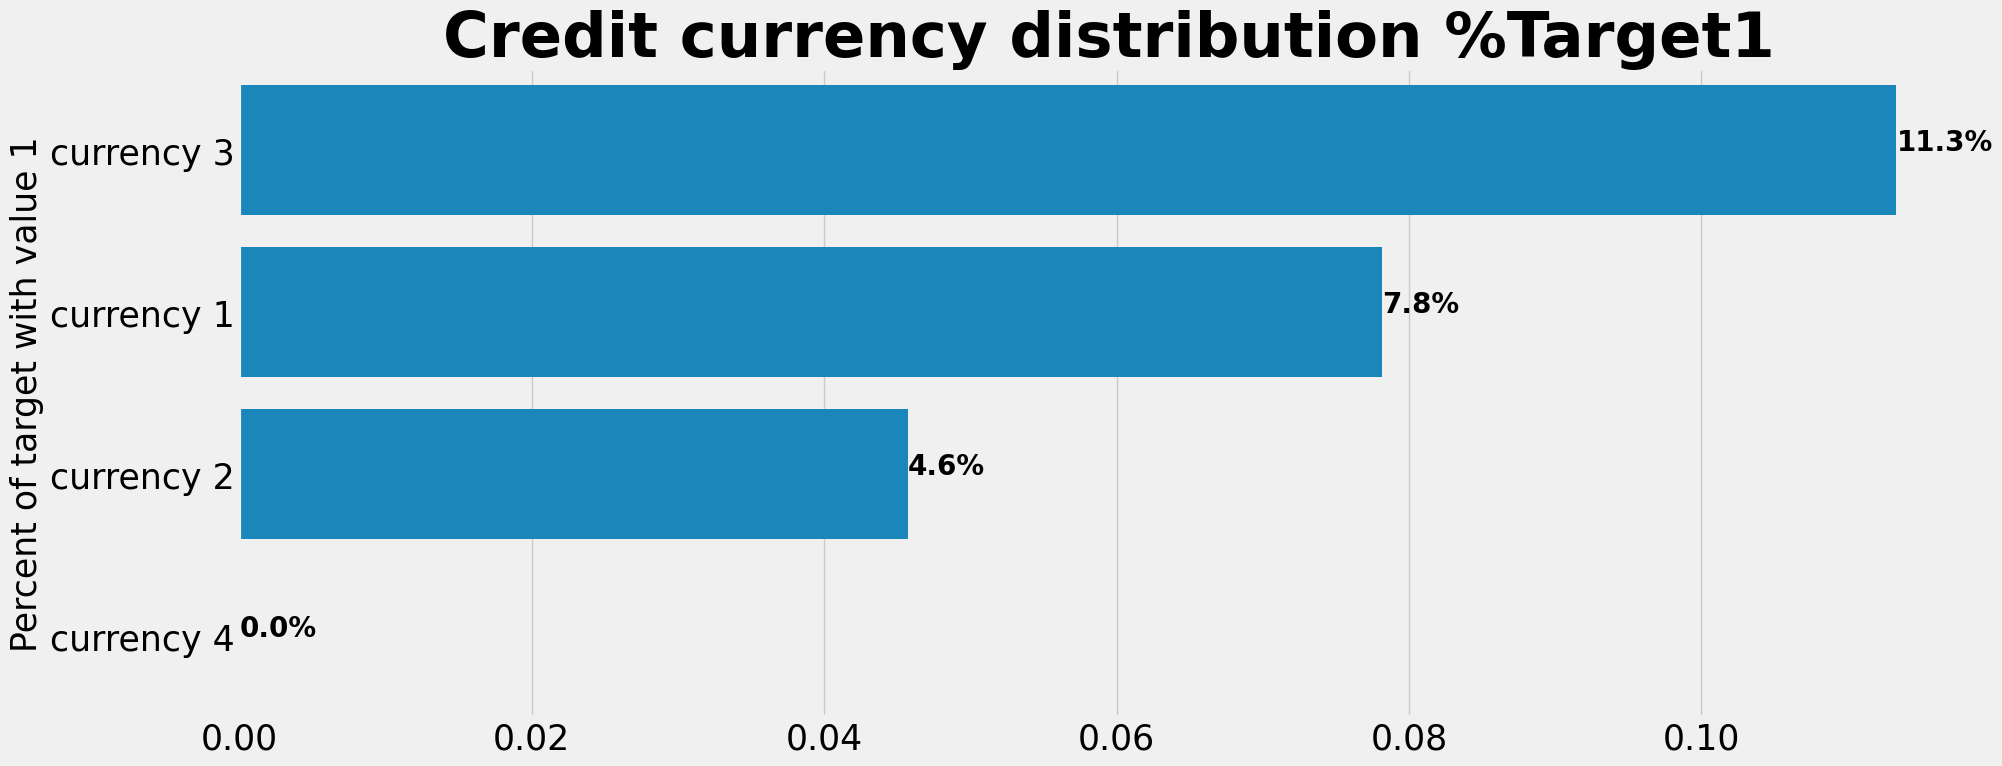

In [ ]:
#CREDIT_CURRENCY
plot_stat(application_bureau_train, 'CREDIT_CURRENCY',"Credit currency distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_bureau_train, 'CREDIT_CURRENCY',"Credit currency distribution %Target1")

In [ ]:
description[description['Row']=='CREDIT_TYPE']

Table          Row                                   Description  \
139  bureau.csv  CREDIT_TYPE  Type of Credit Bureau credit (Car, cash,...)   

    Special  
139     NaN

                                   -------------------------------------------------------


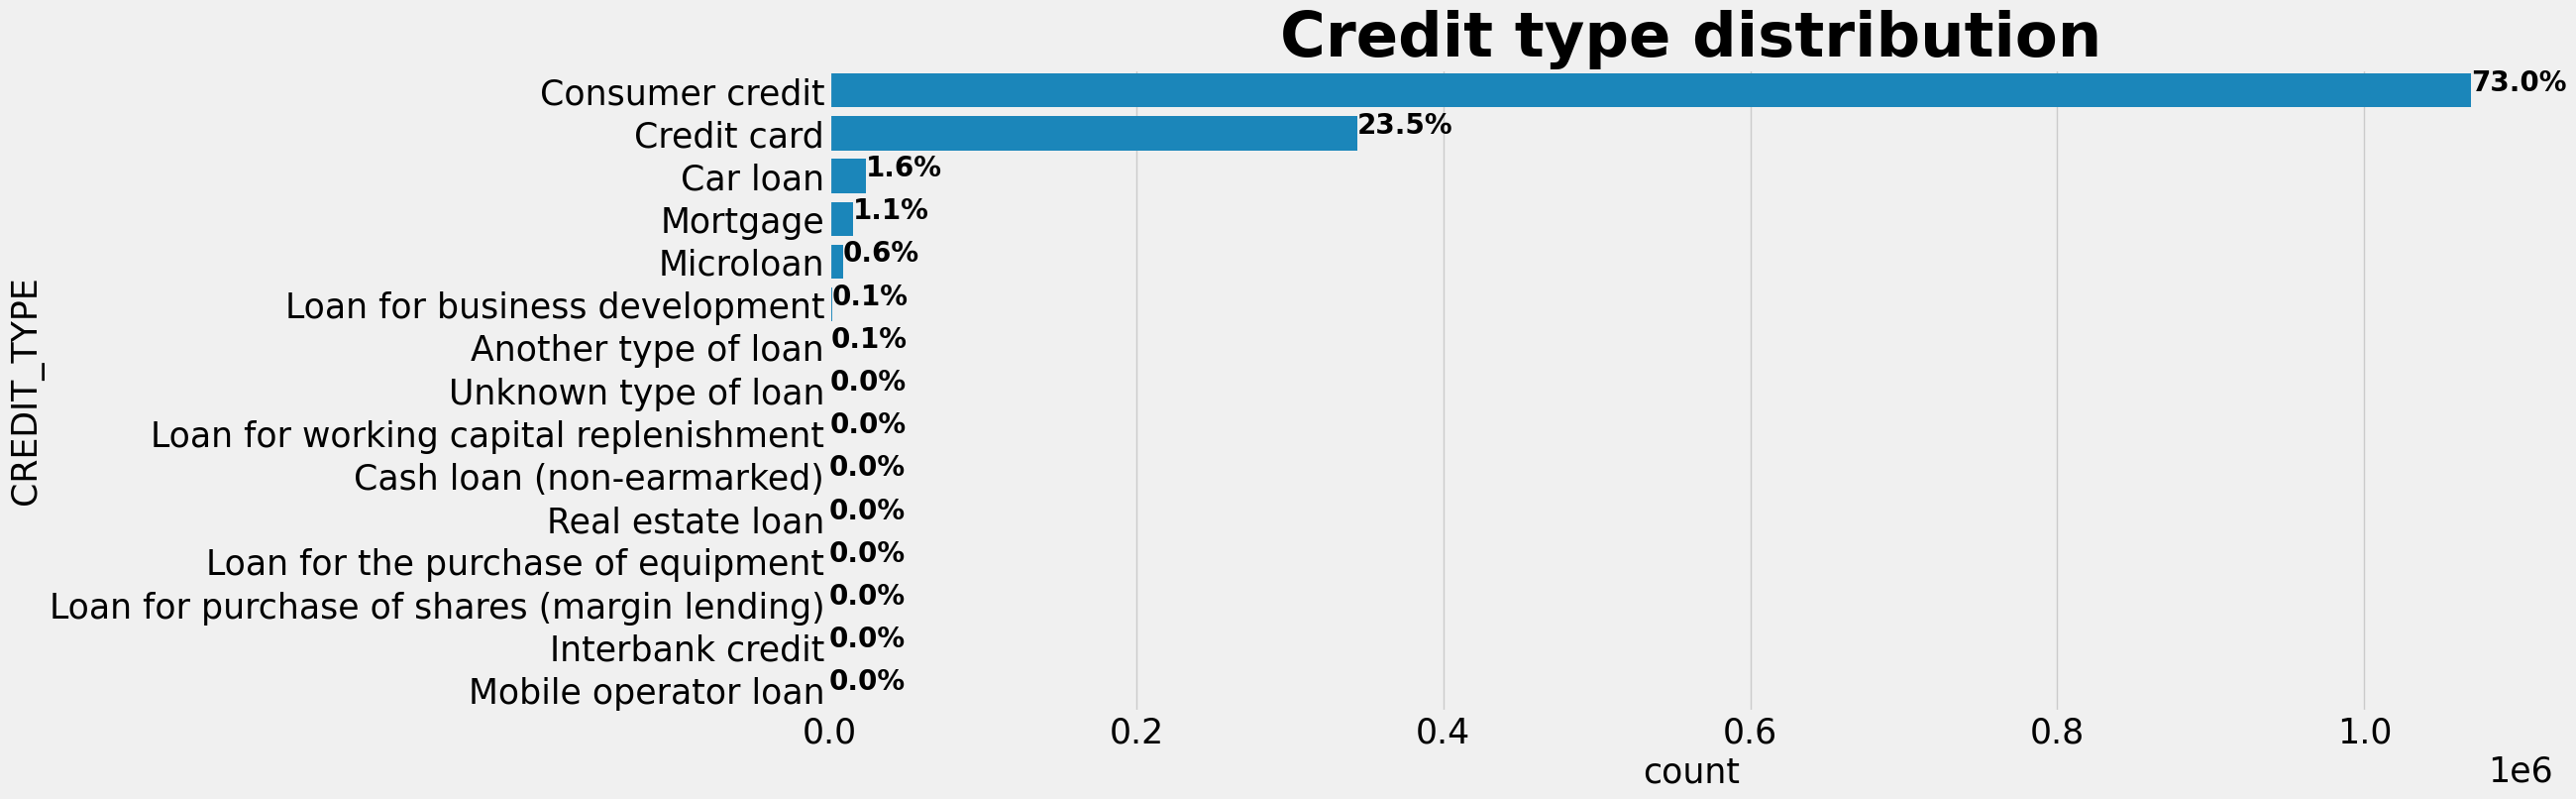

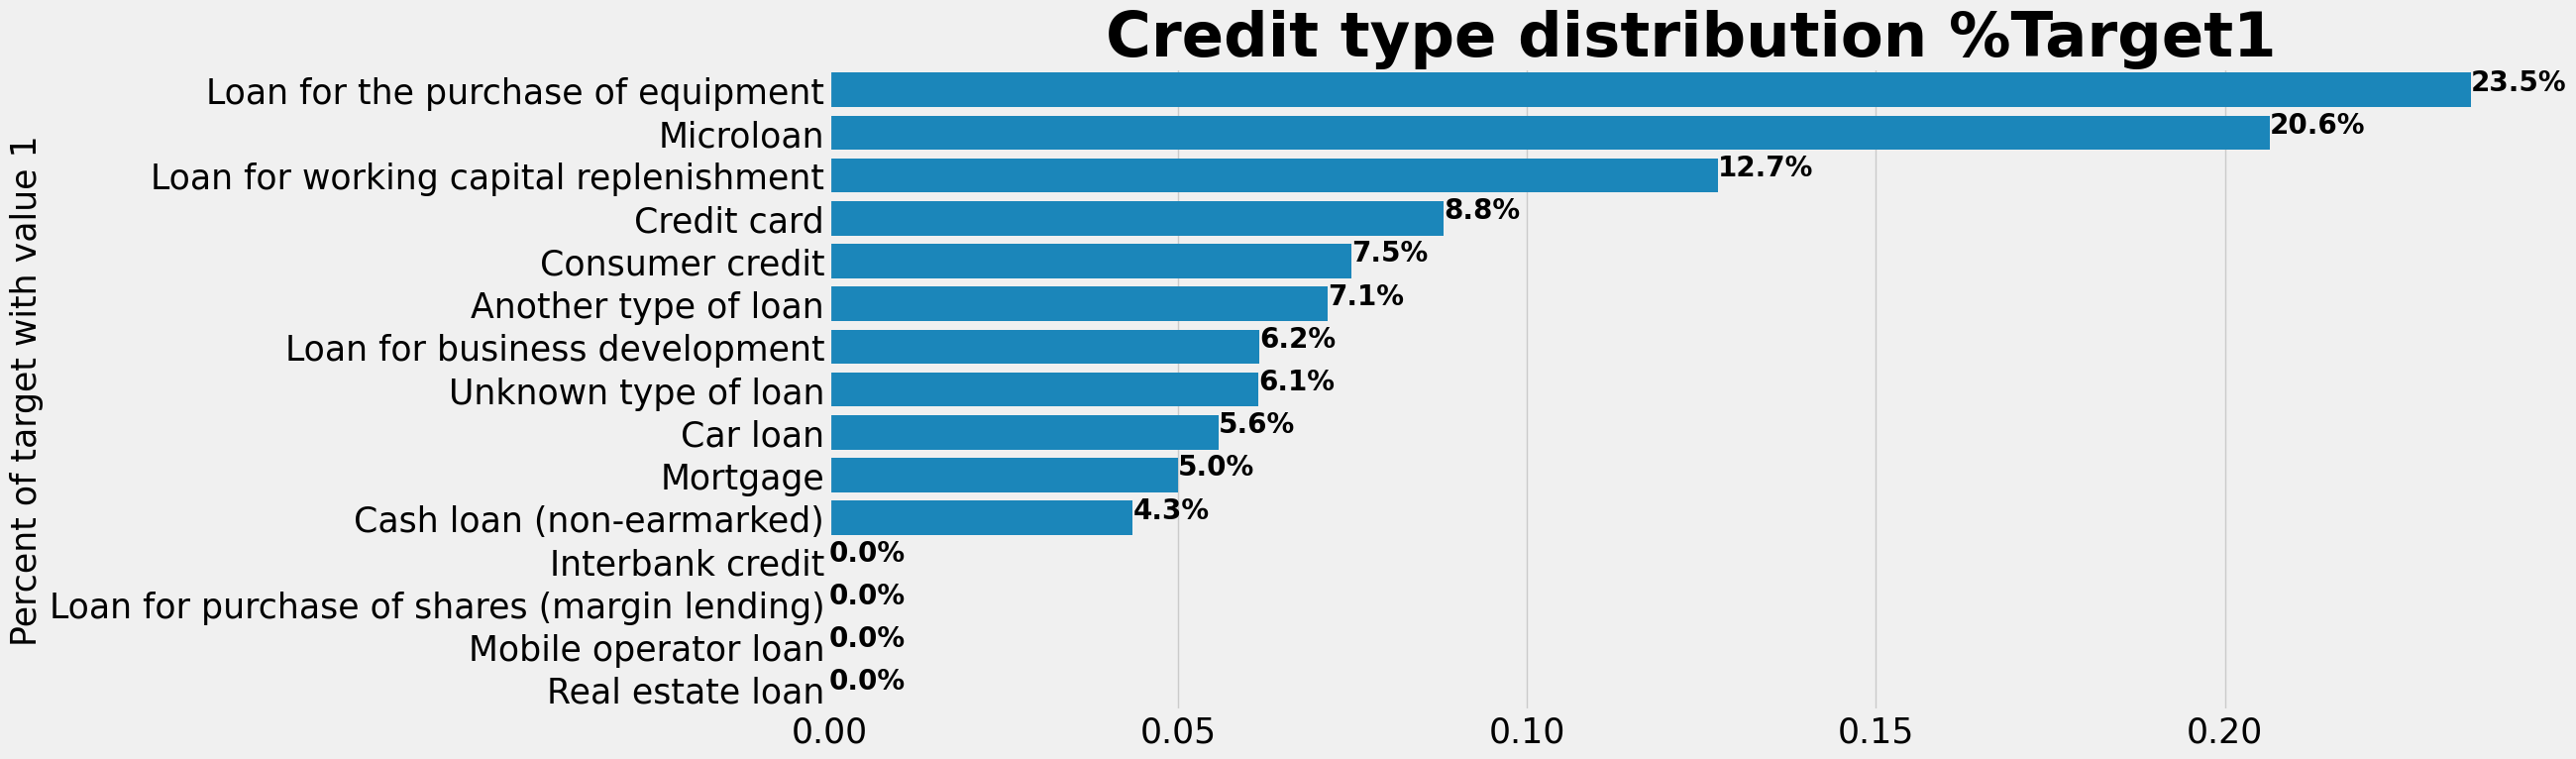

In [ ]:
#CREDIT_TYPE
plot_stat(application_bureau_train, 'CREDIT_TYPE',"Credit type distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_bureau_train, 'CREDIT_TYPE',"Credit type distribution %Target1")

In [ ]:
del application_bureau_train

### EDA previous_application.csv

``Previous application data``

"previous_application" contains information on all previous home loan applications from customers who have loans in the sample. There is a row for each previous application linked to the loans in our sample data. SK_ID_CURR is the key linking the application_train | test data to the previous_application data.


It is necessary to merge "application_train" with "previous_application" in order to extract the TARGET share == 1.

In [ ]:
previous_application.columns
for col in previous_application.columns:
  select = (description['Row']==col) & (description['Table']=='previous_application.csv')
  if select.any():
    # Accessing the Description column using .loc and column name outside the f-string
    desc = description.loc[select, 'Description'].iloc[0]
    print(f'{col}: {desc}')
  else:
    print(f'{col}: No description')

SK_ID_PREV: No description
SK_ID_CURR: ID of loan in our sample
NAME_CONTRACT_TYPE: Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application
AMT_ANNUITY: Annuity of previous application
AMT_APPLICATION: For how much credit did client ask on the previous application
AMT_CREDIT: Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT
AMT_DOWN_PAYMENT: Down payment on the previous application
AMT_GOODS_PRICE: Goods price of good that client asked for (if applicable) on the previous application
WEEKDAY_APPR_PROCESS_START: On which day of the week did the client apply for previous application
HOUR_APPR_PROCESS_START: Approximately at what day hour did the client apply for the previous application
FLAG_LAST_APPL_PER_CONTRACT: Flag if it was last application for

In [ ]:
application_prev_train = application_train.merge(previous_application,
                                                 left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [ ]:
# NAME_CONTRACT_TYPE is both inside application_train and previous_application
# --> columns names will be changed to NAME_CONTRACT_TYPE_x (for application_train) and NAME_CONTRACT_TYPE_y (for previous_application)
description[description['Row']=='NAME_CONTRACT_TYPE']

Table                 Row  \
5    application_{train|test}.csv  NAME_CONTRACT_TYPE   
178      previous_application.csv  NAME_CONTRACT_TYPE   

                                                                                 Description  \
5                                                Identification if loan is cash or revolving   
178  Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application   

    Special  
5       NaN  
178     NaN

                                   -------------------------------------------------------


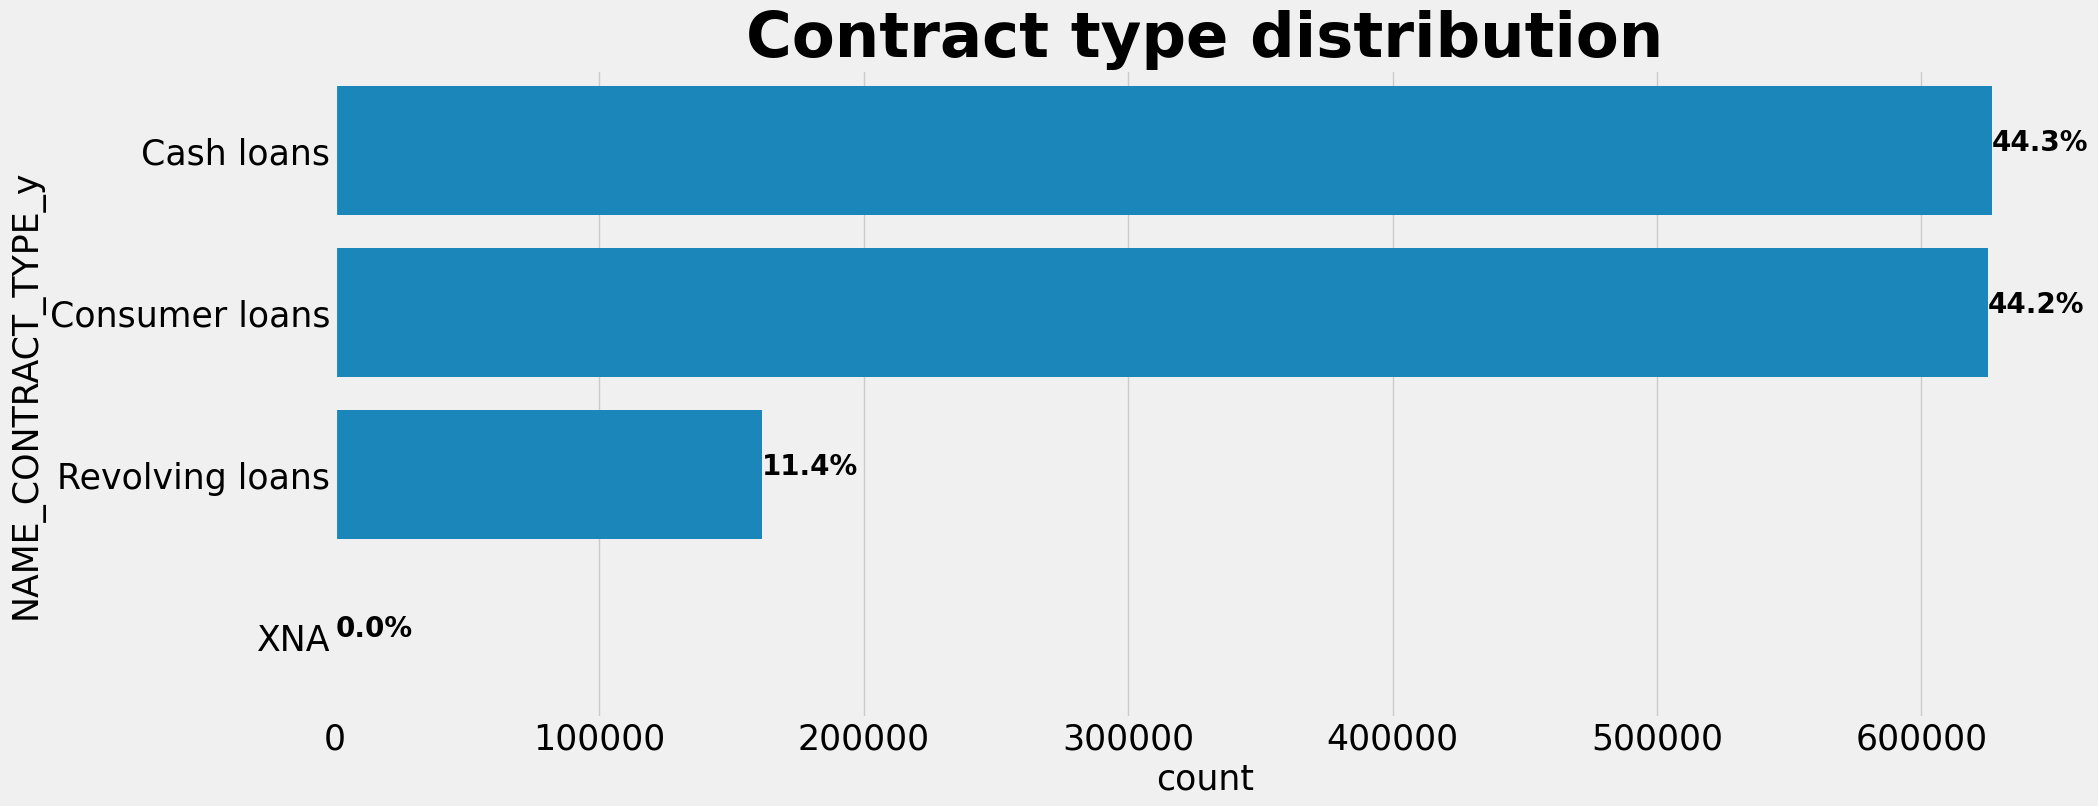

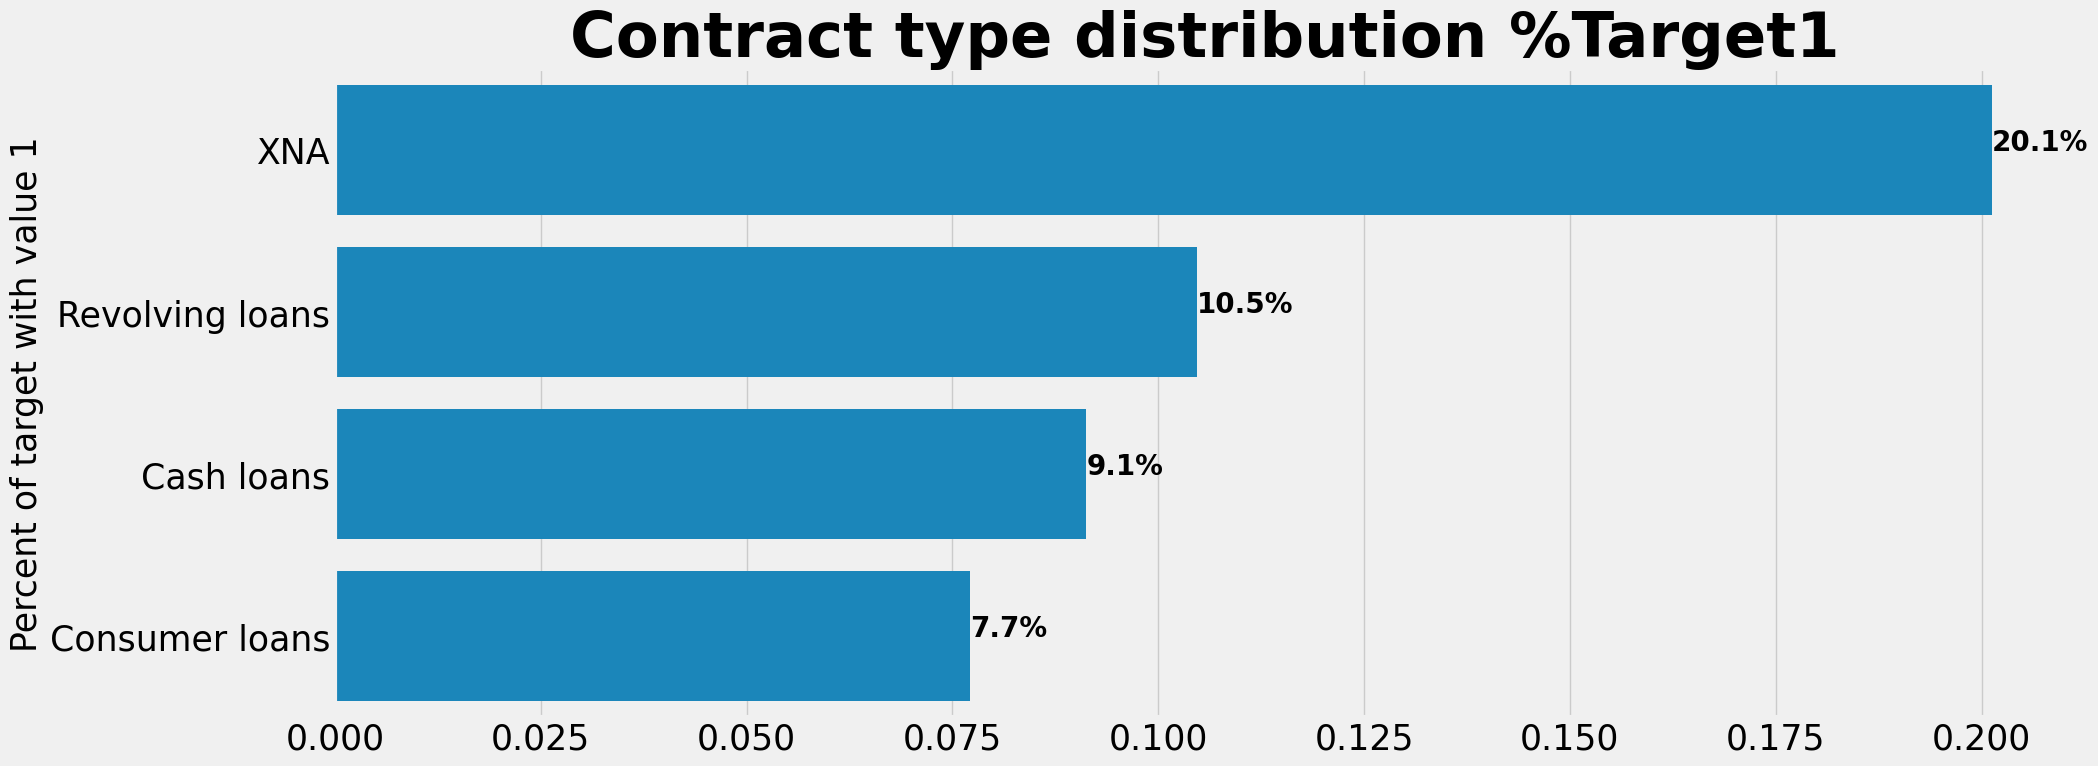

In [ ]:
#NAME_CONTRACT_TYPE_y (we are chosing *_y since *_x is the name for NAME_CONTRACT_TYPE in the original application_train dataframe)
plot_stat(application_prev_train, 'NAME_CONTRACT_TYPE_y',"Contract type distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_CONTRACT_TYPE_y',"Contract type distribution %Target1")

In [ ]:
description[description['Row']=='NAME_CONTRACT_STATUS']

Table                   Row  \
150      POS_CASH_balance.csv  NAME_CONTRACT_STATUS   
173   credit_card_balance.csv  NAME_CONTRACT_STATUS   
193  previous_application.csv  NAME_CONTRACT_STATUS   

                                                            Description  \
150                                    Contract status during the month   
173          Contract status (active signed,...) on the previous credit   
193  Contract status (approved, cancelled, ...) of previous application   

    Special  
150     NaN  
173     NaN  
193     NaN

                                   -------------------------------------------------------


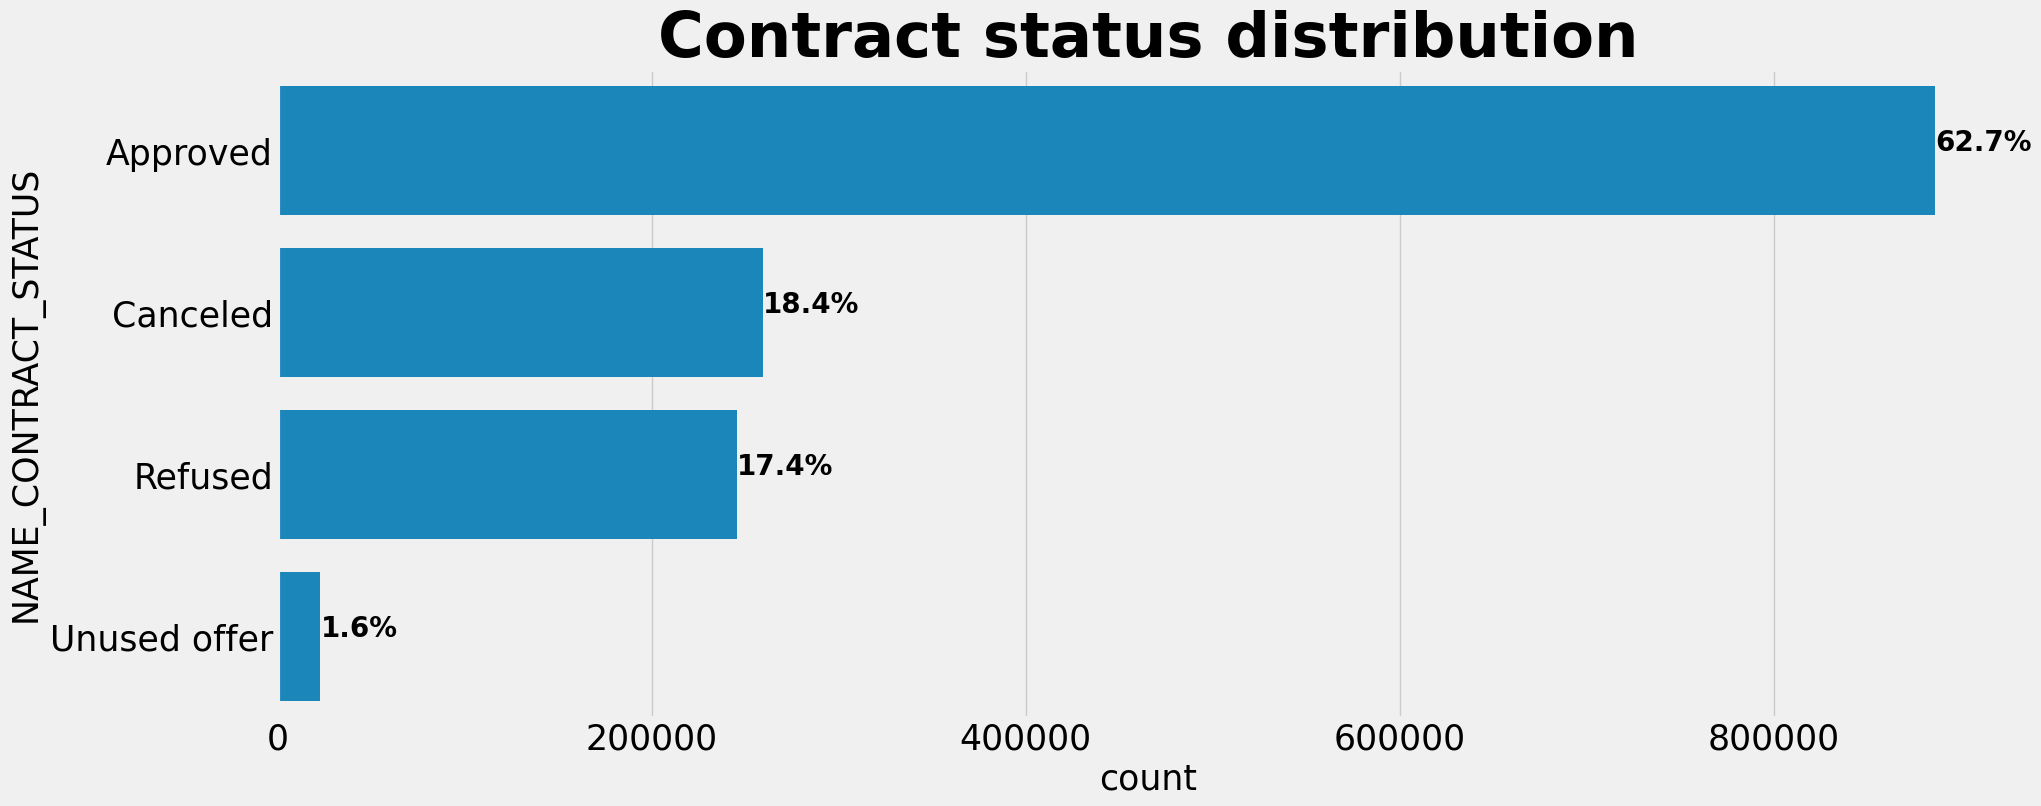

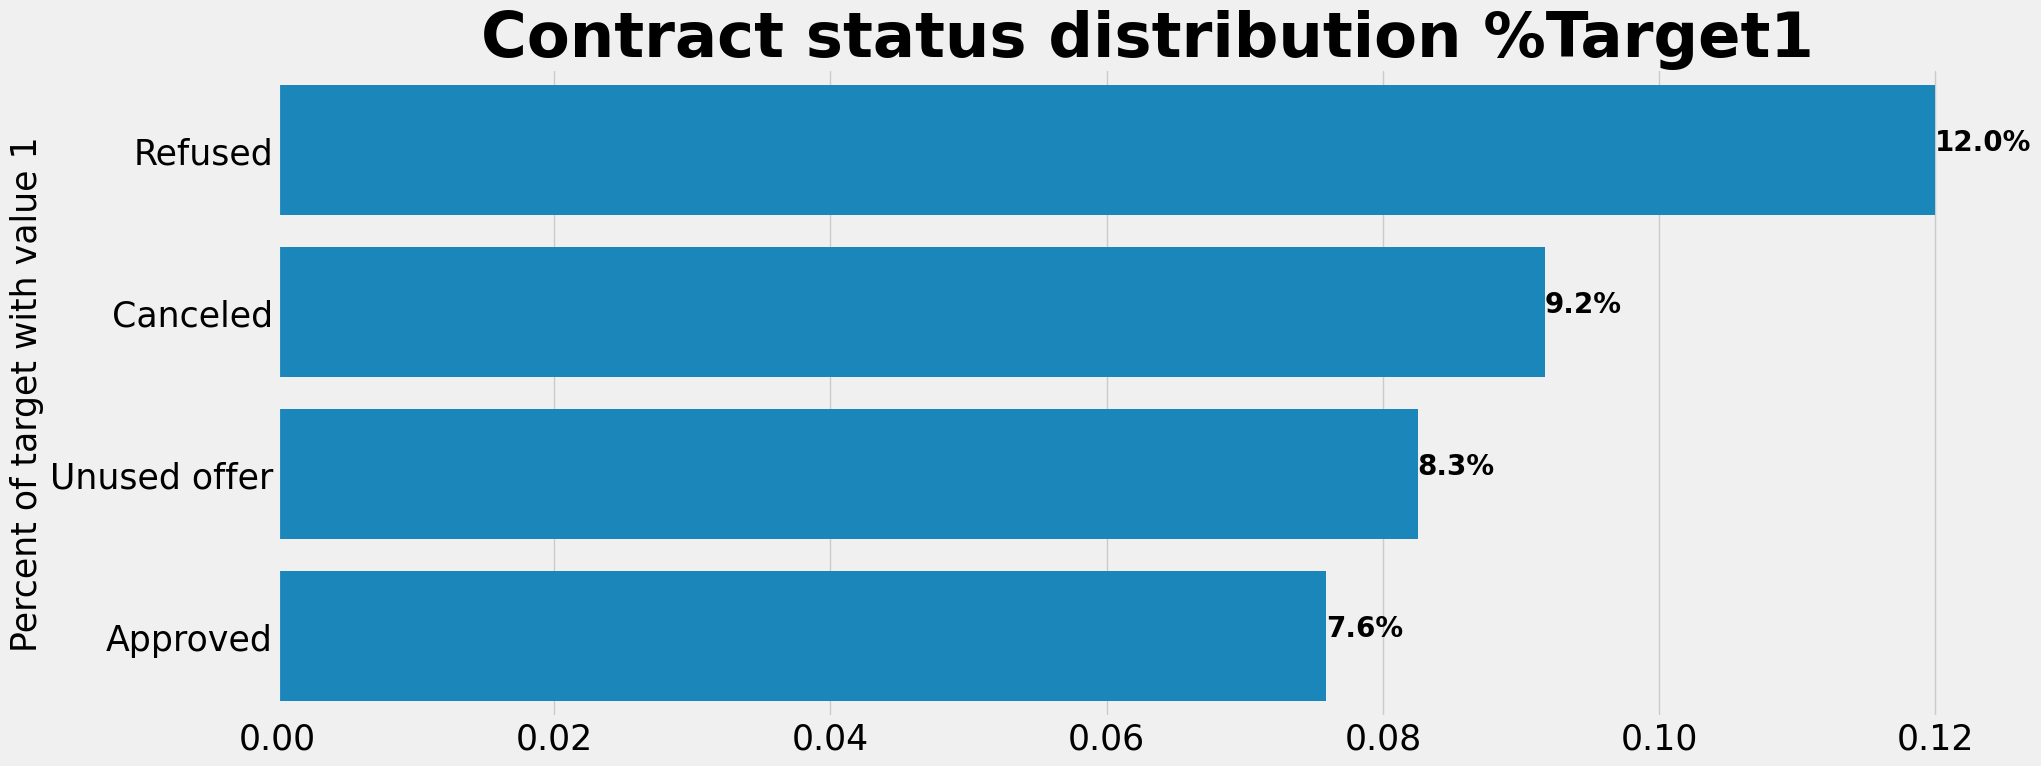

In [ ]:
#NAME_CONTRACT_STATUS
plot_stat(application_prev_train, 'NAME_CONTRACT_STATUS',"Contract status distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_CONTRACT_STATUS',"Contract status distribution %Target1")

Here's something interesting: although customers who decided not to close the previous loan (in previous_aplications.csv) could be considered cautious, they actually have higher default rates.

In [ ]:
description[description['Row']=='NAME_PAYMENT_TYPE']

Table                Row  \
195  previous_application.csv  NAME_PAYMENT_TYPE   

                                                              Description  \
195  Payment method that client chose to pay for the previous application   

    Special  
195     NaN

non-cash from your account : refund with bills at the bank

                                   -------------------------------------------------------


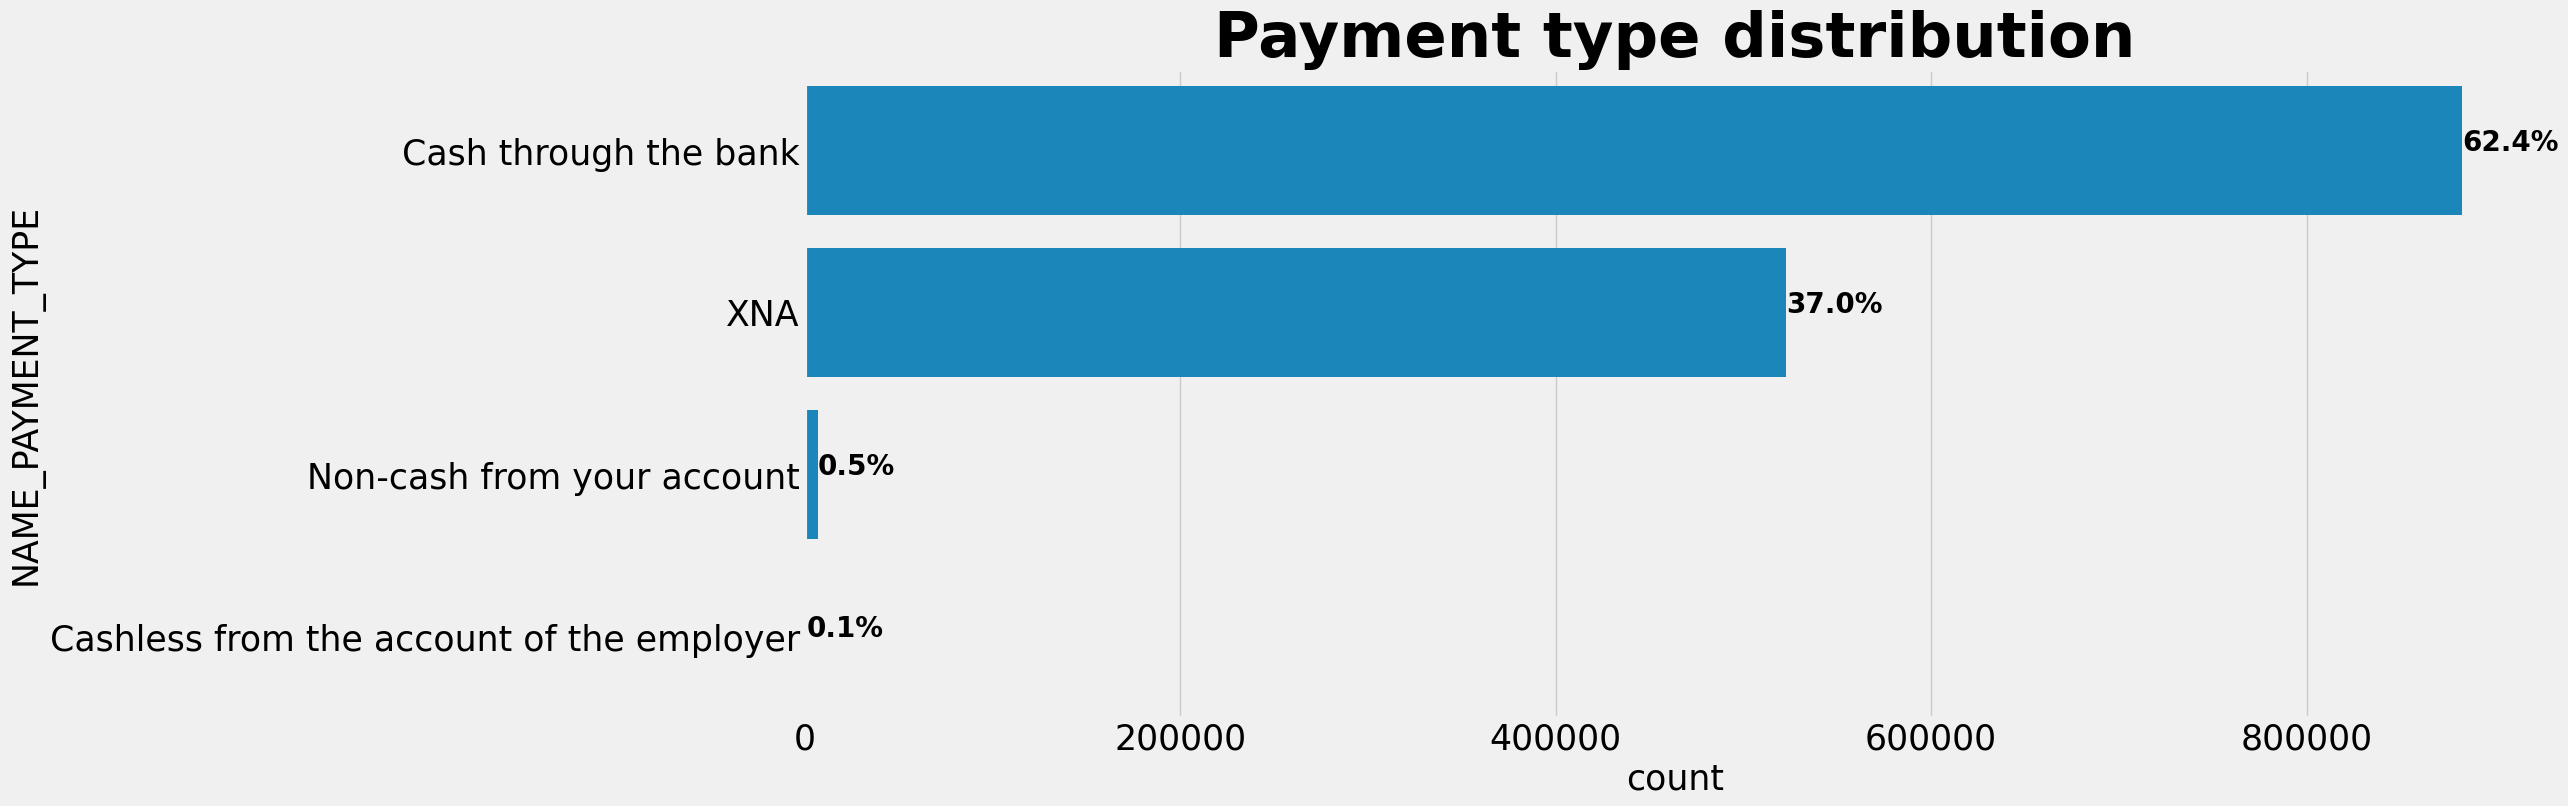

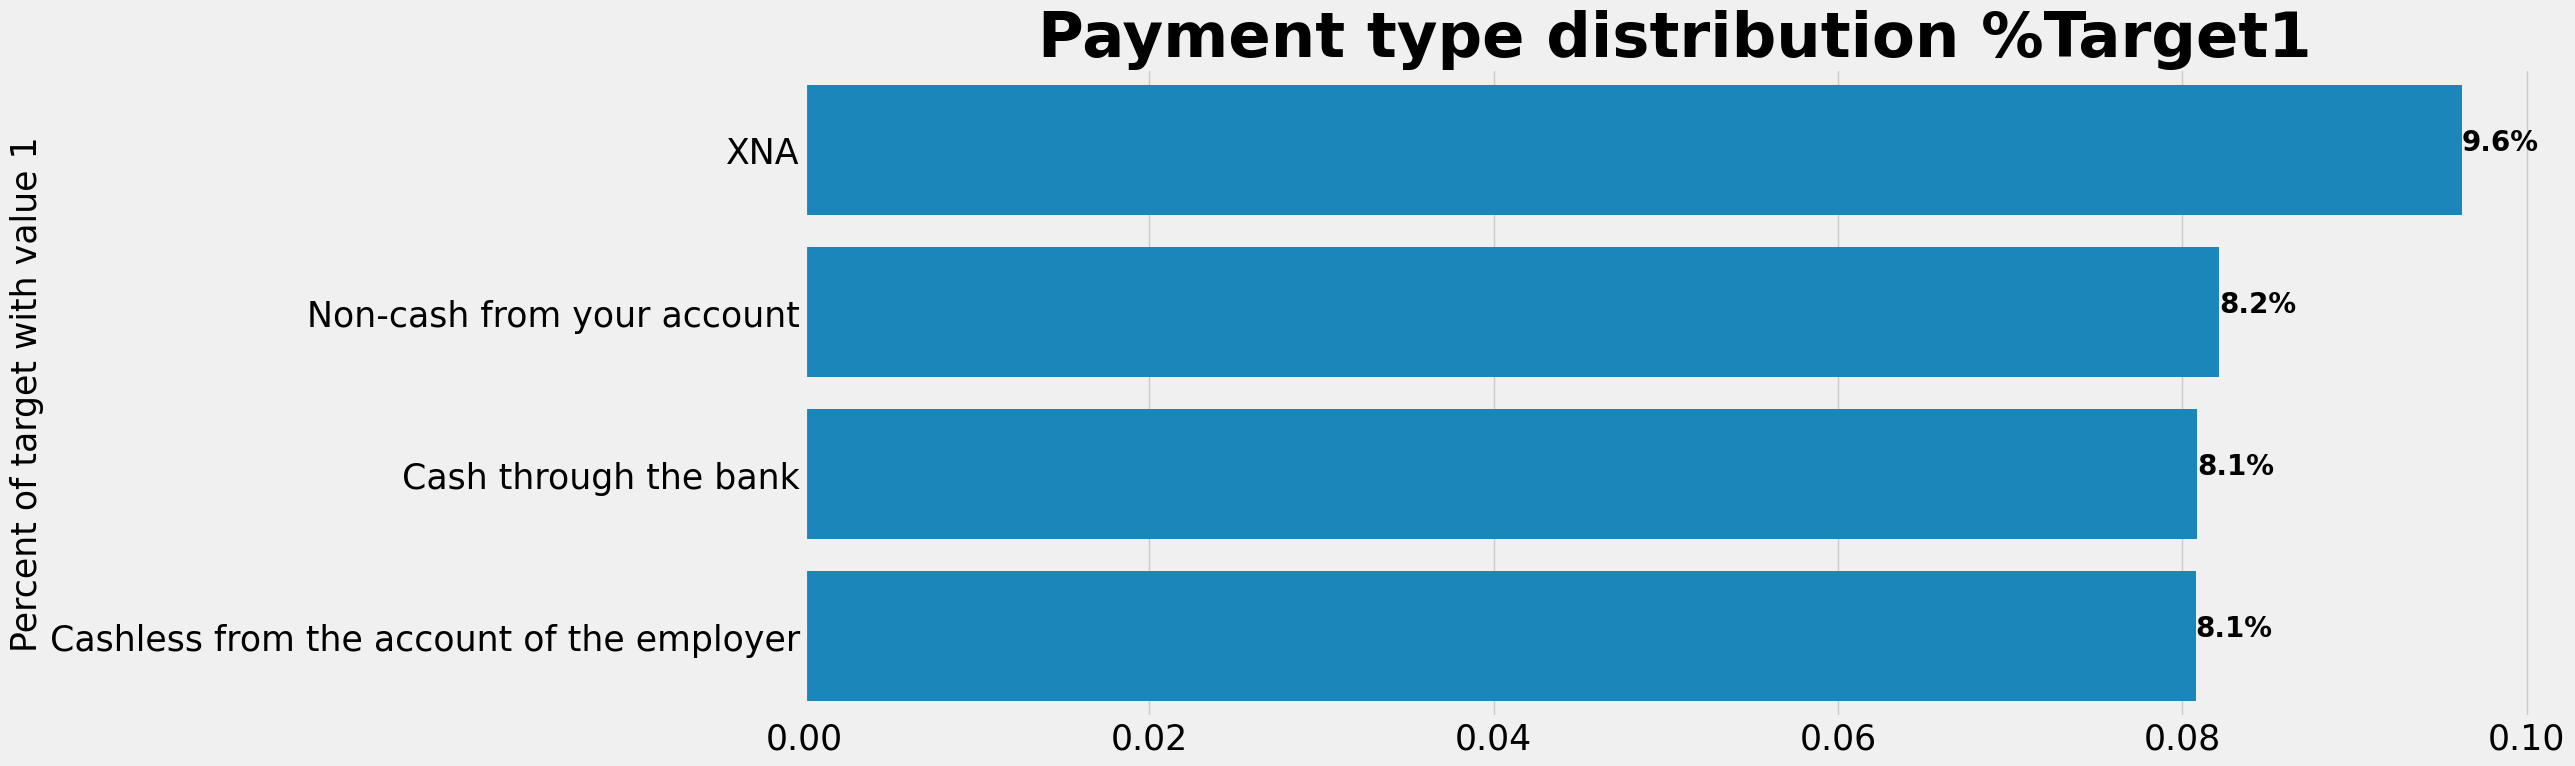

In [ ]:
#NAME_PAYMENT_TYPE
plot_stat(application_prev_train, 'NAME_PAYMENT_TYPE',"Payment type distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_PAYMENT_TYPE',"Payment type distribution %Target1")

Most payments are made in cash via the bank. The repayment of credit in the event of default (Target 1) does not affect any type of payment, so equality is almost perfect.

In [ ]:
description[description['Row']=='NAME_CLIENT_TYPE']

Table               Row  \
198  previous_application.csv  NAME_CLIENT_TYPE   

                                                                     Description  \
198  Was the client old or new client when applying for the previous application   

    Special  
198     NaN

                                   -------------------------------------------------------


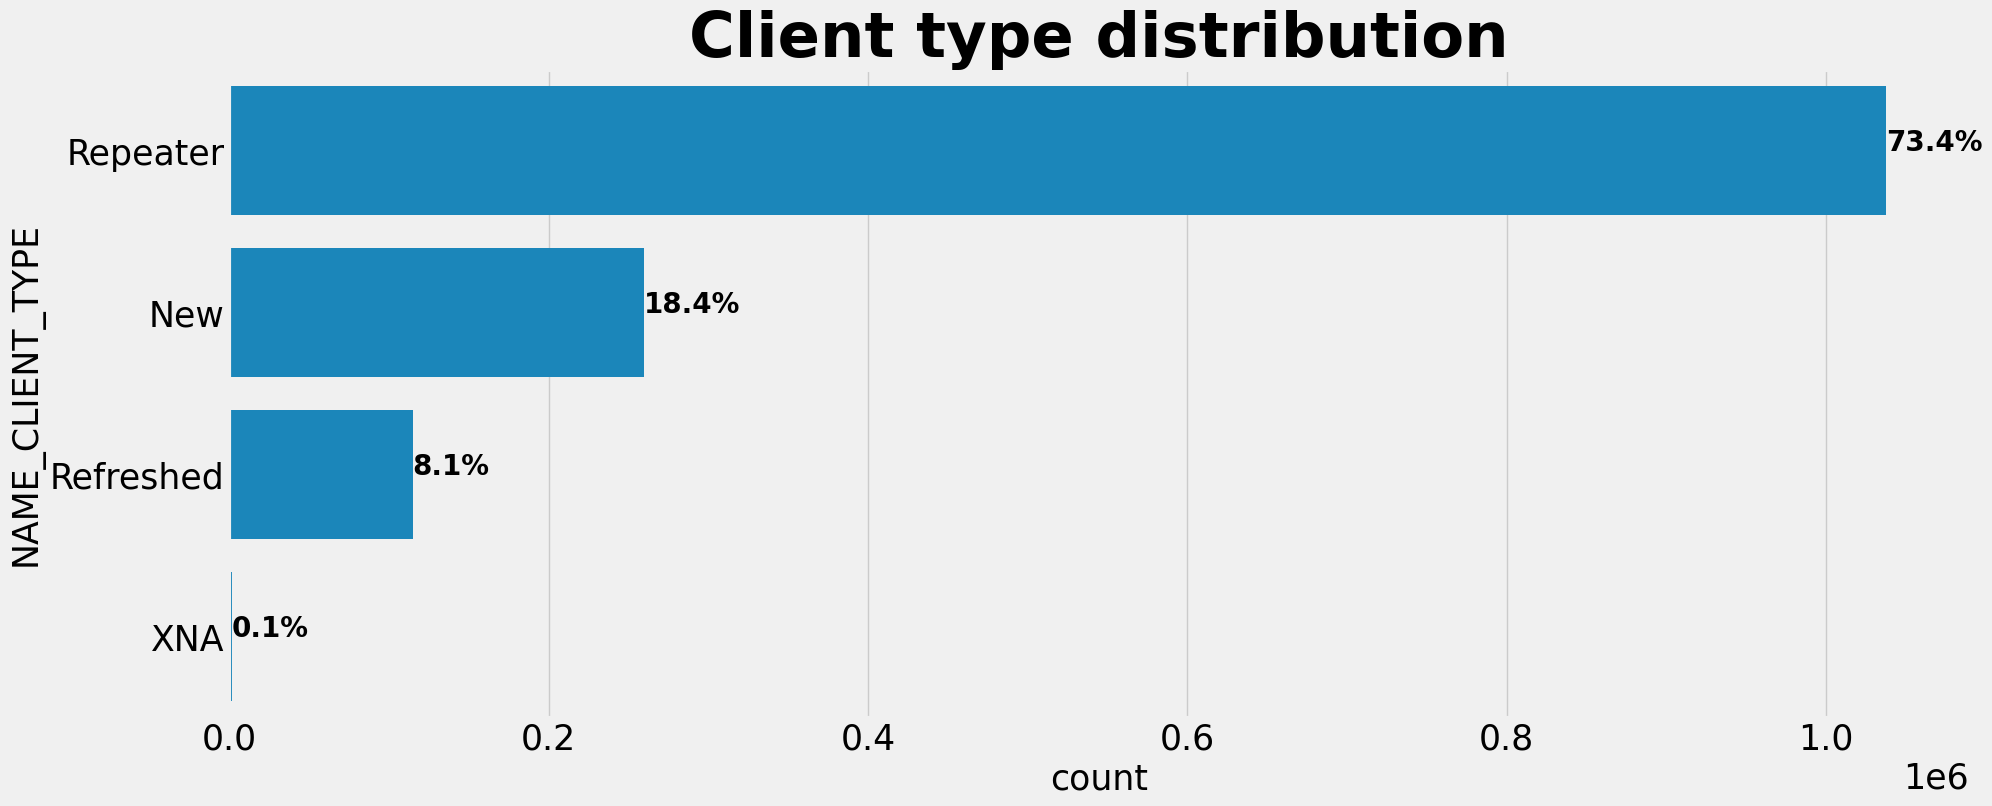

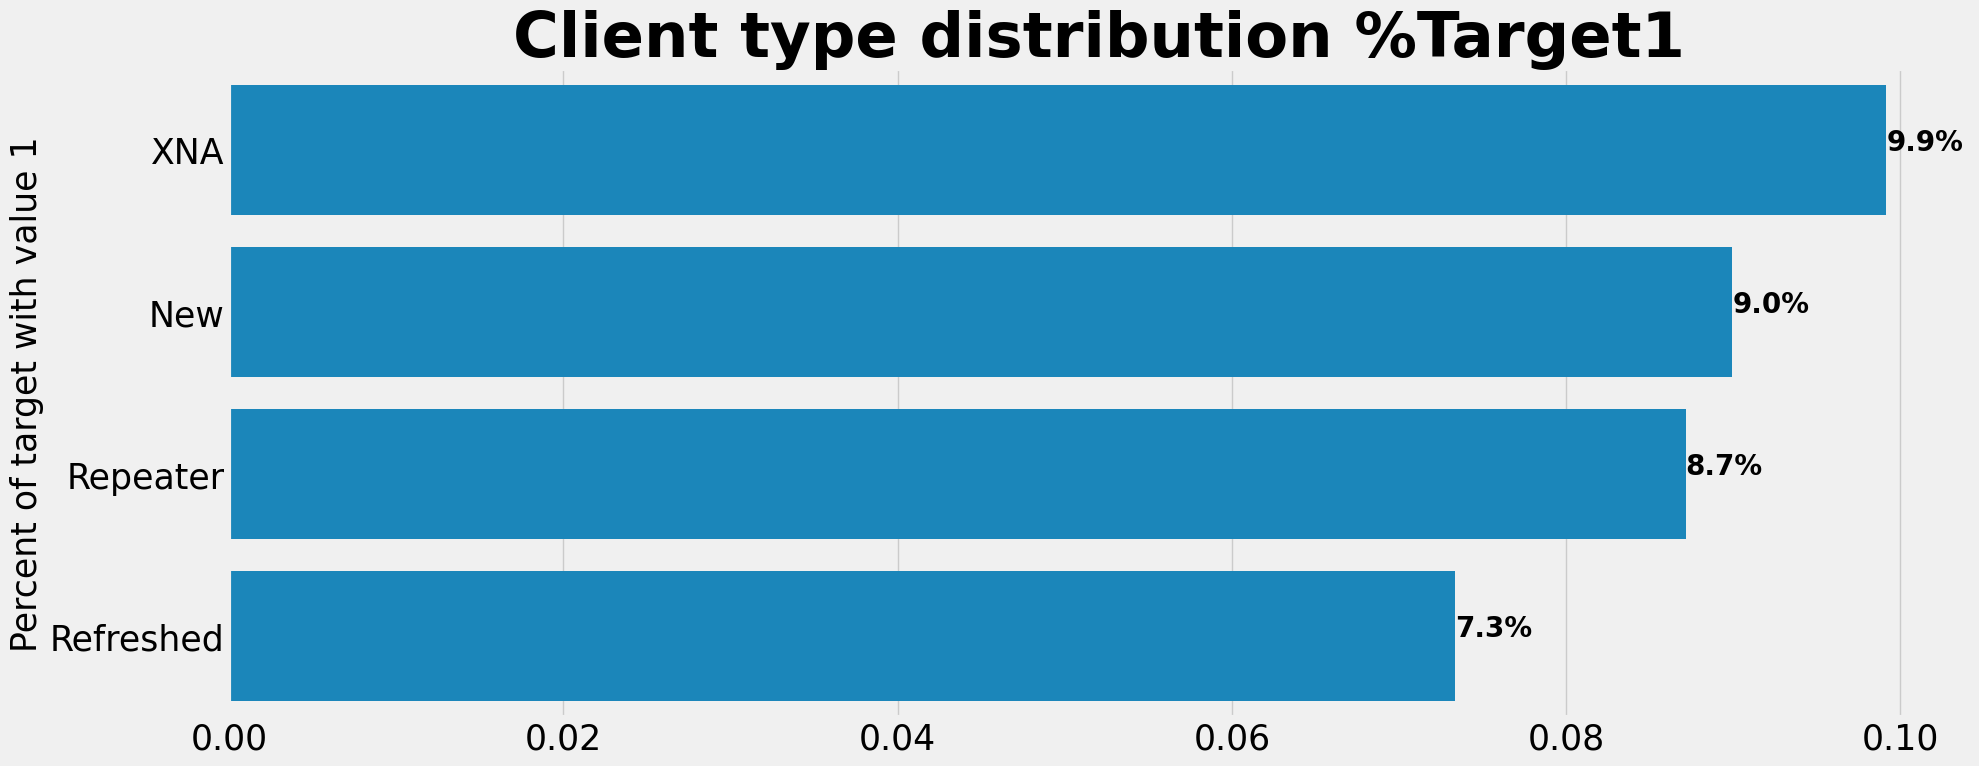

In [ ]:
#NAME_CLIENT_TYPE
plot_stat(application_prev_train, 'NAME_CLIENT_TYPE',"Client type distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_CLIENT_TYPE',"Client type distribution %Target1")

In [ ]:
del application_prev_train

Since "refreshed" has the smallest default rate, we can suppose that they are former customer seeking to re-establish a relationship with the institution

## 2) Merging and data aggregation
It is essential to think about and aggregate the data. Additional information to the main files can have an impact on our modelling. Let's take a look at how to process all the data sets...

In [ ]:
#Create a simple dataset with the train / test merge app
data = pd.concat([application_train,application_test])

The two datasets have exactly the same format, with the only difference being the TARGET available on the train.

In [ ]:
print('Train:' + str(application_train.shape))
print('Test:' + str(application_test.shape))
print('>>> Data:' + str(data.shape))

Train:(307511, 123)
Test:(48744, 122)
>>> Data:(356255, 123)


In [ ]:
#Now just in case, let's check if we've got it right
data.TARGET.isna().sum()

48744

In [ ]:
sum(data.SK_ID_CURR[data.TARGET.isna()] == application_test.SK_ID_CURR) #all is good

48744

In [ ]:
sum(data.SK_ID_CURR.isin(application_test.SK_ID_CURR)) == len(application_test) #nothing else to prove

True

#### Bureau previous loans (not home credit)

##### ``bureau`` : ``bureau.csv``

From the file ``bureau.csv``, it is possible to extract a history of previous loans registered by customers. It may therefore be interesting to enrich the sample with this type of data.

In [ ]:
display(bureau.head())
display(bureau.shape)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0             -153.000           -153.000   
1                   0             1075.000                NaN   
2                   0              528.000                NaN   
3                   0                  NaN                NaN   
4                   0             1197.000                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0       91323.000   
1                     NaN                   0      225000.000   
2                     NaN                   0      464323.500   
3                     NaN                   0       90000.000   
4               77674.500                   0     2700000.000   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                0.000                   NaN                   0.000   
1           171342.000                   NaN                   0.000   
2                  NaN                   NaN                   0.000   
3                  NaN                   NaN                   0.000   
4                  NaN                   NaN                   0.000   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

(1716428, 17)

Calculation of the total number of previous loans taken out by each customer. This type of information will enrich the work sample...

In [ ]:
#Total number of previous credits taken by each customer
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

SK_ID_CURR  PREVIOUS_LOANS_COUNT
0      100001                     7
1      100002                     8
2      100003                     4
3      100004                     2
4      100005                     3

In [ ]:
#Merge this new column in our data sample
data = data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
data.shape

(356255, 124)

#####``bureau_balance`` : ``bureau_balance.csv``

From the file ``bureau_balance.csv``, it is possible to extract a history of previous loans registered by customers. It may therefore be interesting to enrich the sample with this type of data.

In [ ]:
description[description['Row']=='MONTHS_BALANCE']

Table             Row  \
143       bureau_balance.csv  MONTHS_BALANCE   
147     POS_CASH_balance.csv  MONTHS_BALANCE   
155  credit_card_balance.csv  MONTHS_BALANCE   

                                                                                                                                                                                                                                                        Description  \
143                                                                                                                                                                              Month of balance relative to application date (-1 means the freshest balance date)   
147  Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )   
155                                                                                                                                                                              Month of balance relative to application date (-1 means the freshest balance date)   

                                   Special  
143  time only relative to the application  
147  time only relative to the application  
155  time only relative to the application

In [ ]:
bureau_balance['MONTHS_BALANCE'].unique()

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
       -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
       -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
       -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
       -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64,
       -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77,
       -78, -79, -80, -81, -82, -83, -84, -85, -86, -87, -88, -89, -90,
       -91, -92, -93, -94, -95, -96])

In [ ]:
description[description['Row']=='STATUS']

Table     Row  \
144  bureau_balance.csv  STATUS   

                                                                                                                                                                                                                                          Description  \
144  Status of Credit Bureau loan during the month (active, closed, DPD0-30,
 [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,
 5 means DPD 120+ or sold or written off ] )   

    Special  
144     NaN

In [ ]:
description[description['Row']=='SK_ID_CURR']

Table         Row  \
1    application_{train|test}.csv  SK_ID_CURR   
125                    bureau.csv  SK_ID_CURR   
146          POS_CASH_balance.csv  SK_ID_CURR   
154       credit_card_balance.csv  SK_ID_CURR   
177      previous_application.csv  SK_ID_CURR   
215     installments_payments.csv  SK_ID_CURR   

                                                                                                             Description  \
1                                                                                               ID of loan in our sample   
125  ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau    
146                                                                                             ID of loan in our sample   
154                                                                                             ID of loan in our sample   
177                                                                                             ID of loan in our sample   
215                                                                                             ID of loan in our sample   

    Special  
1       NaN  
125  hashed  
146     NaN  
154  hashed  
177  hashed  
215  hashed

In [ ]:
display(bureau_balance.head())
display(bureau_balance.shape)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

(27299925, 3)

In [ ]:
# Convert STATUS (categorical variable) into quantiative variable
# C -> 0 (credit closed, low risk)
# X -> -1 (neutral or unknown value)
# 0 -> 0 (no delay, low risk)
# 1 -> 1 (1-30 days past due, moderate risk)
# 2 -> 2 (31-60 days late, higher risk)
# 3 -> 3, 4 -> 4, 5 -> 5 (very high risk/major defect or radiation)

status_mapping = {'C': 0, 'X': -1, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
bureau_balance['STATUS_ENCODED'] = bureau_balance['STATUS'].map(status_mapping)

In [ ]:
#Monthly average balances of previous credits in Credit Bureau and Status average.
bureau_bal_mean = bureau_balance.groupby('SK_ID_BUREAU', as_index=False).agg({'MONTHS_BALANCE': 'mean',
                                                                              'STATUS_ENCODED' : 'mean'}
                                                                             ) # Use 'mean' as a string within agg
# rename the column after the aggregation to avoid potential errors with string columns.
bureau_bal_mean = bureau_bal_mean.rename(columns={'MONTHS_BALANCE': 'MONTHS_BALANCE_MEAN',
                                                  'STATUS_ENCODED':'STATUS_MEAN'})
bureau_bal_mean.head()

SK_ID_BUREAU  MONTHS_BALANCE_MEAN  STATUS_MEAN
0       5001709              -48.000       -0.113
1       5001710              -41.000       -0.361
2       5001711               -1.500       -0.250
3       5001712               -9.000        0.000
4       5001713              -10.500       -1.000

##### Merging ``bureau`` and ``bureau_balance`` new features and adding to main dataframe

In [ ]:
bureau_full = bureau.merge(bureau_bal_mean, on='SK_ID_BUREAU', how='left')
bureau_full.drop('SK_ID_BUREAU', axis=1, inplace=True)
display(bureau_full.head())
display(bureau_full.shape)

SK_ID_CURR CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
0      215354        Closed      currency 1         -497                   0   
1      215354        Active      currency 1         -208                   0   
2      215354        Active      currency 1         -203                   0   
3      215354        Active      currency 1         -203                   0   
4      215354        Active      currency 1         -629                   0   

   DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0             -153.000           -153.000                     NaN   
1             1075.000                NaN                     NaN   
2              528.000                NaN                     NaN   
3                  NaN                NaN                     NaN   
4             1197.000                NaN               77674.500   

   CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
0                   0       91323.000                0.000   
1                   0      225000.000           171342.000   
2                   0      464323.500                  NaN   
3                   0       90000.000                  NaN   
4                   0     2700000.000                  NaN   

   AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  \
0                   NaN                   0.000  Consumer credit   
1                   NaN                   0.000      Credit card   
2                   NaN                   0.000  Consumer credit   
3                   NaN                   0.000      Credit card   
4                   NaN                   0.000  Consumer credit   

   DAYS_CREDIT_UPDATE  AMT_ANNUITY  MONTHS_BALANCE_MEAN  STATUS_MEAN  
0                -131          NaN                  NaN          NaN  
1                 -20          NaN                  NaN          NaN  
2                 -16          NaN                  NaN          NaN  
3                 -16          NaN                  NaN          NaN  
4                 -21          NaN                  NaN          NaN

(1716428, 18)

In [ ]:
# Calculate the mean only for numeric columns.
bureau_mean = bureau_full.groupby('SK_ID_CURR', as_index=False).mean(numeric_only=True).add_prefix('PREV_BUR_MEAN_')
bureau_mean = bureau_mean.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})
bureau_mean.shape

(305811, 15)

In [ ]:
bureau_mean.head()

SK_ID_CURR  PREV_BUR_MEAN_DAYS_CREDIT  PREV_BUR_MEAN_CREDIT_DAY_OVERDUE  \
0      100001                   -735.000                             0.000   
1      100002                   -874.000                             0.000   
2      100003                  -1400.750                             0.000   
3      100004                   -867.000                             0.000   
4      100005                   -190.667                             0.000   

   PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE  PREV_BUR_MEAN_DAYS_ENDDATE_FACT  \
0                             82.429                         -825.500   
1                           -349.000                         -697.500   
2                           -544.500                        -1097.333   
3                           -488.500                         -532.500   
4                            439.333                         -123.000   

   PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE  PREV_BUR_MEAN_CNT_CREDIT_PROLONG  \
0                                   NaN                             0.000   
1                              1681.029                             0.000   
2                                 0.000                             0.000   
3                                 0.000                             0.000   
4                                 0.000                             0.000   

   PREV_BUR_MEAN_AMT_CREDIT_SUM  PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT  \
0                    207623.571                          85240.929   
1                    108131.946                          49156.200   
2                    254350.125                              0.000   
3                     94518.900                              0.000   
4                    219042.000                         189469.500   

   PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT  PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE  \
0                               0.000                                 0.000   
1                            7997.141                                 0.000   
2                          202500.000                                 0.000   
3                               0.000                                 0.000   
4                               0.000                                 0.000   

   PREV_BUR_MEAN_DAYS_CREDIT_UPDATE  PREV_BUR_MEAN_AMT_ANNUITY  \
0                           -93.143                   3545.357   
1                          -499.875                      0.000   
2                          -816.000                        NaN   
3                          -532.000                        NaN   
4                           -54.333                   1420.500   

   PREV_BUR_MEAN_MONTHS_BALANCE_MEAN  PREV_BUR_MEAN_STATUS_MEAN  
0                            -11.786                     -0.207  
1                            -21.875                      0.094  
2                                NaN                        NaN  
3                                NaN                        NaN  
4                             -3.000                     -0.137

In [ ]:
#Merge all this features with our data sample
data = data.merge(bureau_mean, on='SK_ID_CURR', how='left')
data.shape

(356255, 138)

We've added 14 new features, created and added to our train/test application dataset.

#### ``previous_application`` enrichment

##### previous_application itself

Checking 'SK_ID_CURR' values between data and previous_application...

In [ ]:
display(previous_application.head())
display(previous_application.shape)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430        17145.000   
1     2802425      108129         Cash loans    25188.615       607500.000   
2     2523466      122040         Cash loans    15060.735       112500.000   
3     2819243      176158         Cash loans    47041.335       450000.000   
4     1784265      202054         Cash loans    31924.395       337500.000   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0   17145.000             0.000        17145.000                   SATURDAY   
1  679671.000               NaN       607500.000                   THURSDAY   
2  136444.500               NaN       112500.000                    TUESDAY   
3  470790.000               NaN       450000.000                     MONDAY   
4  404055.000               NaN       337500.000                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1              0.000                  0.183   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                     0.867                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0       12.000           middle  POS mobile with interest          365243.000   
1       36.000       low_action          Cash X-Sell: low          365243.000   
2       12.000             high         Cash X-Sell: high          365243.000   
3       12.000           middle       Cash X-Sell: middle          365243.000   
4       24.000             high         Cash Street: high                 NaN   

   D

(1670214, 37)

In [ ]:
description.head()

Table                 Row  \
1  application_{train|test}.csv          SK_ID_CURR   
2  application_{train|test}.csv              TARGET   
5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
6  application_{train|test}.csv         CODE_GENDER   
7  application_{train|test}.csv        FLAG_OWN_CAR   

                                                                                                                                                                                   Description  \
1                                                                                                                                                                     ID of loan in our sample   
2  Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)   
5                                                                                                                                                  Identification if loan is cash or revolving   
6                                                                                                                                                                         Gender of the client   
7                                                                                                                                                                Flag if the client owns a car   

  Special  
1     NaN  
2     NaN  
5     NaN  
6     NaN  
7     NaN

In [ ]:
#Check
len(previous_application.SK_ID_CURR.isin(data.SK_ID_CURR)) == len(previous_application)

True

As before, let's start by quantifying the number of previous home loans applications made by customers and add this data to the sample.

In [ ]:
previous_application['NAME_CONTRACT_STATUS'].unique()

array(['Approved', 'Refused', 'Canceled', 'Unused offer'], dtype=object)

In [ ]:
# Convert NAME_CONTRACT_STATUS (categorical variable) into quantitative variable
# Approved -> 0 (application approved, low risk)
# Unused offer -> 0 (offer approved but not used, low/neutral risk)
# Refused -> 1 (application refused, possible higher risk or non-eligibility)
# Canceled -> 1 (application canceled by client or process, possible indecision or inconsistency)

status_mapping = {'Approved': 0, 'Unused offer': 0, 'Refused': 1, 'Canceled': 1}
previous_application['PREVIOUS_APPLICATION_DEFAULT_RATE'] = previous_application['NAME_CONTRACT_STATUS'].map(status_mapping)

In [ ]:
#Monthly average balances of previous credits in Credit Bureau and Status average.
previous_application_counts_and_mean = previous_application.groupby('SK_ID_CURR', as_index=False).agg({'SK_ID_PREV': 'count',
                                                                              'PREVIOUS_APPLICATION_DEFAULT_RATE' : 'mean'}
                                                                             ) # Use 'mean' as a string within agg
# rename the column after the aggregation to avoid potential errors with string columns.
previous_application_counts_and_mean = previous_application_counts_and_mean.rename(columns={
    'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts_and_mean.head()

SK_ID_CURR  PREVIOUS_APPLICATION_COUNT  PREVIOUS_APPLICATION_DEFAULT_RATE
0      100001                           1                              0.000
1      100002                           1                              0.000
2      100003                           3                              0.000
3      100004                           1                              0.000
4      100005                           2                              0.500

In [ ]:
#Merge this new column in our data sample
data = data.merge(previous_application_counts_and_mean, on='SK_ID_CURR', how='left')
data.shape

(356255, 140)

Added 2 features : previous applications count AND mean approval rate

##### ``credit_card_balance``

In [ ]:
display(credit_card_balance.head())
display(credit_card_balance.shape)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                     0.000               877.500   
1                    45000                  2250.000              2250.000   
2                   450000                     0.000                 0.000   
3                   225000                  2250.000              2250.000   
4                   450000                     0.000             11547.000   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                       0.000                   877.500   
1                       0.000                     0.000   
2                       0.000                     0.000   
3                       0.000                     0.000   
4                       0.000                 11547.000   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325             1800.000                   1800.000   
1                 2250.000             2250.000                   2250.000   
2                 2250.000             2250.000                   2250.000   
3                11795.760            11925.000                  11925.000   
4                22924.890            27000.000                  27000.000   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                     0.000                     1                       0.000   
1                     1.000                     1                       0.000   
2                     0.000                     0                       0.000   
3                     1.000                     1                       0.000   
4                     0.000                     1                       0.000   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                     1.000                     35.000               Active   
1                     0.000                     69.000               Active   
2                     0.000                     30.000               Active   
3                     0.000                     10.000               Active   
4                     1.000                    101.000               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

(3840312, 23)

In [ ]:
credit_card_balance.drop('SK_ID_CURR', axis=1, inplace=True)

In [ ]:
credit_card_balance_mean = credit_card_balance.groupby('SK_ID_PREV', as_index=False).mean(numeric_only=True).add_prefix('CARD_MEAN_')
credit_card_balance_mean.rename(columns = {'CARD_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
credit_card_balance_mean.shape

(104307, 21)

In [ ]:
#Merge with previous_application
previous_application = previous_application.merge(credit_card_balance_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 58)

##### ``installments_payments``

In [ ]:
installments_payments.columns
for col in installments_payments.columns:
  select = (description['Row']==col) & (description['Table']=='installments_payments.csv')
  if select.any():
    # Accessing the Description column using .loc and column name outside the f-string
    desc = description.loc[select, 'Description'].iloc[0]
    print(f'{col}: {desc}')
  else:
    print(f'{col}: No description')

SK_ID_PREV: No description
SK_ID_CURR: ID of loan in our sample
NUM_INSTALMENT_VERSION: Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
NUM_INSTALMENT_NUMBER: On which installment we observe payment
DAYS_INSTALMENT: When the installment of previous credit was supposed to be paid (relative to application date of current loan)
DAYS_ENTRY_PAYMENT: When was the installments of previous credit paid actually (relative to application date of current loan)
AMT_INSTALMENT: What was the prescribed installment amount of previous credit on this installment
AMT_PAYMENT: What the client actually paid on previous credit on this installment


In [ ]:
display(installments_payments.head())
display(installments_payments.shape)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                   1.000                      6   
1     1330831      151639                   0.000                     34   
2     2085231      193053                   2.000                      1   
3     2452527      199697                   1.000                      3   
4     2714724      167756                   1.000                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0        -1180.000           -1187.000        6948.360     6948.360  
1        -2156.000           -2156.000        1716.525     1716.525  
2          -63.000             -63.000       25425.000    25425.000  
3        -2418.000           -2426.000       24350.130    24350.130  
4        -1383.000           -1366.000        2165.040     2160.585

(13605401, 8)

In [ ]:
installments_payments.drop('SK_ID_CURR', axis=1, inplace=True)

In [ ]:
install_pay_mean = installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('INSTALL_MEAN_')
install_pay_mean.rename(columns = {'INSTALL_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
install_pay_mean.shape

(997752, 7)

In [ ]:
#Merge with previous_application
previous_application = previous_application.merge(install_pay_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 64)

#####``POS_CASH_balance``

In [ ]:
installments_payments.columns
for col in POS_CASH_balance.columns:
  select = (description['Row']==col) & (description['Table']=='POS_CASH_balance.csv')
  if select.any():
    # Accessing the Description column using .loc and column name outside the f-string
    desc = description.loc[select, 'Description'].iloc[0]
    print(f'{col}: {desc}')
  else:
    print(f'{col}: No description')

SK_ID_PREV: No description
SK_ID_CURR: ID of loan in our sample
MONTHS_BALANCE: Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )
CNT_INSTALMENT: Term of previous credit (can change over time)
CNT_INSTALMENT_FUTURE: Installments left to pay on the previous credit
NAME_CONTRACT_STATUS: Contract status during the month
SK_DPD: DPD (days past due) during the month of previous credit
SK_DPD_DEF: DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit


In [ ]:
display(POS_CASH_balance.head())
display(POS_CASH_balance.shape)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31          48.000   
1     1715348      367990             -33          36.000   
2     1784872      397406             -32          12.000   
3     1903291      269225             -35          48.000   
4     2341044      334279             -35          36.000   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                 45.000               Active       0           0  
1                 35.000               Active       0           0  
2                  9.000               Active       0           0  
3                 42.000               Active       0           0  
4                 35.000               Active       0           0

(10001358, 8)

In [ ]:
POS_CASH_balance.drop('SK_ID_CURR', axis=1, inplace=True)

In [ ]:
POS_mean = installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('POS_MEAN_')
POS_mean.rename(columns = {'POS_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
POS_mean.shape

(997752, 7)

In [ ]:
#Merge with previous_application
previous_application = previous_application.merge(POS_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 70)

#####``previous_application`` enriched fusion with data

Return to ``previous_application`` to assemble the observation lines according to 'SK_ID_CURR'.

In [ ]:
display(previous_application.head())
display(previous_application.shape)

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430        17145.000   
1     2802425      108129         Cash loans    25188.615       607500.000   
2     2523466      122040         Cash loans    15060.735       112500.000   
3     2819243      176158         Cash loans    47041.335       450000.000   
4     1784265      202054         Cash loans    31924.395       337500.000   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0   17145.000             0.000        17145.000                   SATURDAY   
1  679671.000               NaN       607500.000                   THURSDAY   
2  136444.500               NaN       112500.000                    TUESDAY   
3  470790.000               NaN       450000.000                     MONDAY   
4  404055.000               NaN       337500.000                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1              0.000                  0.183   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                     0.867                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0       12.000           middle  POS mobile with interest          365243.000   
1       36.000       low_action          Cash X-Sell: low          365243.000   
2       12.000             high         Cash X-Sell: high          365243.000   
3       12.000           middle       Cash X-Sell: middle          365243.000   
4       24.000             high         Cash Street: high                 NaN   

   D

(1670214, 70)

In [ ]:
prev_appl_mean = previous_application.groupby('SK_ID_CURR', as_index=False).mean(numeric_only=True).add_prefix('PREV_APPL_MEAN_')
prev_appl_mean.rename(columns = {'PREV_APPL_MEAN_SK_ID_CURR' : 'SK_ID_CURR'}, inplace=True)
prev_appl_mean = prev_appl_mean.drop('PREV_APPL_MEAN_SK_ID_PREV', axis=1)

In [ ]:
display(prev_appl_mean.head())
display(prev_appl_mean.shape)

SK_ID_CURR  PREV_APPL_MEAN_AMT_ANNUITY  PREV_APPL_MEAN_AMT_APPLICATION  \
0      100001                    3951.000                       24835.500   
1      100002                    9251.775                      179055.000   
2      100003                   56553.990                      435436.500   
3      100004                    5357.250                       24282.000   
4      100005                    4813.200                       22308.750   

   PREV_APPL_MEAN_AMT_CREDIT  PREV_APPL_MEAN_AMT_DOWN_PAYMENT  \
0                  23787.000                         2520.000   
1                 179055.000                            0.000   
2                 484191.000                         3442.500   
3                  20106.000                         4860.000   
4                  20076.750                         4464.000   

   PREV_APPL_MEAN_AMT_GOODS_PRICE  PREV_APPL_MEAN_HOUR_APPR_PROCESS_START  \
0                       24835.500                                  13.000   
1                      179055.000                                   9.000   
2                      435436.500                                  14.667   
3                       24282.000                                   5.000   
4                       44617.500                                  10.500   

   PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY  PREV_APPL_MEAN_RATE_DOWN_PAYMENT  \
0                                  1.000                             0.104   
1                                  1.000                             0.000   
2                                  1.000                             0.050   
3                                  1.000                             0.212   
4                                  1.000                             0.109   

   PREV_APPL_MEAN_RATE_INTEREST_PRIMARY  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED  PREV_APPL_MEAN_DAYS_DECISION  \
0                                      NaN                     -1740.000   
1                                      NaN                      -606.000   
2                                      NaN                     -1305.000   
3                                      NaN                      -815.000   
4                                      NaN                      -536.000   

   PREV_APPL_MEAN_SELLERPLACE_AREA  PREV_APPL_MEAN_CNT_PAYMENT  \
0                           23.000                       8.000   
1                          500.000                      24.000   
2                          533.000                      10.000   
3                           30.000                       4.000   
4                           18.000                      12.000   

   PREV_APPL_MEAN_DAYS_FIRST_DRAWING  PREV_APPL_MEAN_DAYS_FIRST_DUE  \
0                         365243.000                      -1709.000   
1                         365243.000                       -565.000   
2                         365243.000                      -1274.333   
3                         365243.000                       -784.000   
4                         365243.000                       -706.000   

   PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION  PREV_APPL_MEAN_DAYS_LAST_DUE  \
0                                 -1499.000                     -1619.000   
1                                   125.000                       -25.000   
2                                 -1004.333                     -1054.333   
3                                  -694.000                      -724.000   
4                                  -376.000                      -466.000   

   PREV_APPL_MEAN_DAYS_TERMINATION  PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL  \
0                        -1612.000                                     0.000   
1                          -17.000                    

(338857, 53)

In [ ]:
#Reminder…
print('data shape', data.shape)

data shape (356255, 140)


In [ ]:
#Last merge with our data sample
data = data.merge(prev_appl_mean, on='SK_ID_CURR', how='left')
#data.set_index('SK_ID_CURR', inplace=True)
display(data.head())
display(data.shape)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002   1.000         Cash loans           M            N   
1      100003   0.000         Cash loans           F            N   
2      100004   0.000    Revolving loans           M            Y   
3      100006   0.000         Cash loans           F            N   
4      100007   0.000         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0        202500.000  406597.500    24700.500   
1               N             0        270000.000 1293502.500    35698.500   
2               Y             0         67500.000  135000.000     6750.000   
3               Y             0        135000.000  312682.500    29686.500   
4               Y             0        121500.000  513000.000    21865.500   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0       351000.000   Unaccompanied          Working   
1      1129500.000          Family    State servant   
2       135000.000   Unaccompanied          Working   
3       297000.000   Unaccompanied          Working   
4       513000.000   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019        9461       -637.000          -3648.000   
1                       0.004       16765      -1188.000          -1186.000   
2                       0.010       19046       -225.000          -4260.000   
3                       0.008       19005      -3039.000          -9833.000   
4                       0.029       19932      -3038.000          -4311.000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531       26.000           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers            1.000   
1                 1           1           0      Core staff            2.000   
2                 1           1           0        Laborers            1.000   
3                 1           0           0        Laborers            2.000   
4                 1           0           0      Core staff            1.000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

(356255, 192)

In [ ]:
data.shape[1] - application_train.shape[1]

69

***69 new features were added to the sample following merging operations.***

## 3) Features engineering
It may be appropriate to enrich the sample by adding variables specific to the business issue. As we are not specialised in credit appraisal, we can carry out the modelling with a features selection stage to determine the relevance of these variables, as well as all the other variables in the sample.

### 5 features extraites des précédentes étapes
As a reminder, the previous stages consisted solely of establishing links between our files and merging tables in order to enrich the work sample. That said, before merging the elements, we were able to easily extract __5 mean and count variables__.

``PREVIOUS_LOANS_COUNT`` from bureau.csv: Total number of previous loans taken out by each customer\
``MONTHS_BALANCE_MEAN`` from bureau_balance.csv: Average monthly balance on previous loans\
``STATUS_MEAN`` from bureau_balance.csv : average indicator based on loan status\
``PREVIOUS_APPLICATION_COUNT`` from previous_application.csv: Number of previous home loan applications from customers\
``PREVIOUS_APPLICATION_DEFAULT_RATE`` from previous_application.csv: percentage of loans granted


### Creation of 4 new business variables
Without being an expert in bank credit, it is fairly easy to come up with a few explanatory ratios. All the more so as a parallel watch will give you a better understanding of the issues at stake. Let's take a look below at the features that should be included.

``CREDIT_INCOME_PERCENT``: Percentage of credit amount in relation to a customer's income\
``ANNUITY_INCOME_PERCENT``: Percentage of loan annuity in relation to a customer's income\
``CREDIT_TERM``: Payment period in months\
``DAYS_EMPLOYED_PERCENT``: Percentage of days used in relation to the customer's age

In [ ]:
#Before…
data.shape

(356255, 192)

In [ ]:
data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TERM'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

In [ ]:
#After…
data.shape

(356255, 196)

In [ ]:
#New Variables from features engineering
features_engin = ['PREVIOUS_LOANS_COUNT', 'MONTHS_BALANCE_MEAN', 'PREVIOUS_APPLICATION_COUNT',
                   'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']

In [ ]:
#Display correlations with features engineering
print('Most Positive Correlations:\n', data.corr(numeric_only=True)['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Most Negative Correlations:\n', data.corr(numeric_only=True)['TARGET'].sort_values().head(15))

Most Positive Correlations:
 PREV_APPL_MEAN_PREVIOUS_APPLICATION_DEFAULT_RATE    0.064
PREVIOUS_APPLICATION_DEFAULT_RATE                   0.064
DAYS_EMPLOYED_PERCENT                               0.068
PREV_BUR_MEAN_DAYS_CREDIT_UPDATE                    0.069
PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY    0.074
DAYS_EMPLOYED                                       0.075
PREV_BUR_MEAN_MONTHS_BALANCE_MEAN                   0.076
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT       0.081
PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL   0.085
PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE              0.086
PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE       0.086
PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE                0.087
PREV_BUR_MEAN_DAYS_CREDIT                           0.090
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT   0.103
TARGET                                              1.000
Name: TARGET, dtype: float64
--------------------------
Most Negative Correlations:
 EXT_SOURCE_3    

The correlations described above have not changed following the extraction of the 7 features.

In [ ]:
%%time
#save merged data
compression_opts = dict(method='zip', archive_name='merged_data.csv')
data.to_csv('merged_data.zip', index=False, compression=compression_opts)

CPU times: user 54.5 s, sys: 558 ms, total: 55.1 s
Wall time: 58.5 s


In [ ]:
data['SK_ID_CURR']

0         100002
1         100003
2         100004
3         100006
4         100007
           ...  
356250    456221
356251    456222
356252    456223
356253    456224
356254    456250
Name: SK_ID_CURR, Length: 356255, dtype: int64

## 4) Data pre-processing

### Opening data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Colab_Notebooks/Project_4")
os.listdir()
# print(f'Working directory: {os.getcwd()}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['p7_02_modelisation_notebook.ipynb',
 'p7_01_eda_notebook.ipynb',
 'functions',
 'input',
 'start-here-a-gentle-introduction.ipynb',
 'scoring_model.ipynb',
 'EDA.ipynb',
 'merged_data.zip',
 'data_train.zip',
 'data_test.zip',
 'TARGET.csv',
 'train.zip',
 'test.zip',
 'MODEL.ipynb']

In [ ]:
# checkpoint
import pandas as pd

data = pd.read_csv('merged_data.zip', compression='zip')

In [ ]:
data.shape

(356255, 196)

In [ ]:
%%time
application_train = pd.read_csv('input/application_train.csv')
application_test = pd.read_csv('input/application_test.csv')

CPU times: user 2.37 s, sys: 202 ms, total: 2.57 s
Wall time: 2.7 s


### Split train / test data
You need to start by setting up the training/test data. This can be done using the application_train/test datasets as a reminder.

In [ ]:
data_train = data[data['SK_ID_CURR'].isin(application_train.SK_ID_CURR)]
data_test = data[data['SK_ID_CURR'].isin(application_test.SK_ID_CURR)]

data_test = data_test.drop('TARGET', axis=1)

In [ ]:
data['SK_ID_CURR'].nunique() == len(data)

True

In [ ]:
data_train.set_index('SK_ID_CURR', inplace=True)
data_test.set_index('SK_ID_CURR', inplace=True)

In [ ]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)

Training Features shape with categorical columns:  (307511, 195)
Testing Features shape with categorical columns:  (48744, 194)


### Encoding categorical features


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Create a label encoder object
le = LabelEncoder()
count = 0

# Iterate through the columns
for col in data_train:
    # If 2 or fewer unique categories
    if data_train.loc[:,col].dtype == 'object' and len(list(data_train.loc[:,col].unique())) <= 2:
        # Train on the training data
        le.fit(data_train.loc[:,col])
        # Transform both training and testing data
        data_train.loc[:,col] = le.transform(data_train.loc[:,col])
        data_test.loc[:,col] = le.transform(data_test.loc[:,col])

        count += 1

print('%d columns were label encoded. ()' % count)

3 columns were label encoded. ()


In [ ]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)

Training Features shape with categorical columns:  (307511, 195)
Testing Features shape with categorical columns:  (48744, 194)


In [ ]:
data_train = pd.get_dummies(data_train)
data_test = pd.get_dummies(data_test)

In [ ]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)

Training Features shape with categorical columns:  (307511, 319)
Testing Features shape with categorical columns:  (48744, 315)


In [ ]:
TARGET = data_train.TARGET #save our TARGET variable
data_train.drop('TARGET', axis=1, inplace=True) #remove TARGET from train

#Align the datasets
data_train, data_test = data_train.align(data_test, join='inner', axis=1)

In [ ]:
print(data_train.shape)
print(data_test.shape)

(307511, 315)
(48744, 315)


In [ ]:
#Copy before imputation of missing values
train = data_train.copy()
test = data_test.copy()
train.shape, test.shape

((307511, 315), (48744, 315))

### Imputation of missing values
One of the simplest approaches is to replace the NaNs with the Median (or Mean) for the corresponding variables.

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
print('Missing values in train data: ', sum(data_train.isnull().sum()))
print('Missing values in test data: ', sum(data_test.isnull().sum()))

Missing values in train data:  15791893
Missing values in test data:  2285942


In [ ]:
# Initialisation of the imputer
imputer = SimpleImputer(strategy='median')

# Application of imputation
data_train_transformed = pd.DataFrame(imputer.fit_transform(data_train), columns=data_train.columns)

# Reconvert types if necessary to respect the original ones
data_train_transformed = data_train_transformed.astype(data_train.dtypes)

# If desired, reassign to data_train
data_train = data_train_transformed

In [ ]:
imputer = SimpleImputer(strategy='median')

# Application of imputation
data_test_transformed = pd.DataFrame(imputer.fit_transform(data_test), columns=data_test.columns)

# Reconvert types if necessary to respect the original ones
data_test_transformed = data_test_transformed.astype(data_test.dtypes)

# If desired, reassign to data_train
data_test = data_test_transformed

In [ ]:
#Check Imputation step
sum(data_train.isnull().sum())

0

### Data normalization
The sample brings together variables of different sizes, for example salaries vs. the number of children, etc...

In [ ]:
from sklearn.preprocessing import MinMaxScaler

The MinMaxScaler is a preprocessing technique used to normalize numerical data by scaling values to a specific range, typically between 0 and 1. This is particularly important when working with machine learning models that are sensitive to feature scales, such as K-Nearest Neighbors (KNN), Support Vector Machines (SVM), logistic regression, or neural networks. By rescaling features to a uniform range, it ensures that no feature dominates others due to its magnitude.



In [ ]:
#Fit scaler to our training data
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data_train)
scaled_train = scaler.transform(data_train)

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data_test)
scaled_test = scaler.transform(data_test)

In [ ]:
#In order to keep our column names we include scaled_values to our train/test dataframes like this
data_train = pd.DataFrame(scaled_train, index=data_train.index, columns=data_train.columns)
data_test = pd.DataFrame(scaled_test, index=data_test.index, columns=data_test.columns)

In [ ]:
%%time
#save training data
compression_opts = dict(method='zip', archive_name='data_train.csv')
data_train.to_csv('data_train.zip', index=True, compression=compression_opts)

CPU times: user 1min 47s, sys: 777 ms, total: 1min 48s
Wall time: 1min 49s


In [ ]:
%%time
#save testing data
compression_opts = dict(method='zip', archive_name='data_test.csv')
data_test.to_csv('data_test.zip', index=True, compression=compression_opts)

CPU times: user 15.6 s, sys: 95.3 ms, total: 15.7 s
Wall time: 15.9 s


In [ ]:
#saving TARGET
TARGET.to_csv('TARGET.csv', index=True)

#### Same operations with data containing missing values
The idea is to be able to optimise the data before imputing the missing values so that we can also model and then, if necessary, compare the predictions via LightGBM, which tolerates NaN.

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train)
scaled_train = scaler.transform(train)

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(test)
scaled_test = scaler.transform(test)

In [ ]:
train = pd.DataFrame(scaled_train, index=train.index, columns=train.columns)
test = pd.DataFrame(scaled_test, index=test.index, columns=test.columns)

In [ ]:
%%time
compression_opts = dict(method='zip', archive_name='train.csv')
train.to_csv('train.zip', index=False, compression=compression_opts)

CPU times: user 1min 28s, sys: 783 ms, total: 1min 28s
Wall time: 1min 29s


In [ ]:
%%time
compression_opts = dict(method='zip', archive_name='test.csv')
test.to_csv('test.zip', index=False, compression=compression_opts)

CPU times: user 14.1 s, sys: 143 ms, total: 14.2 s
Wall time: 14.4 s


Modelling will be done on a Google Notebook (or Colaboratory)Colab to be able to use a GPU.
We'll be implementing the __Catboost, LightGBM & XGBoost...__ algorithms.

To understand the absolute basis for the need for the Boosting algorithm, let's ask a basic question - If a data point is predicted incorrectly by our first model, then the next (probably all models), will combining the predictions provide better results? These questions are addressed by a boosting algorithm.
Boosting is a sequential technique that works on the principle of ensemble, where each subsequent model attempts to correct the errors of the previous model. The subsequent models depend on the previous model.

The basic principle of how the boosting algorithm works is to generate several weak learners and combine their predictions to form a strong rule. These weak rules are generated by applying basic machine learning algorithms to different distributions of the dataset. These algorithms generate weak rules for each iteration. After several iterations, the weak learners are combined to form a strong learner that will predict a more accurate result.